In [1]:
import sys  
sys.path.insert(1, r'C:\Users\dintenr\Documents\scania_truck')
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from dataset import ScaniaDataset
from scripts.utils import MODEL_MAP
from torch.nn import functional as F
import lime
import shap
import matplotlib.pyplot as plt
from scripts.Scania_training import ScaniaModule
from lime import lime_tabular
from lime import submodular_pick
import re
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


c:\Users\dintenr\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Explaining Failures in MetroPT Dataset

Generating local and global explanations for pytorch deep learning models that predict the Remaining Useful Life of air production units in the Metro do Porto. For implementing the explainers LIME, Shap and TimeShap packages are used.

## Auxiliar funtions

In [2]:
def load_model_from_checkpoint(checkpoint_path):
    model = ScaniaModule.load_from_checkpoint(checkpoint_path)
    return model

In [3]:
# batch predict funtion for getting explanations of pytorch models with LIME
def batch_predict(data):
    '''
    Wrapper function for LIME explainer usage with Pytorch model. Receives a batch of data, moves both
    model and data to the same device, generates the predictions and move the prediction back to cpu as a 
    numpy array.

    Parameters
    ----------
    data : Tensor
        Batch of input data for the model.

    Returns
    -------
    np.array
        Numpy array with the predictions of the model.

    '''
    model.eval()
 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    data = torch.Tensor(data).to(device)
    
    outputs = model(data)
    return outputs.detach().cpu().numpy()

## Lime

In [4]:
checkpoint_path = r'..\..\checkpoints\model-version_1-definitive\checkpoint-epoch=01-val_score=46621.0000.ckpt'

In [5]:
model = load_model_from_checkpoint(checkpoint_path)

In [6]:
def get_lime_explanations(x, y, x_test, feature_names, class_names, model):
    '''
    Function to get LIME explanations for the model predictions
    model: trained model
    x: input data
    y: target data
    feature_names: list of feature names
    class_names: list of class names
    '''
    # Create the LIME recurrent explainer
    explainer = lime_tabular.RecurrentTabularExplainer(x, 
                                                       mode='classification', 
                                                       feature_names=feature_names, 
                                                       training_labels=y, 
                                                       discretize_continuous=False, 
                                                       class_names=class_names,
                                                       random_state=42)
    # Get the LIME explanations
    explanations = []
    for instance in x_test:
        exp = explainer.explain_instance(instance, batch_predict, num_features=(x_test.shape[1]*x_test.shape[2]),#feature_names.shape[0]
                                         labels=[0,1,2,3,4])
        explanations.append(exp)
    return explanations

In [7]:
only_two_classes = False
window_size = 200
cluster_specifications = False
train_loader, valid_loader, test_loader= ScaniaDataset.get_dataloaders(
        data_dir=r'..\..\..\..\..\Datasets\Scania\data',
        window_size=window_size,
        batch_size=256,
        validation_rate=0,
        stored_subsets=False,
        cluster_specifications=cluster_specifications,
        undersample=0.1,
        only_two_classes=only_two_classes,
        include_specifications=False,
        histogram_normalizer=False,
        forward_fill=False,
        pca=False)

# Get batch of training tensors

x_train, y_train = next(iter(train_loader))
# Get tensor from the test loader
# x_test, y_test = next(iter(valid_loader))

# Get the feature names
feature_names = np.array([f'feature_{i}' for i in range(x_train.shape[2])])
feature_names_og = train_loader.dataset.get_column_names()
feature_name_map = {f'feature_{i}': f for i, f in enumerate(feature_names_og)}

Vehicle count: 23549
Undersampling
Class 0 count: 21287
Class 4 count: 2000
Class 3 count: 161
Class 2 count: 70
Class 1 count: 31
Class 0 count: 2129
Class 4 count: 2000
Class 3 count: 161
Class 2 count: 70
Class 1 count: 31
All sequences concatenated
Total sequences: 187081
All sequences concatenated
Total sequences: 5046
All sequences concatenated
Total sequences: 5045


##### Pick module

In [38]:
def custom_plot(explainer):
    exp = explainer.as_list(label=1)
    fig = plt.figure(figsize=(25., 25.))
    vals = [x[1] for x in exp]
    names = [x[0] for x in exp]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(exp)) + .5
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names, rotation=45, fontsize=12)
    title = 'Local explanation for class %s' % explainer.class_names[1]
    plt.title(title, fontsize=25)
    return fig

In [12]:
explainer = lime_tabular.RecurrentTabularExplainer(x_train, 
                                                       mode='classification', 
                                                       feature_names=feature_names, 
                                                       training_labels=y_train, 
                                                       discretize_continuous=False, 
                                                       class_names=['0','1','2','3','4'],
                                                       random_state=42)

In [ ]:
def get_feature_importance_df(feature_importance):
    _ = []
    for row in feature_importance:
        _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
    feature_importance_df = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0) if len(_) > 0 else pd.DataFrame()
    return feature_importance_df
# _ = []
# for row in feature_importance:
#     _.append([ [re.findall(r'sensor_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
# feature_importance_df = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [7]:
def get_mean_feature_importace_per_feature(explainer, predict_fn, data, num_exps_desired=2, label=1 ):
    '''
    Function to get the mean feature importance for each feature
    explainer: LIME explainer object
    predict_fn: model prediction function
    data: input data
    label: label to explain
    num_exps_desired: number of explanations to get
    '''
    sp_obj = submodular_pick.SubmodularPick(explainer, data=data.numpy(), predict_fn=predict_fn, num_features=(data.shape[1]*data.shape[2]),num_exps_desired=num_exps_desired, labels=[0,1,2,3,4])
    feature_importance = [ _.as_list(label=label) for _ in sp_obj.sp_explanations]
    _ = []
    for row in feature_importance:
        _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
    return pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)
    # feature_importance_df = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)
    # return feature_importance_df[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False).reset_index()

In [8]:
# get test data
x_test, y_test = [], []
for x, y in test_loader:
    x_test.append(x)
    y_test.append(y)
x_test = torch.cat(x_test)[:100]
y_test = torch.cat(y_test)[:100]

In [8]:
def get_batch_with_label_from_loader(loader, label):
    for x, y in loader:
        model.eval()
        pred = model(x.to(model.device))
        if label in pred.argmax(dim=-1):
            return x, y

In [9]:
def get_batch_with_tp_or_fp_label_from_loader(loader, label, tp=True):
    for x, y in loader:
        model.eval()
        pred = model(x.to(model.device))
        pred = pred.argmax(dim=-1)
        y_argmax = y.argmax(dim=-1).view(-1)
        index_pred = torch.where(pred == label)[0]
        if tp:
            index_true = torch.where(y_argmax == label)[0]
        else:
            index_true = torch.where(y_argmax != label)[0]
        index = np.intersect1d(index_pred.cpu().numpy(), index_true.cpu().numpy())
        if index.size > 0:
            print(index_true)
            print(index_pred)
            print(index)
            return x[index], y[index]

In [10]:
def get_feature_importance_dataset_for_label(label, loader, model):
    x, y = get_batch_with_label_from_loader(loader, label)
    explainer = lime_tabular.RecurrentTabularExplainer(x, 
                                                       mode='classification', 
                                                       feature_names=feature_names, 
                                                       training_labels=y, 
                                                       discretize_continuous=False, 
                                                       class_names=['0','1','2','3','4'],
                                                       random_state=42)
    
    return get_mean_feature_importace_per_feature(explainer, batch_predict,  x, num_exps_desired=10, label=label)

## LIME Label 0

### General

In [10]:
label = 0

In [120]:
x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_label_from_loader(valid_loader, label) 

In [127]:
test_idx = pd.Series(y_test.argmax(dim=-1).view(-1).numpy())
test_idx = test_idx[test_idx == label].index.values.tolist()


In [145]:
explanation = get_lime_explanations(x_train, y_train, x_test[test_idx[:10]].numpy(), feature_names, ['0','1','2','3','4'], model)

In [149]:
explanation

In [154]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [155]:
feature_importance

feature timestamp         value
0       feature_0      t-92 -8.228293e-11
1       feature_5      t-92  6.181451e-11
2       feature_5      t-91  6.159348e-11
3       feature_0      t-91 -5.712435e-11
4       feature_0      t-90 -4.527855e-11
...           ...       ...           ...
21195  feature_66      t-44 -4.636855e-11
21196  feature_80     t-162  3.616020e-11
21197  feature_36     t-174 -2.819267e-11
21198  feature_10      t-48  9.725855e-12
21199   feature_3      t-28 -6.585687e-12

[212000 rows x 3 columns]

In [13]:
feature_importance = get_feature_importance_dataset_for_label(label=label, loader=valid_loader, model=model)

c:\Users\dintenr\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\lime\submodular_pick.py:57: UserWarning: Requested sample size larger than
                              size of input data. Using all data
  warnings.warn("""Requested sample size larger than


KeyError: 0

In [156]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

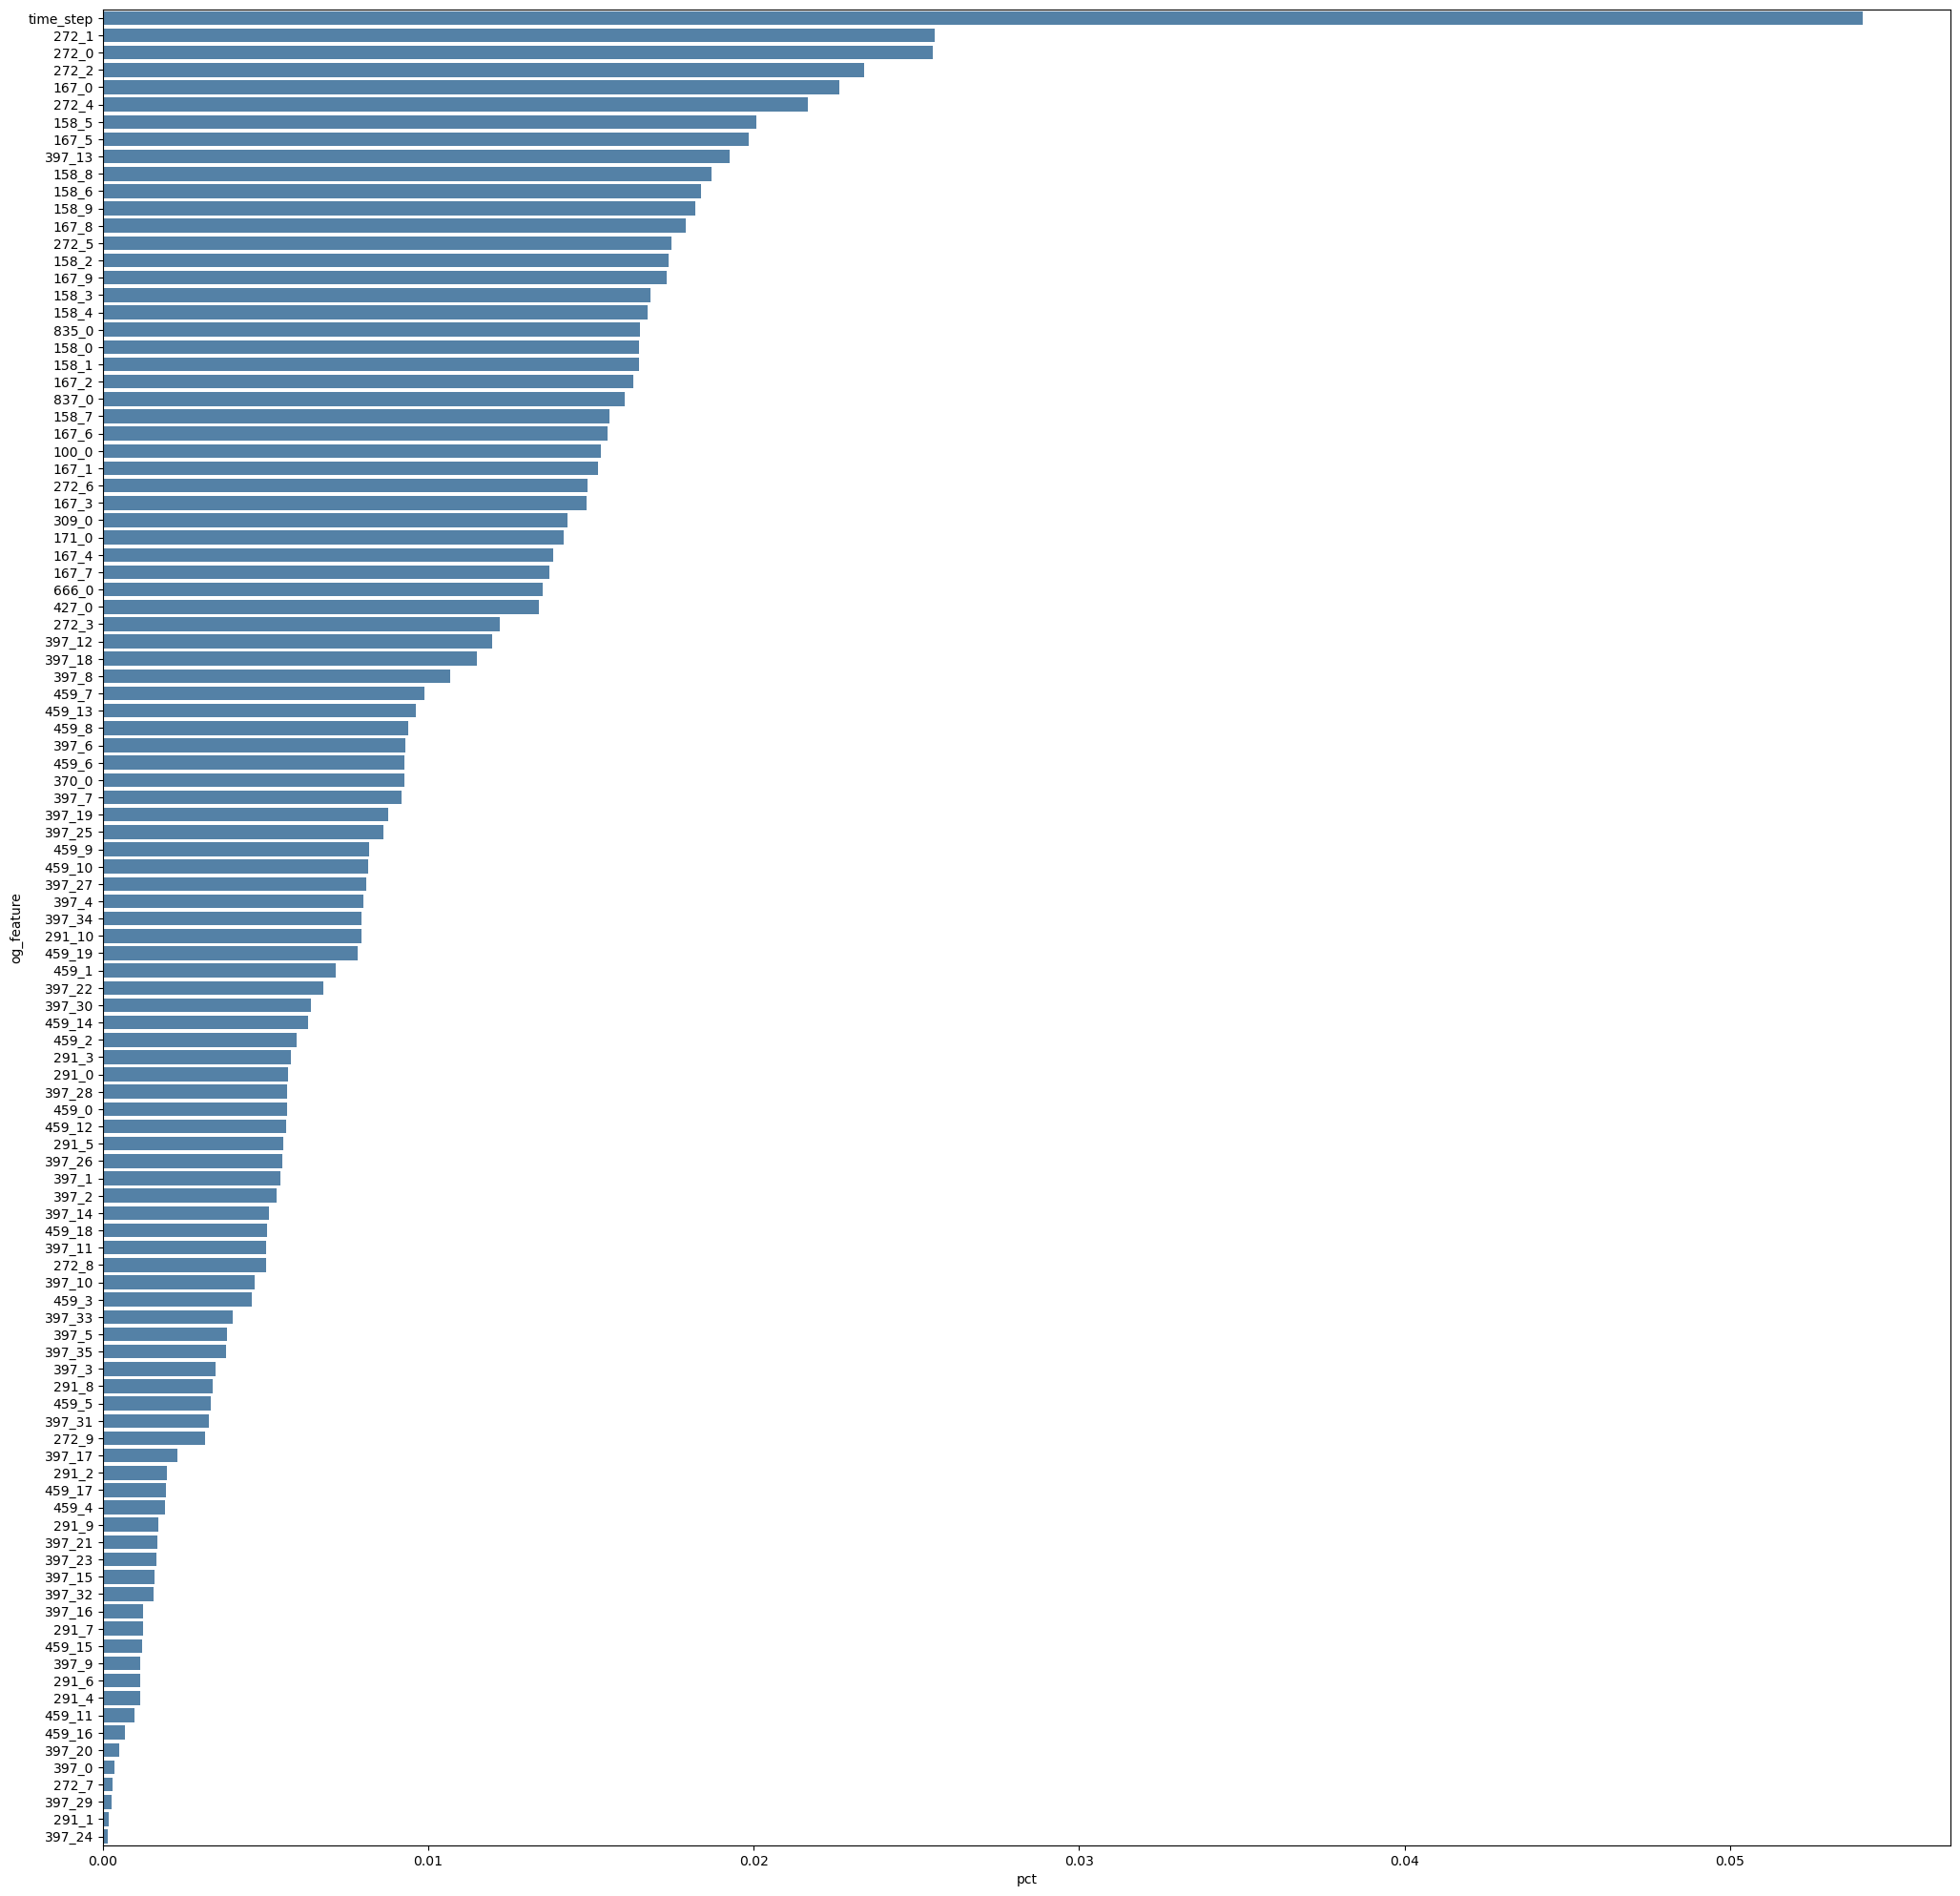

In [157]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum()
plt.figure(figsize=(25,25))
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [163]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [164]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').mean().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

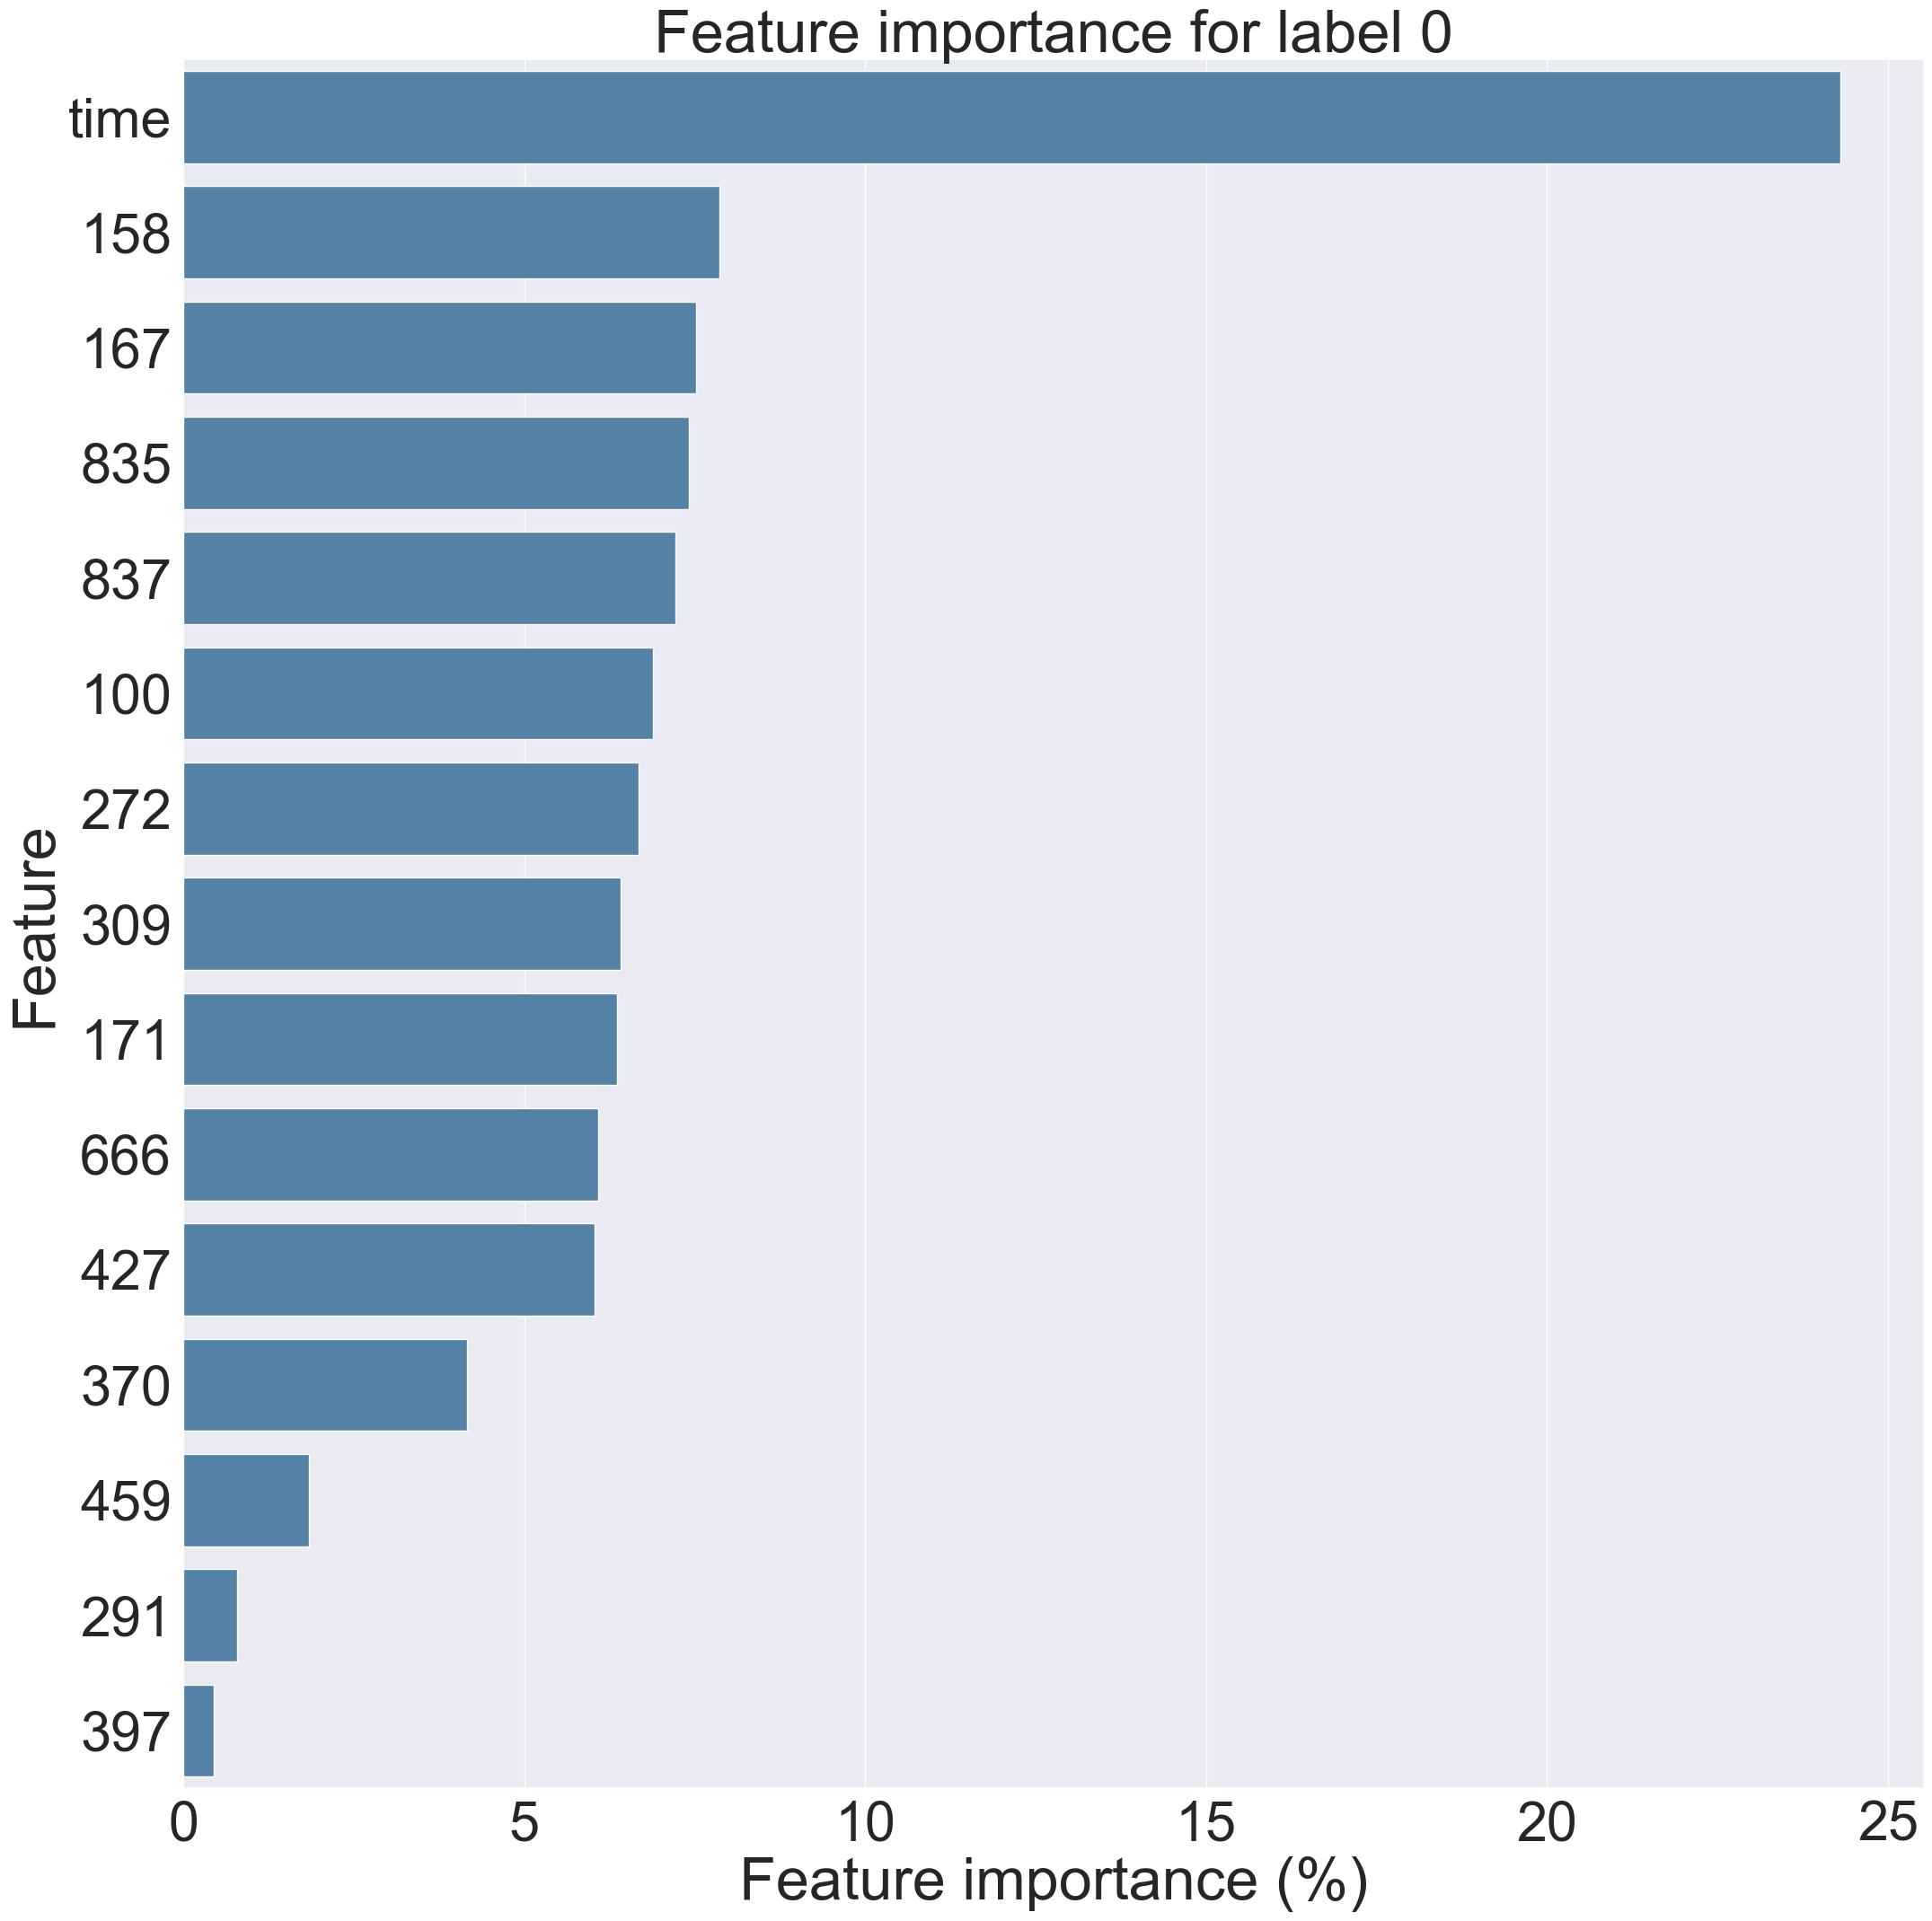

In [168]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label}')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

### True positive

In [244]:
label = 0

In [245]:
x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_tp_or_fp_label_from_loader(valid_loader, label, tp=True) 

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 1

In [247]:
# test_idx = pd.Series(y_test.argmax(dim=-1).view(-1).numpy())
# test_idx = test_idx[test_idx == label].index.values.tolist()
x_test.shape

torch.Size([4, 200, 106])

In [248]:
explanation = get_lime_explanations(x_train, y_train, x_test[:10].numpy(), feature_names, ['0','1','2','3','4'], model)

In [249]:
explanation

In [250]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [251]:
feature_importance

feature timestamp         value
0      feature_99       t-0  2.059921e-03
1      feature_99       t-1  1.788183e-03
2      feature_93       t-0  1.244782e-03
3      feature_93       t-1  1.044454e-03
4      feature_92       t-0  9.301778e-04
...           ...       ...           ...
21195  feature_79     t-159  1.567303e-08
21196  feature_73     t-120  1.412871e-08
21197  feature_28     t-147  1.122939e-08
21198   feature_6      t-80 -1.111708e-08
21199   feature_6     t-104  1.011391e-08

[84800 rows x 3 columns]

In [252]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

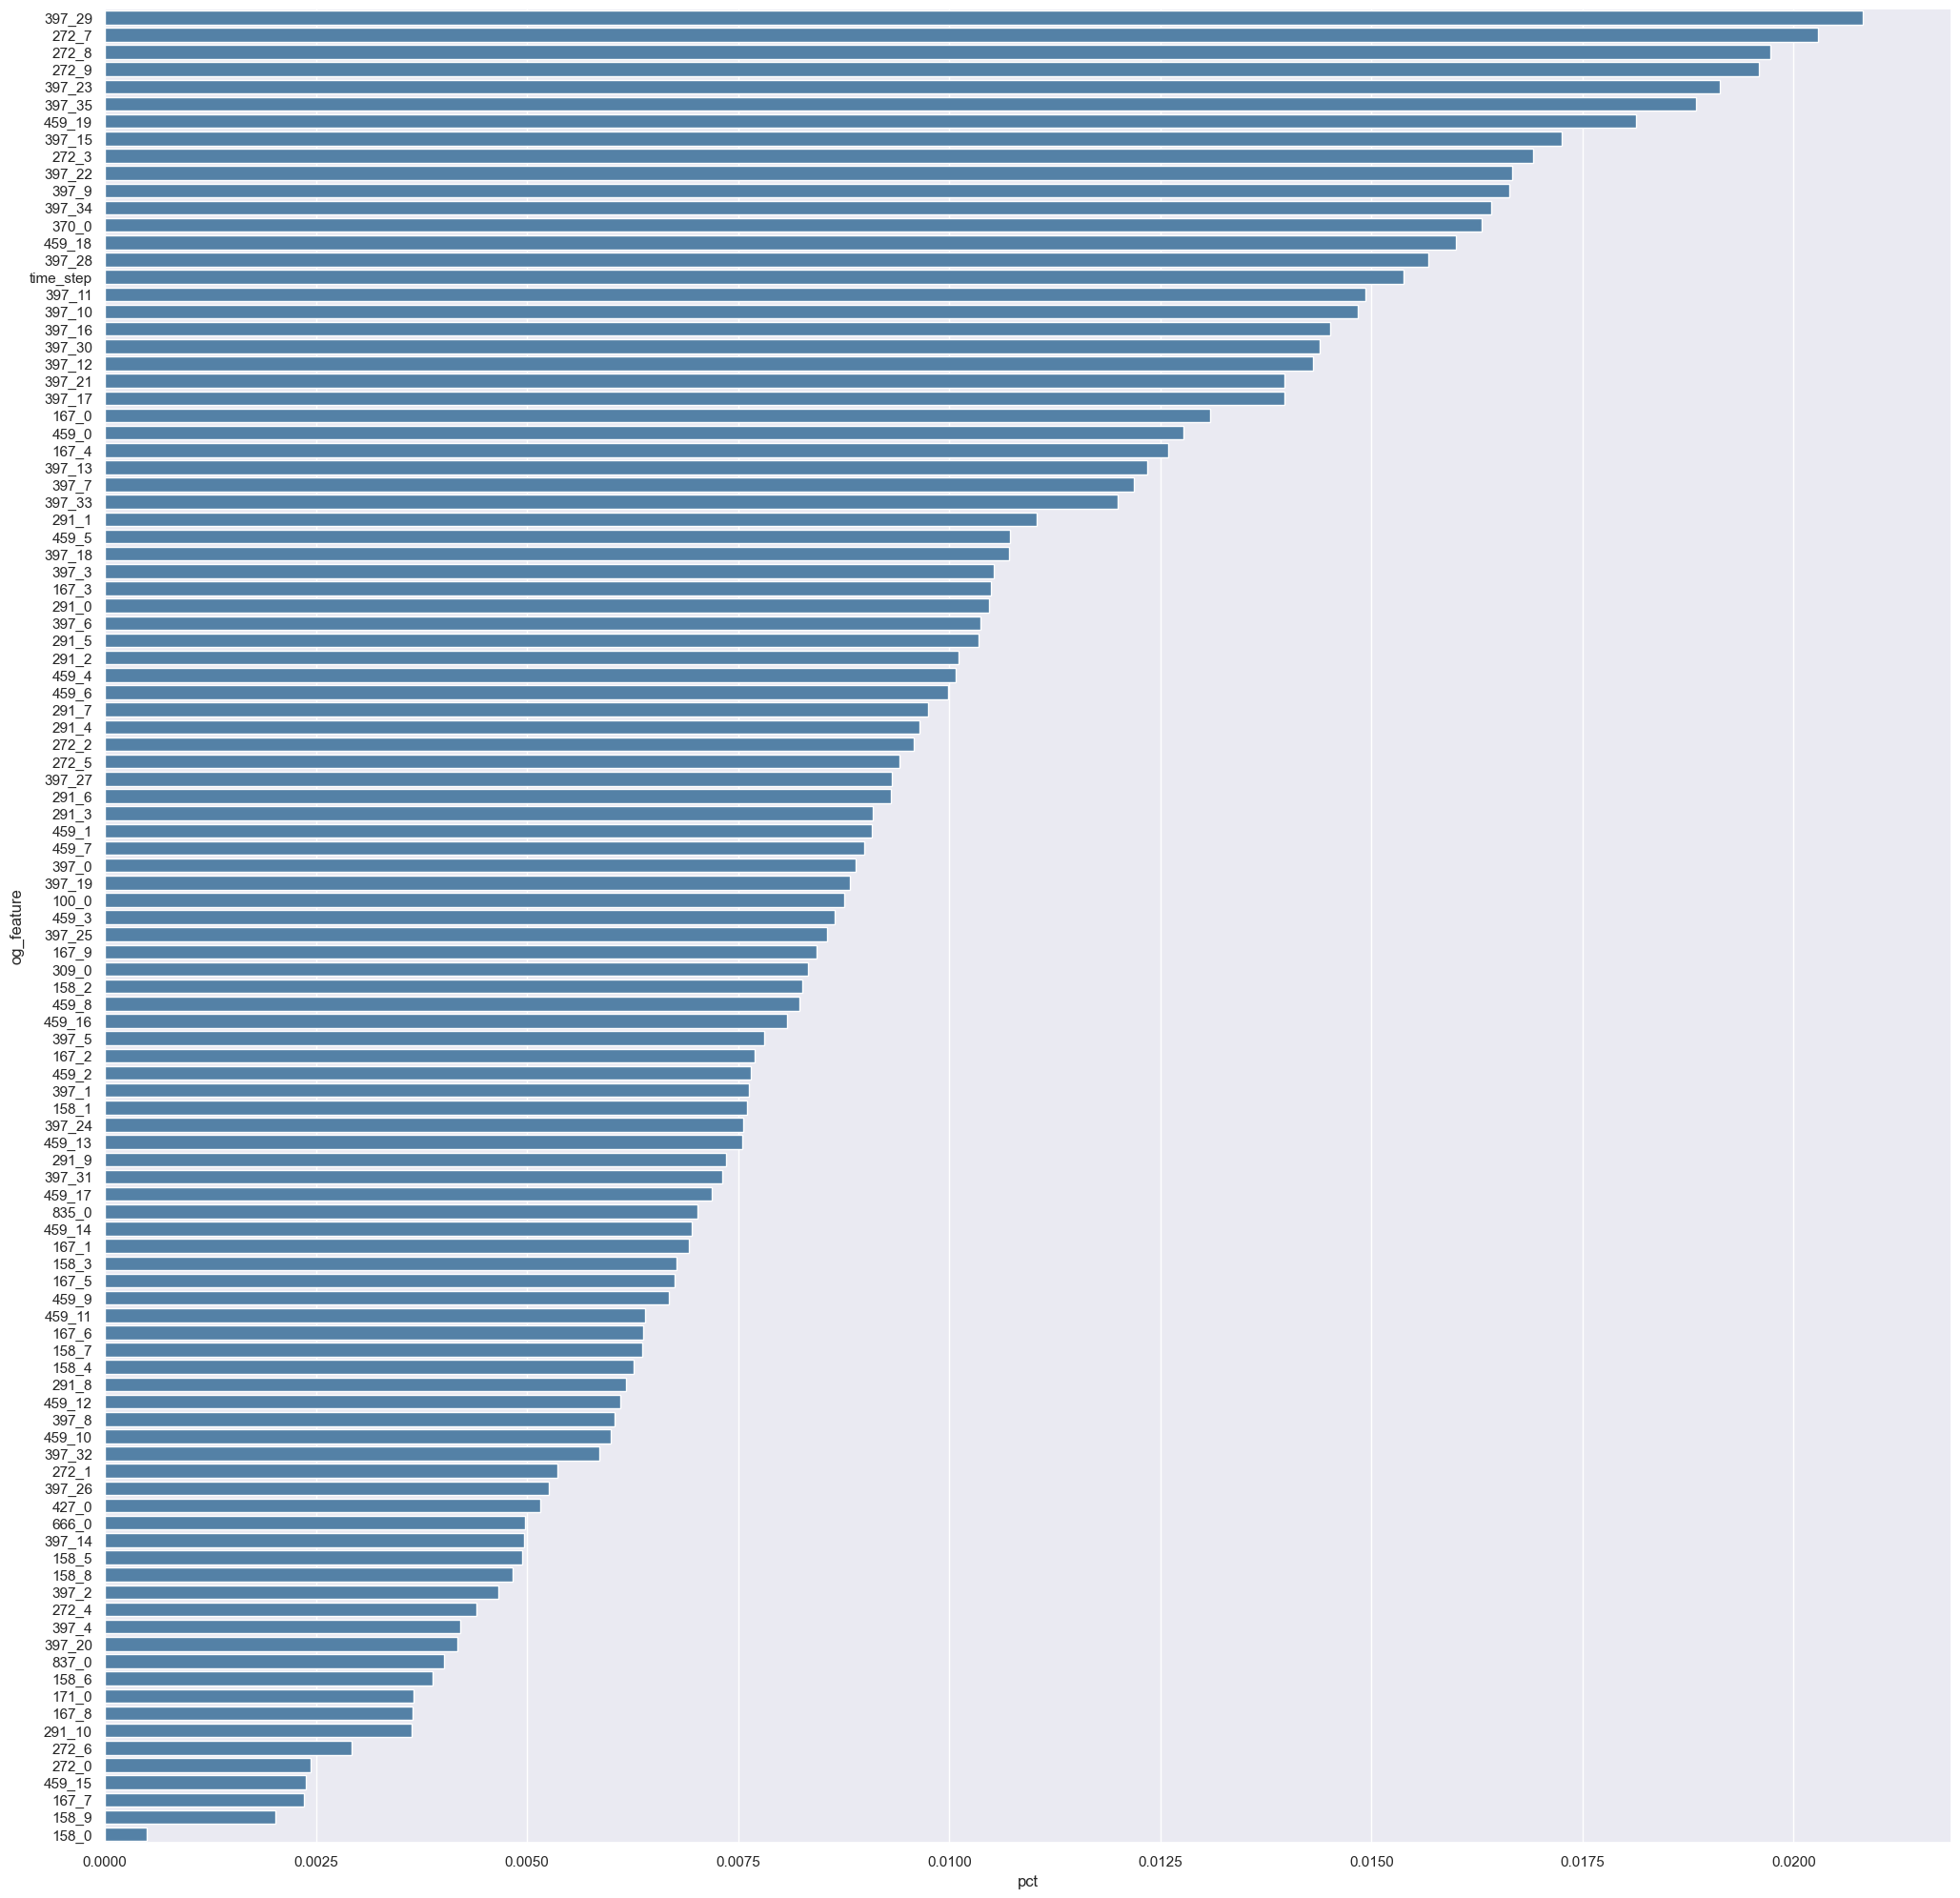

In [254]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum()
plt.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [255]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [256]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').sum().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

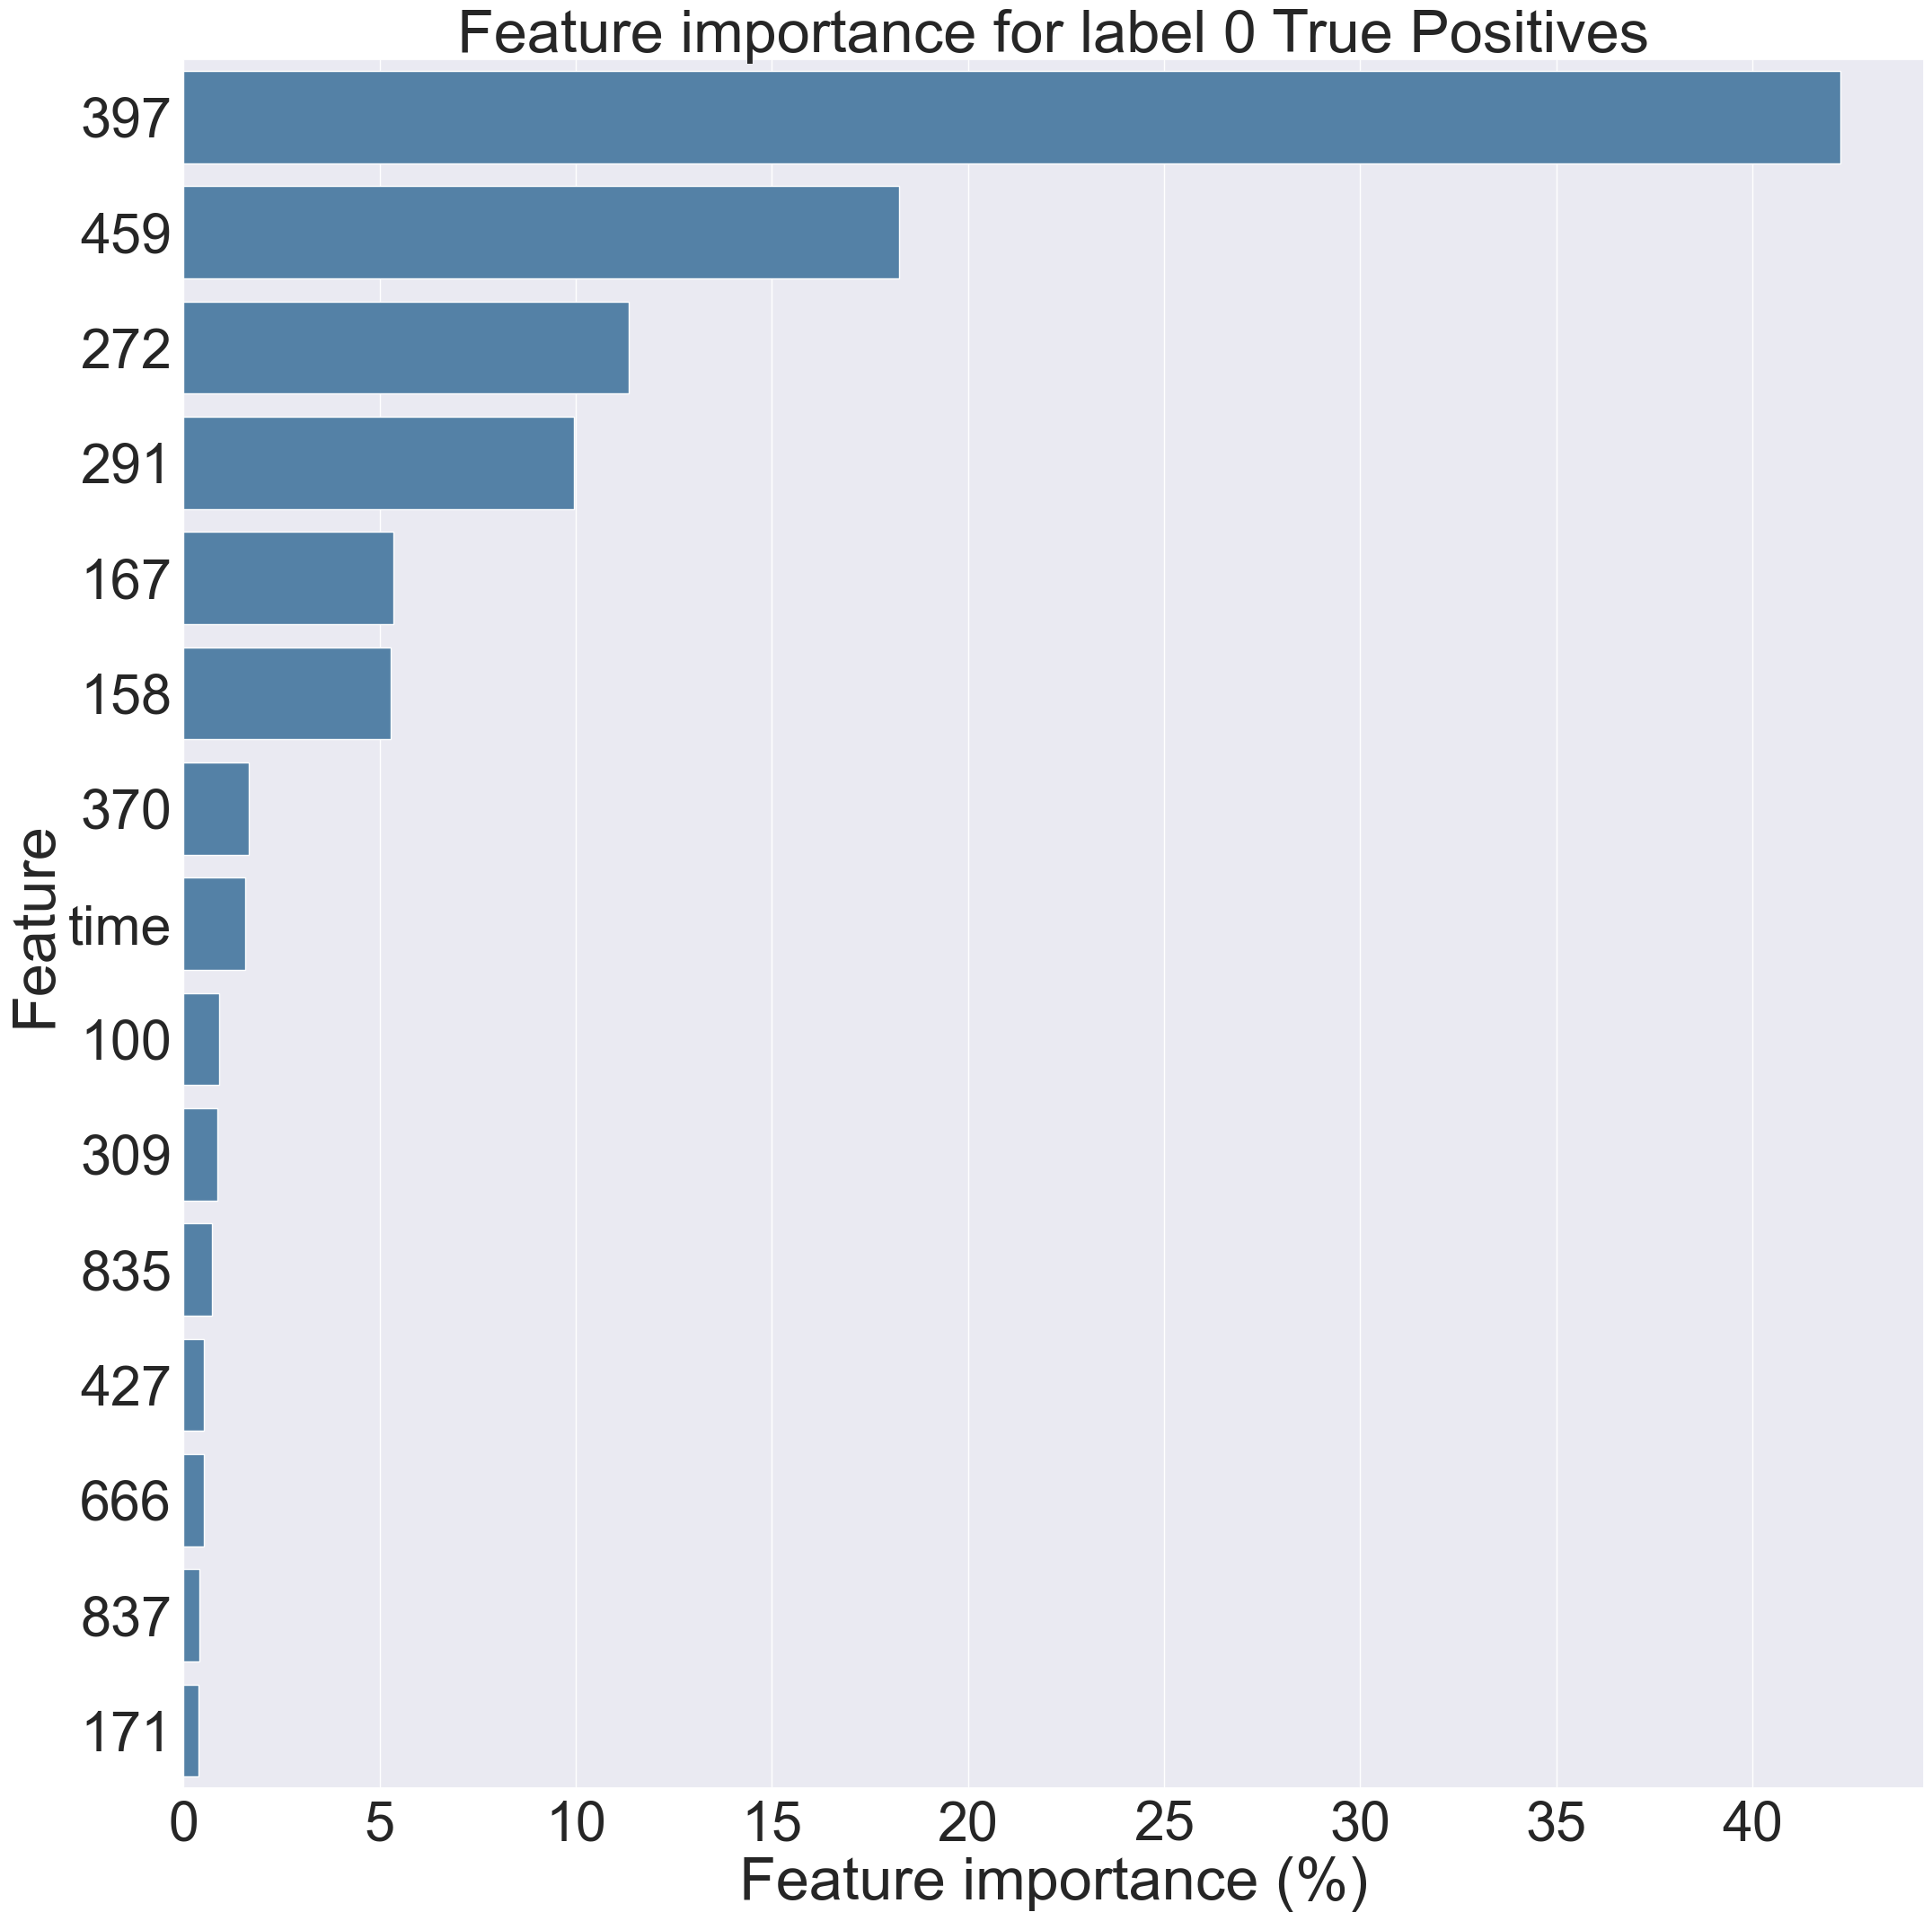

In [257]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label} True Positives')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

### False positive

In [97]:
label = 0

In [98]:
x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_tp_or_fp_label_from_loader(train_loader, label, tp=False) 

tensor([ 89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106])
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  98,  99,
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121], device='cuda:0')
[ 98  99 100 101 102 103 104 105 106]


In [99]:
# test_idx = pd.Series(y_test.argmax(dim=-1).view(-1).numpy())
# test_idx = test_idx[test_idx == label].index.values.tolist()
x_test.shape

torch.Size([9, 200, 106])

In [100]:
explanation = get_lime_explanations(x_train, y_train, x_test[:10].numpy(), feature_names, ['0','1','2','3','4'], model)

In [101]:
explanation

In [102]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [103]:
feature_importance

feature timestamp         value
0      feature_30       t-0  1.444954e-03
1      feature_99       t-0  1.383622e-03
2      feature_66       t-0  1.379447e-03
3      feature_93       t-0  1.121977e-03
4      feature_99       t-1  1.098349e-03
...           ...       ...           ...
21195  feature_43     t-179 -1.482595e-08
21196  feature_22     t-106  9.562606e-09
21197  feature_27     t-118  5.924933e-09
21198  feature_82     t-191 -2.159470e-09
21199  feature_52     t-171  1.231149e-09

[190800 rows x 3 columns]

In [104]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

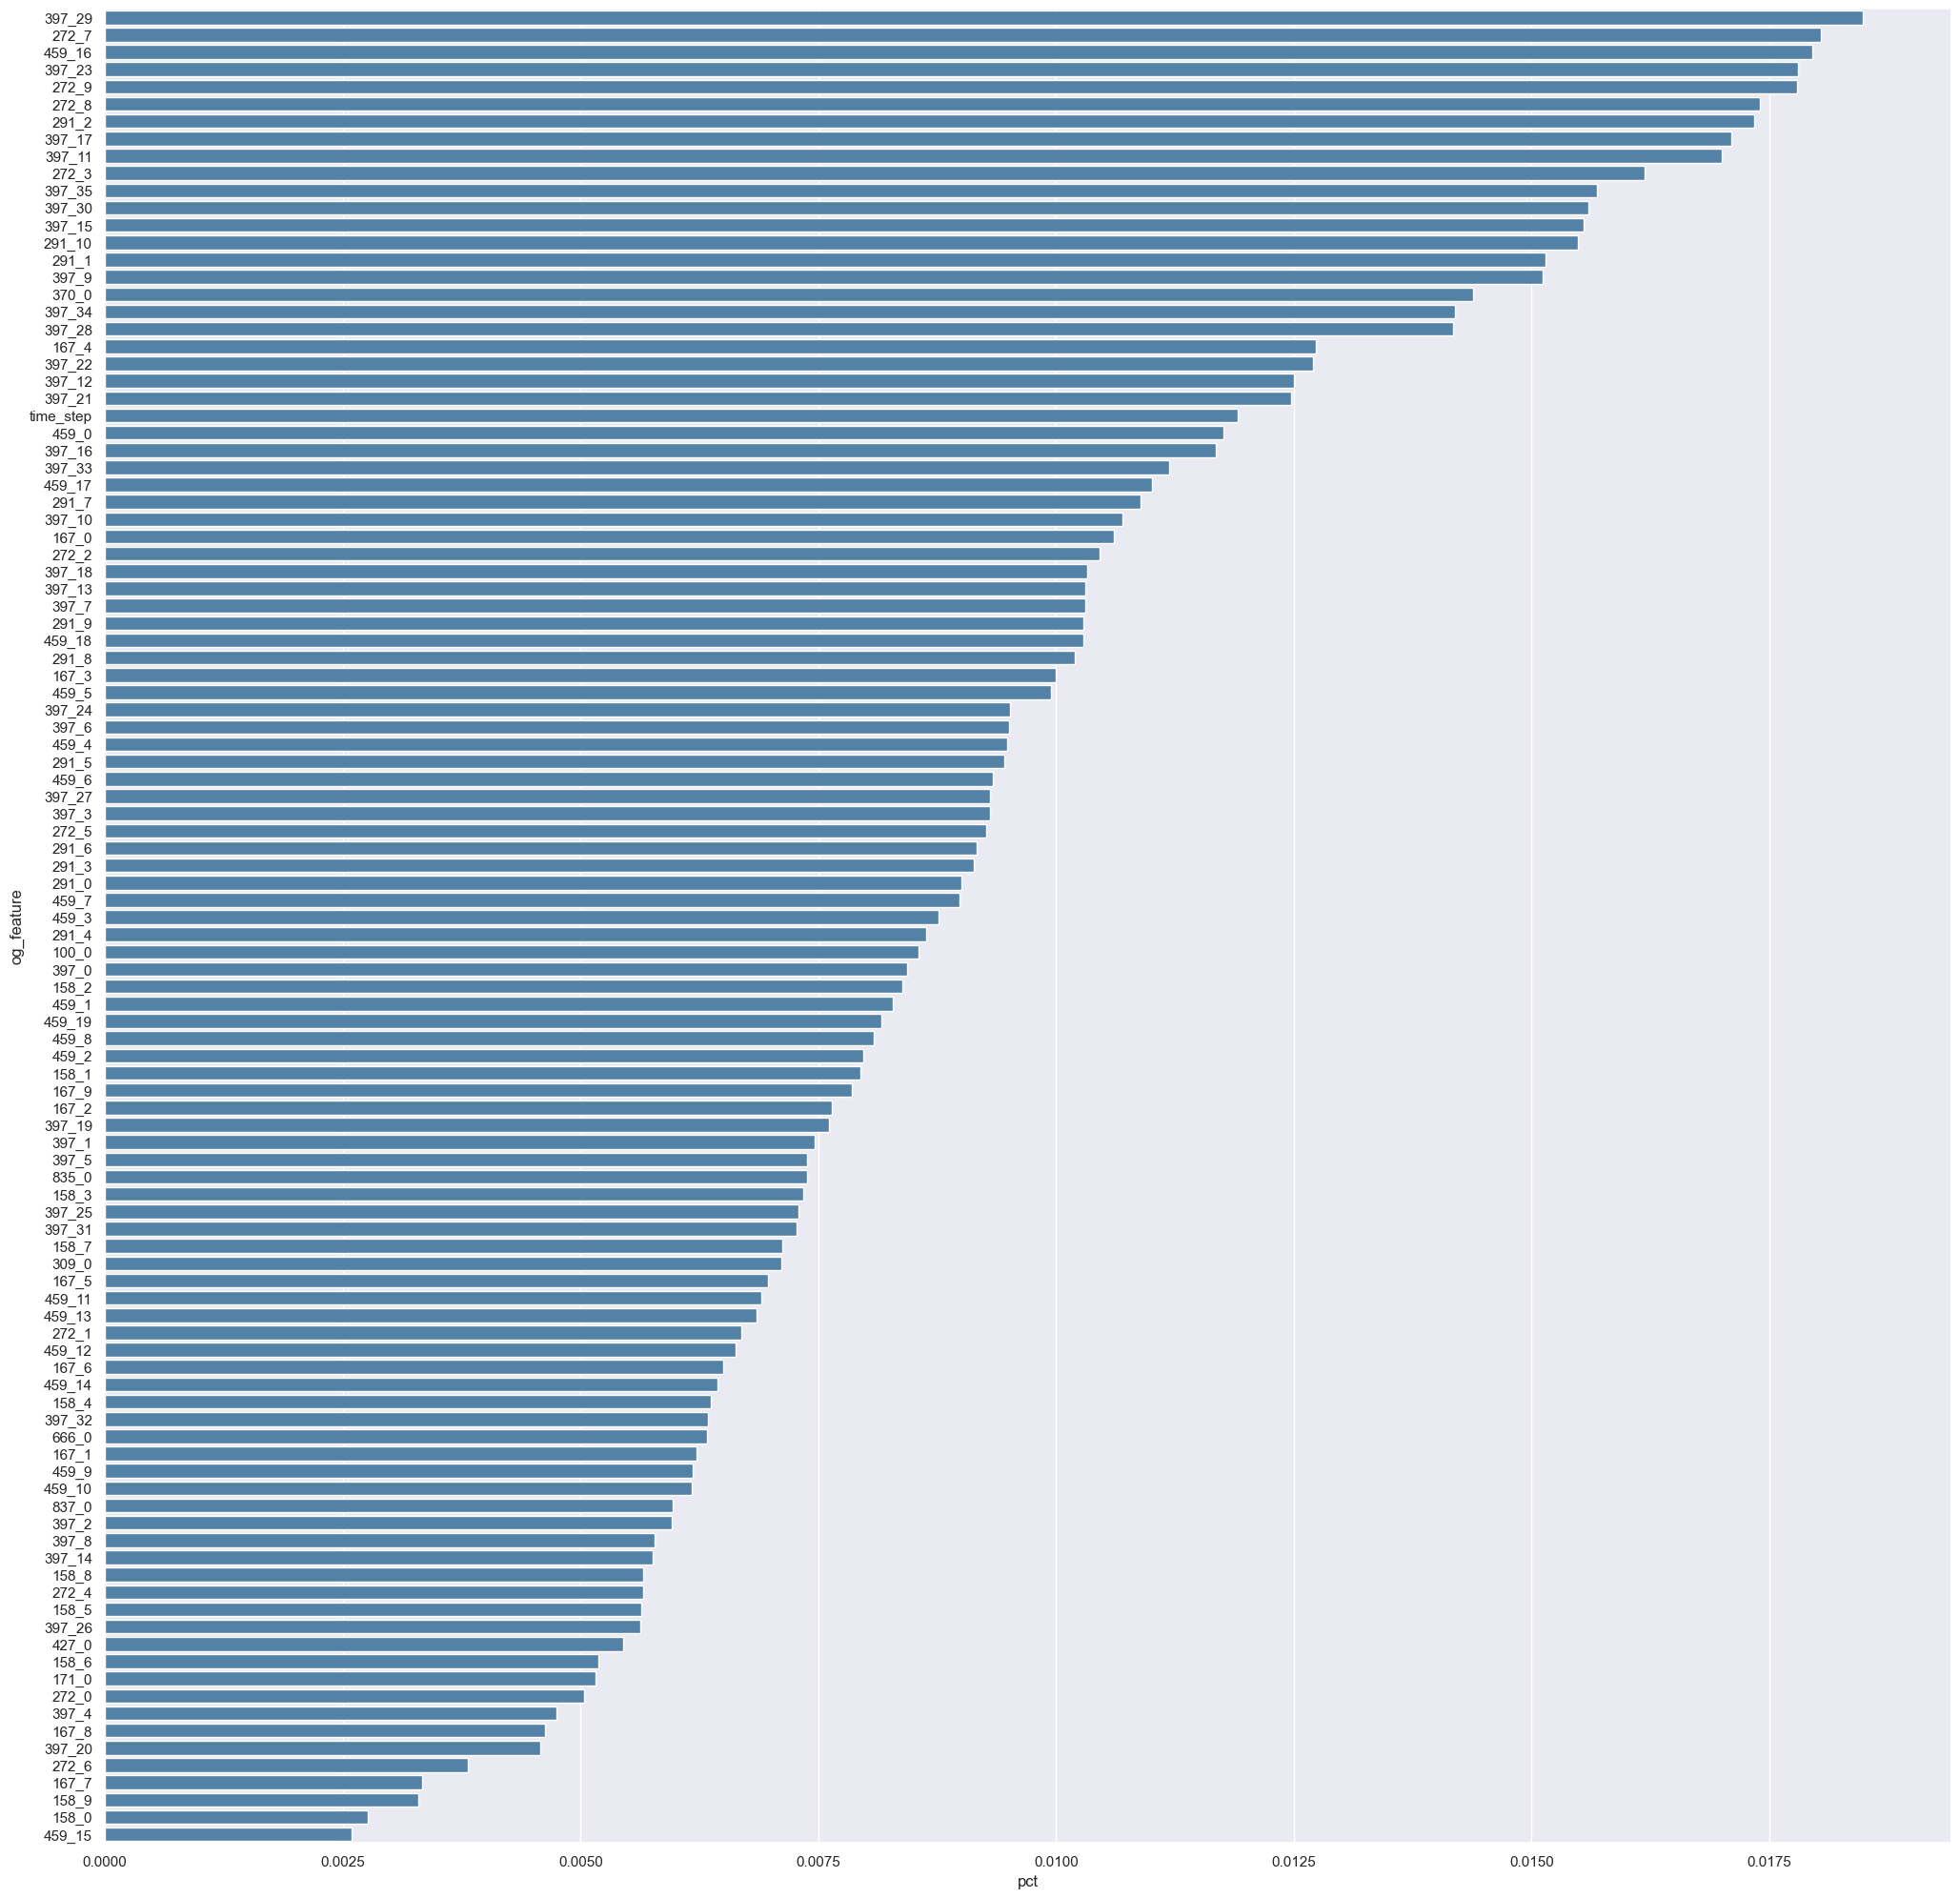

In [105]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum()
plt.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [106]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [107]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').sum().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

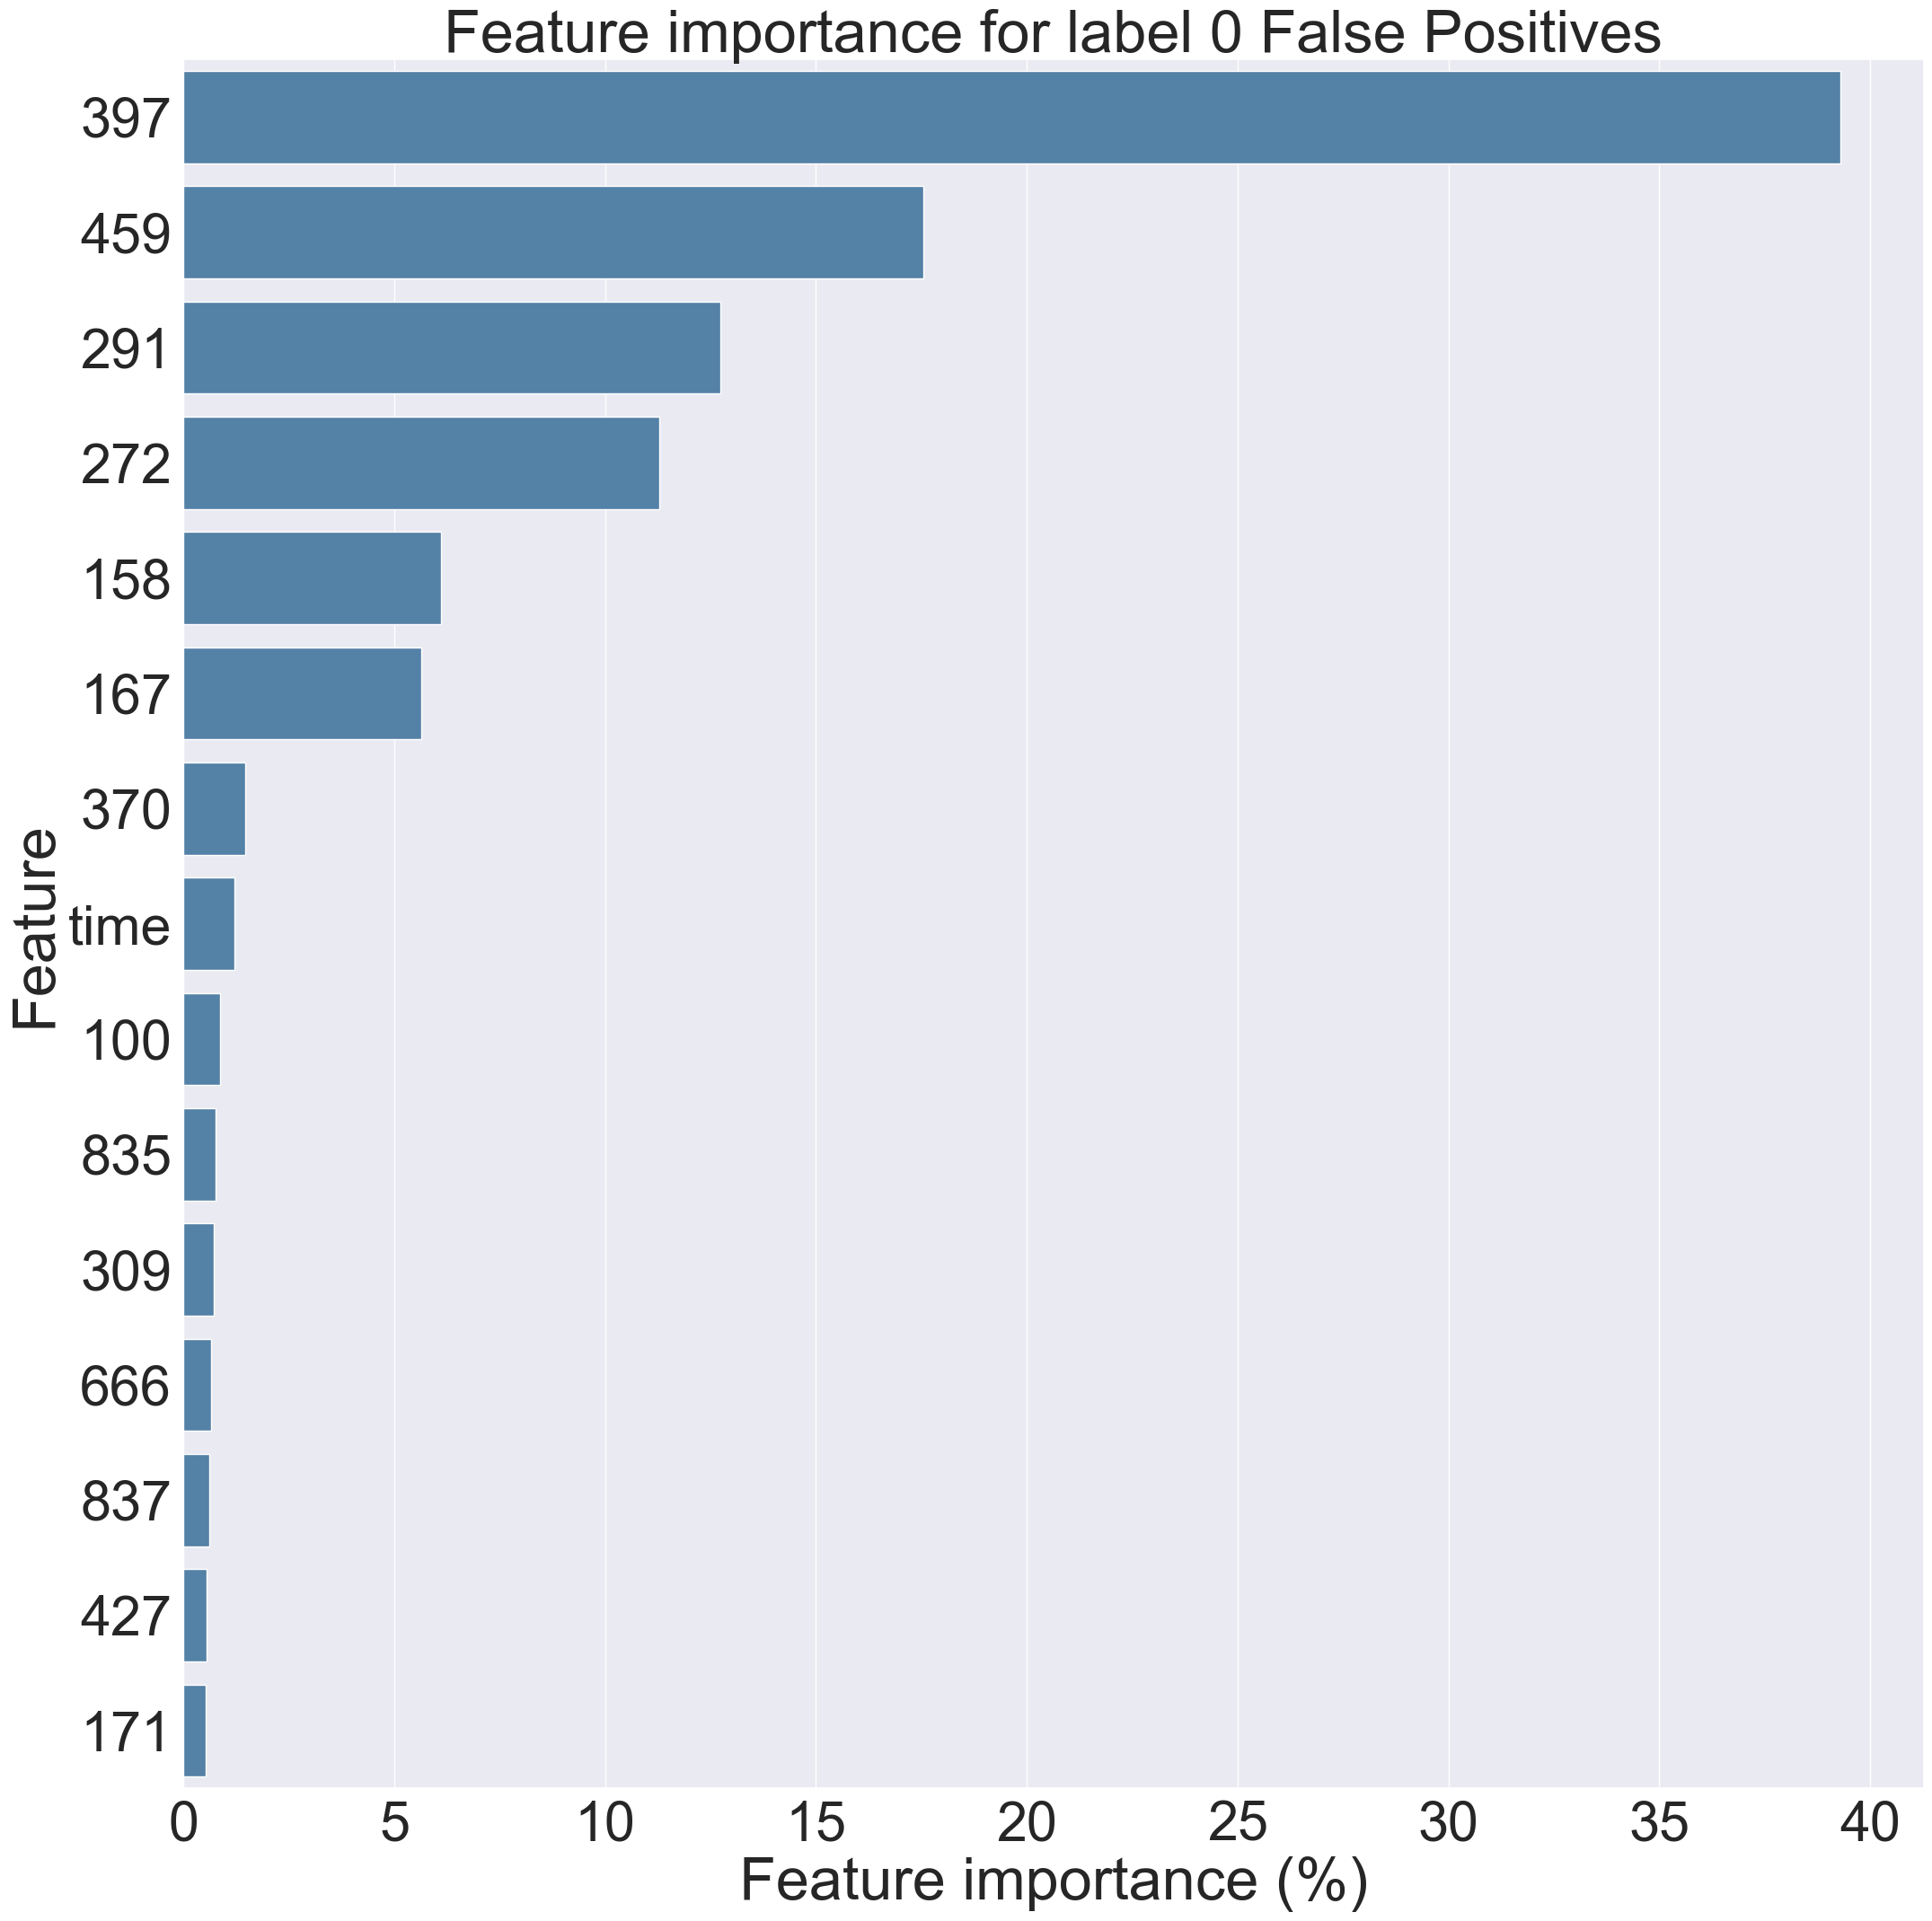

In [108]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label} False Positives')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

## LIME Label 1

### General

In [290]:
label = 1

In [291]:
x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_label_from_loader(valid_loader, label) 

In [292]:
model.eval()
pred = model(x_test.to(model.device))
test_idx = pd.Series(pred.argmax(dim=-1).view(-1).cpu().numpy())
test_idx = test_idx[test_idx == label].index.values.tolist() 


In [ ]:
explanation = get_lime_explanations(x_train, y_train, x_test[test_idx[:10]].numpy(), feature_names, ['0','1','2','3','4'], model)

In [ ]:
explanation

In [ ]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [ ]:
feature_importance

feature timestamp         value
0      feature_36      t-23 -3.844771e-04
1      feature_94      t-23 -3.596448e-04
2      feature_78      t-23 -3.568961e-04
3       feature_2      t-21 -3.552844e-04
4       feature_3      t-20 -3.474473e-04
...           ...       ...           ...
21195  feature_89     t-106  1.411831e-08
21196  feature_61     t-173 -1.026484e-08
21197  feature_74     t-184 -6.757710e-09
21198  feature_49     t-183  5.565887e-09
21199  feature_11     t-152  1.568124e-09

[148400 rows x 3 columns]

In [ ]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

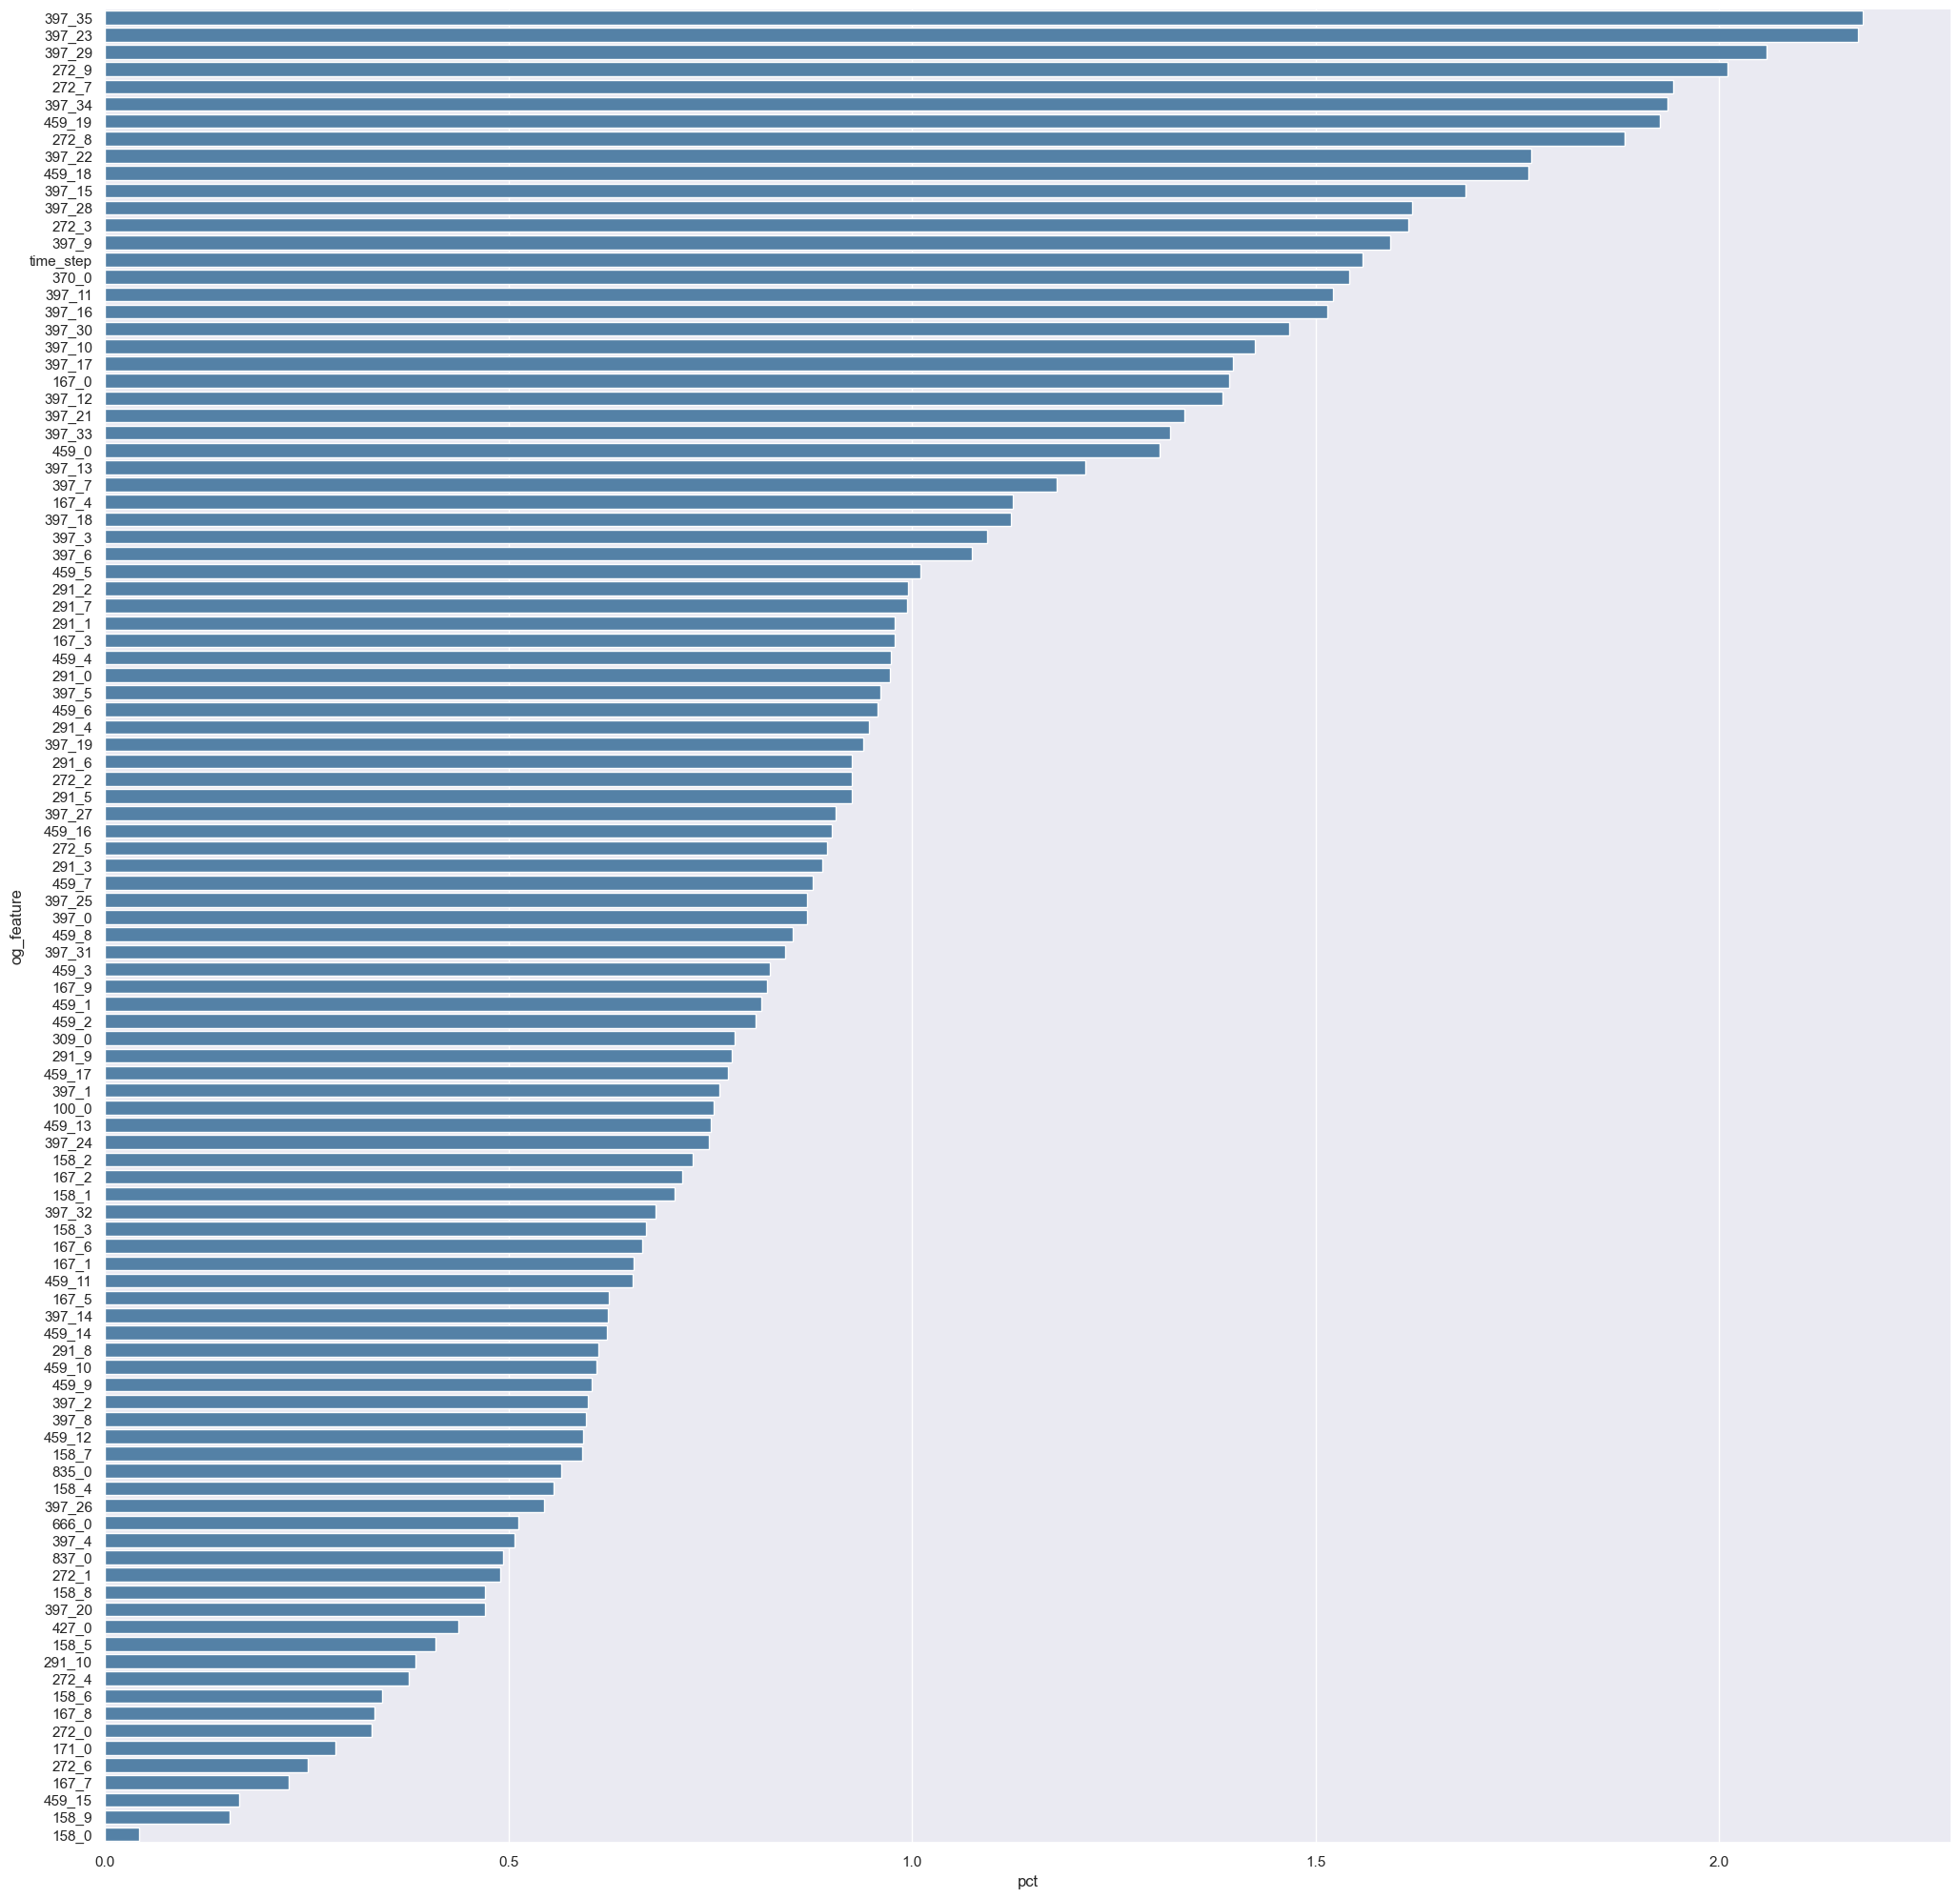

In [ ]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
plt.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [ ]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [ ]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').mean().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

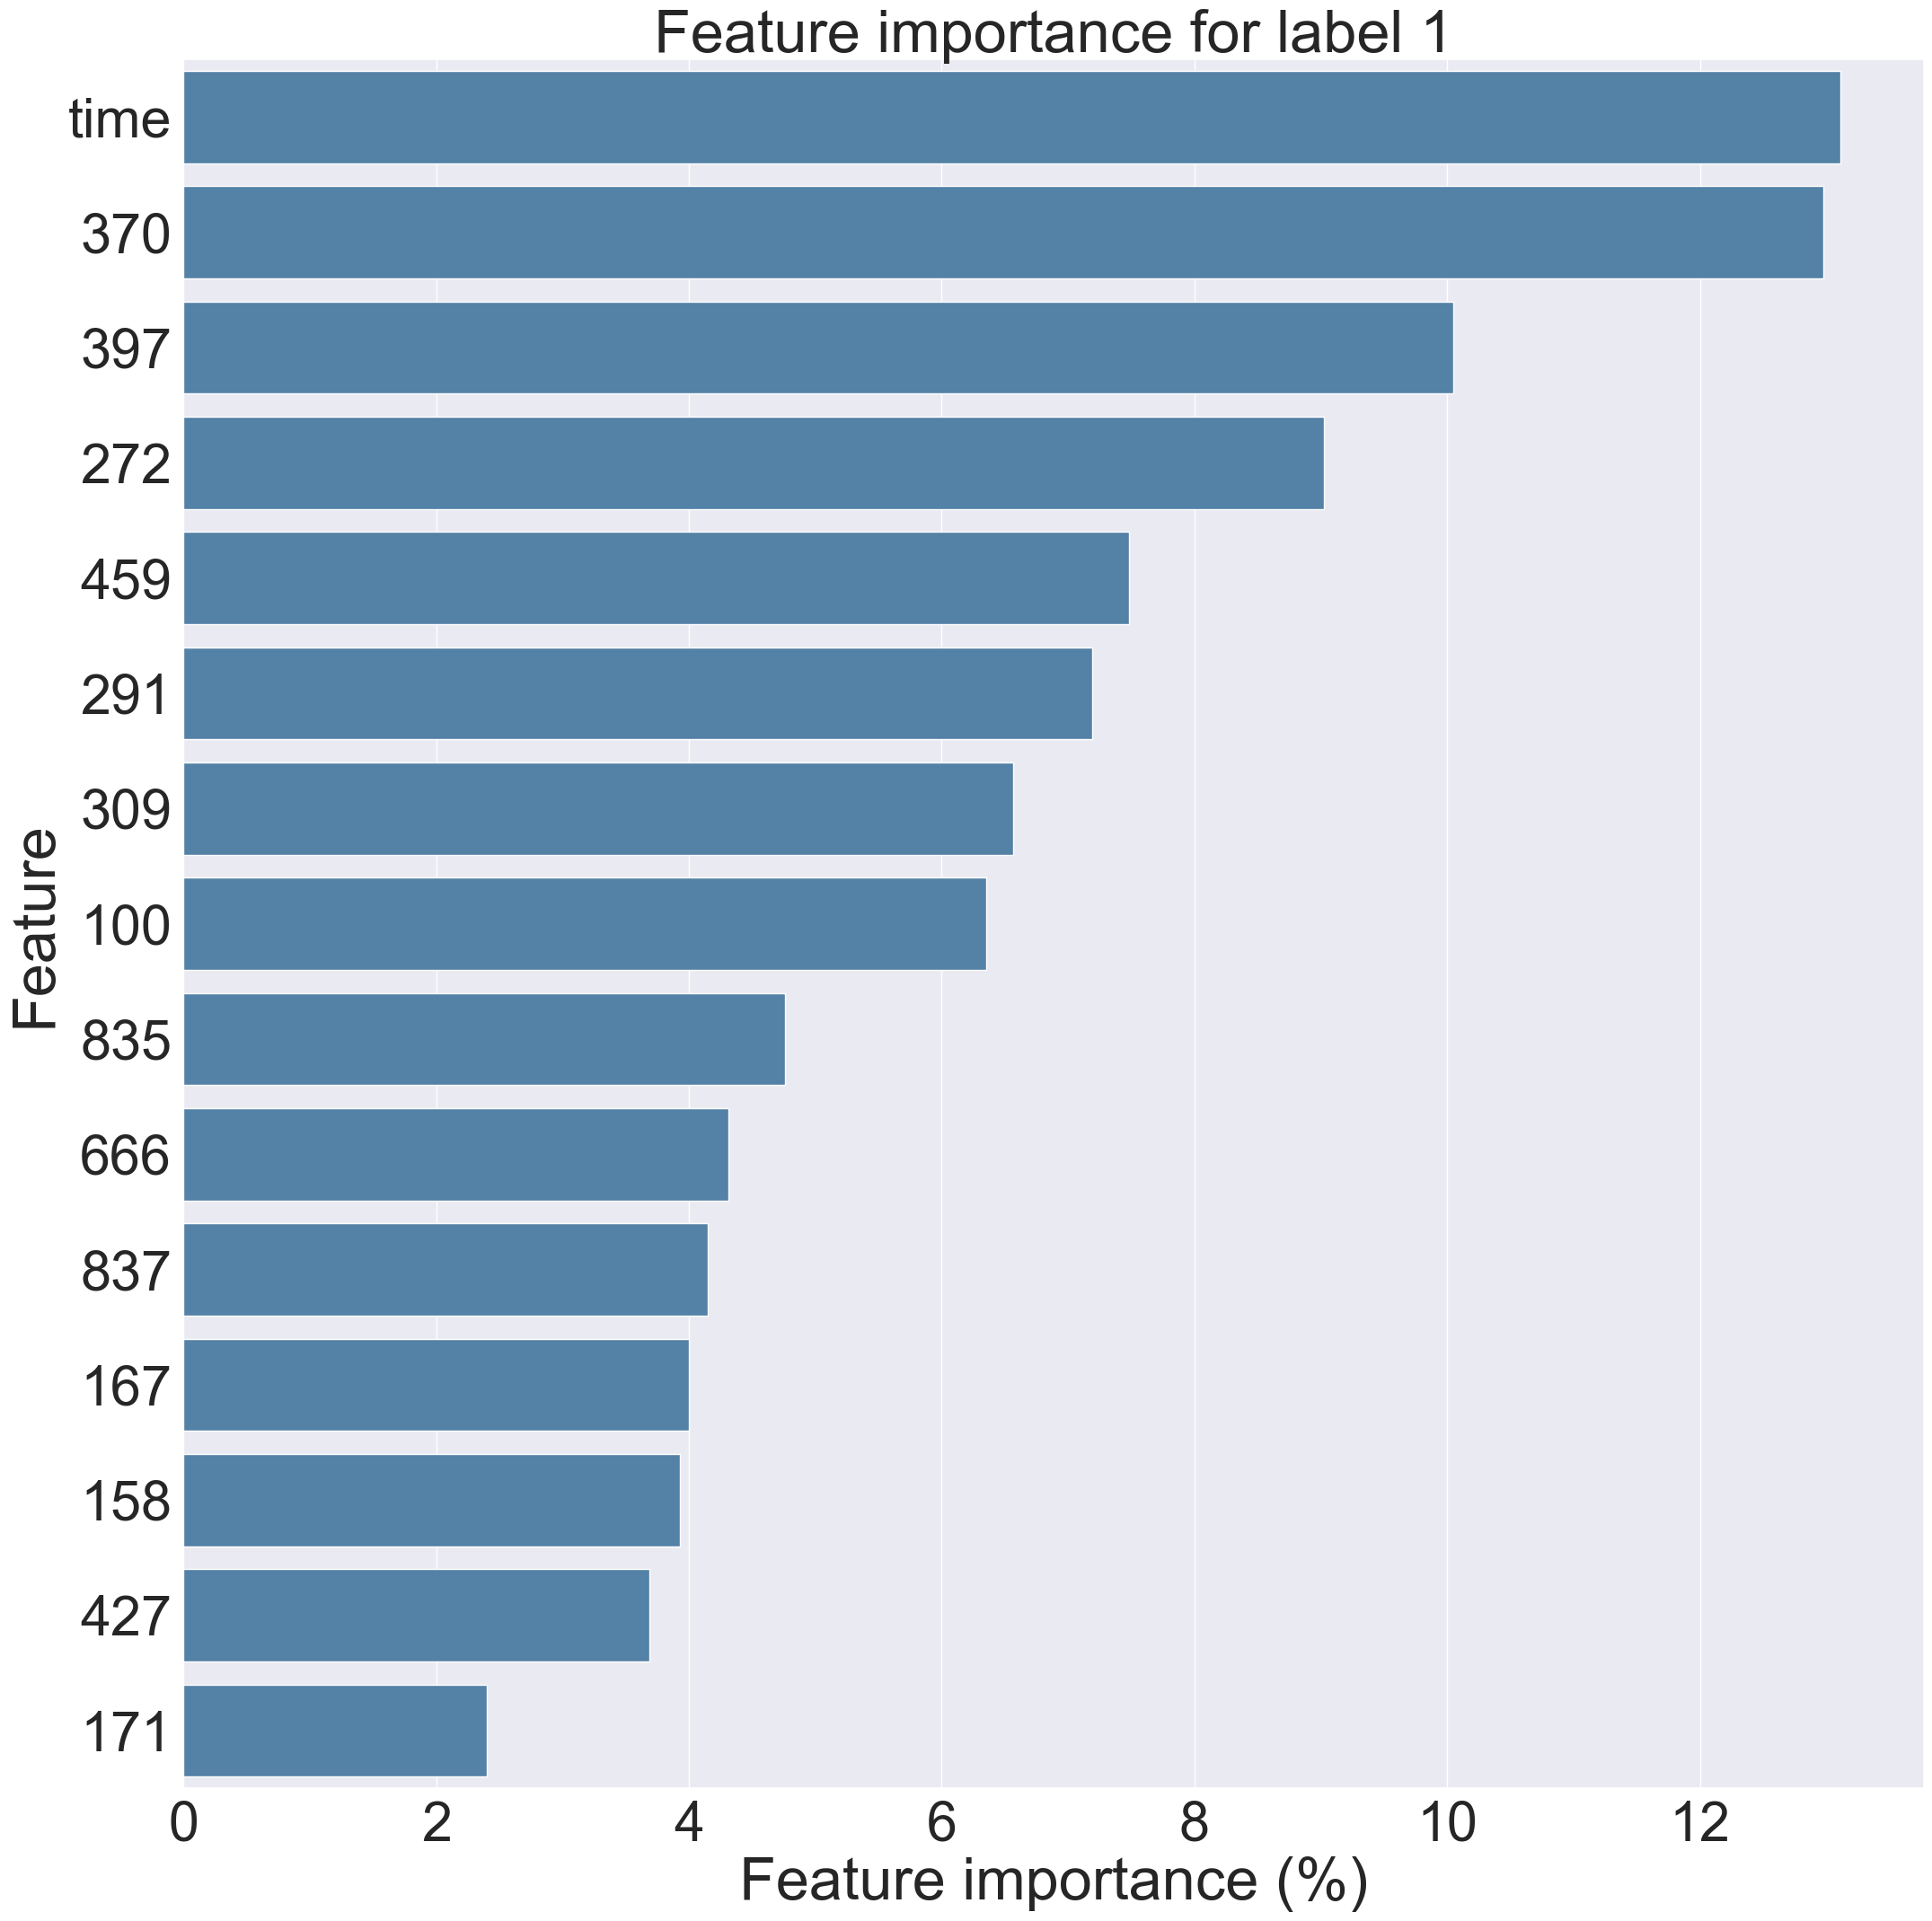

In [ ]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label}')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

### True positives

In [266]:
label = 1

In [267]:
x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_tp_or_fp_label_from_loader(train_loader, label, tp=True) 

tensor([ 91,  92,  93,  94,  95,  96, 114, 115])
tensor([ 47,  48, 114, 125, 172, 173, 224, 225, 226, 227, 228, 229, 230, 231],
       device='cuda:0')
[114]


In [268]:
# test_idx = pd.Series(y_test.argmax(dim=-1).view(-1).numpy())
# test_idx = test_idx[test_idx == label].index.values.tolist()
x_test.shape

torch.Size([1, 200, 106])

In [269]:
explanation = get_lime_explanations(x_train, y_train, x_test[:10].numpy(), feature_names, ['0','1','2','3','4'], model)

In [270]:
explanation

In [271]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [272]:
feature_importance

feature timestamp         value
0       feature_70      t-11 -5.563574e-04
1       feature_80       t-9 -5.357825e-04
2       feature_18      t-12 -5.155741e-04
3       feature_36       t-9 -5.110973e-04
4      feature_101      t-12 -4.950251e-04
...            ...       ...           ...
21195   feature_38      t-86 -2.971123e-08
21196   feature_75     t-145  2.883297e-08
21197  feature_102     t-181  1.760829e-08
21198   feature_65     t-110  1.466690e-08
21199   feature_91     t-170 -1.297471e-08

[21200 rows x 3 columns]

In [273]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

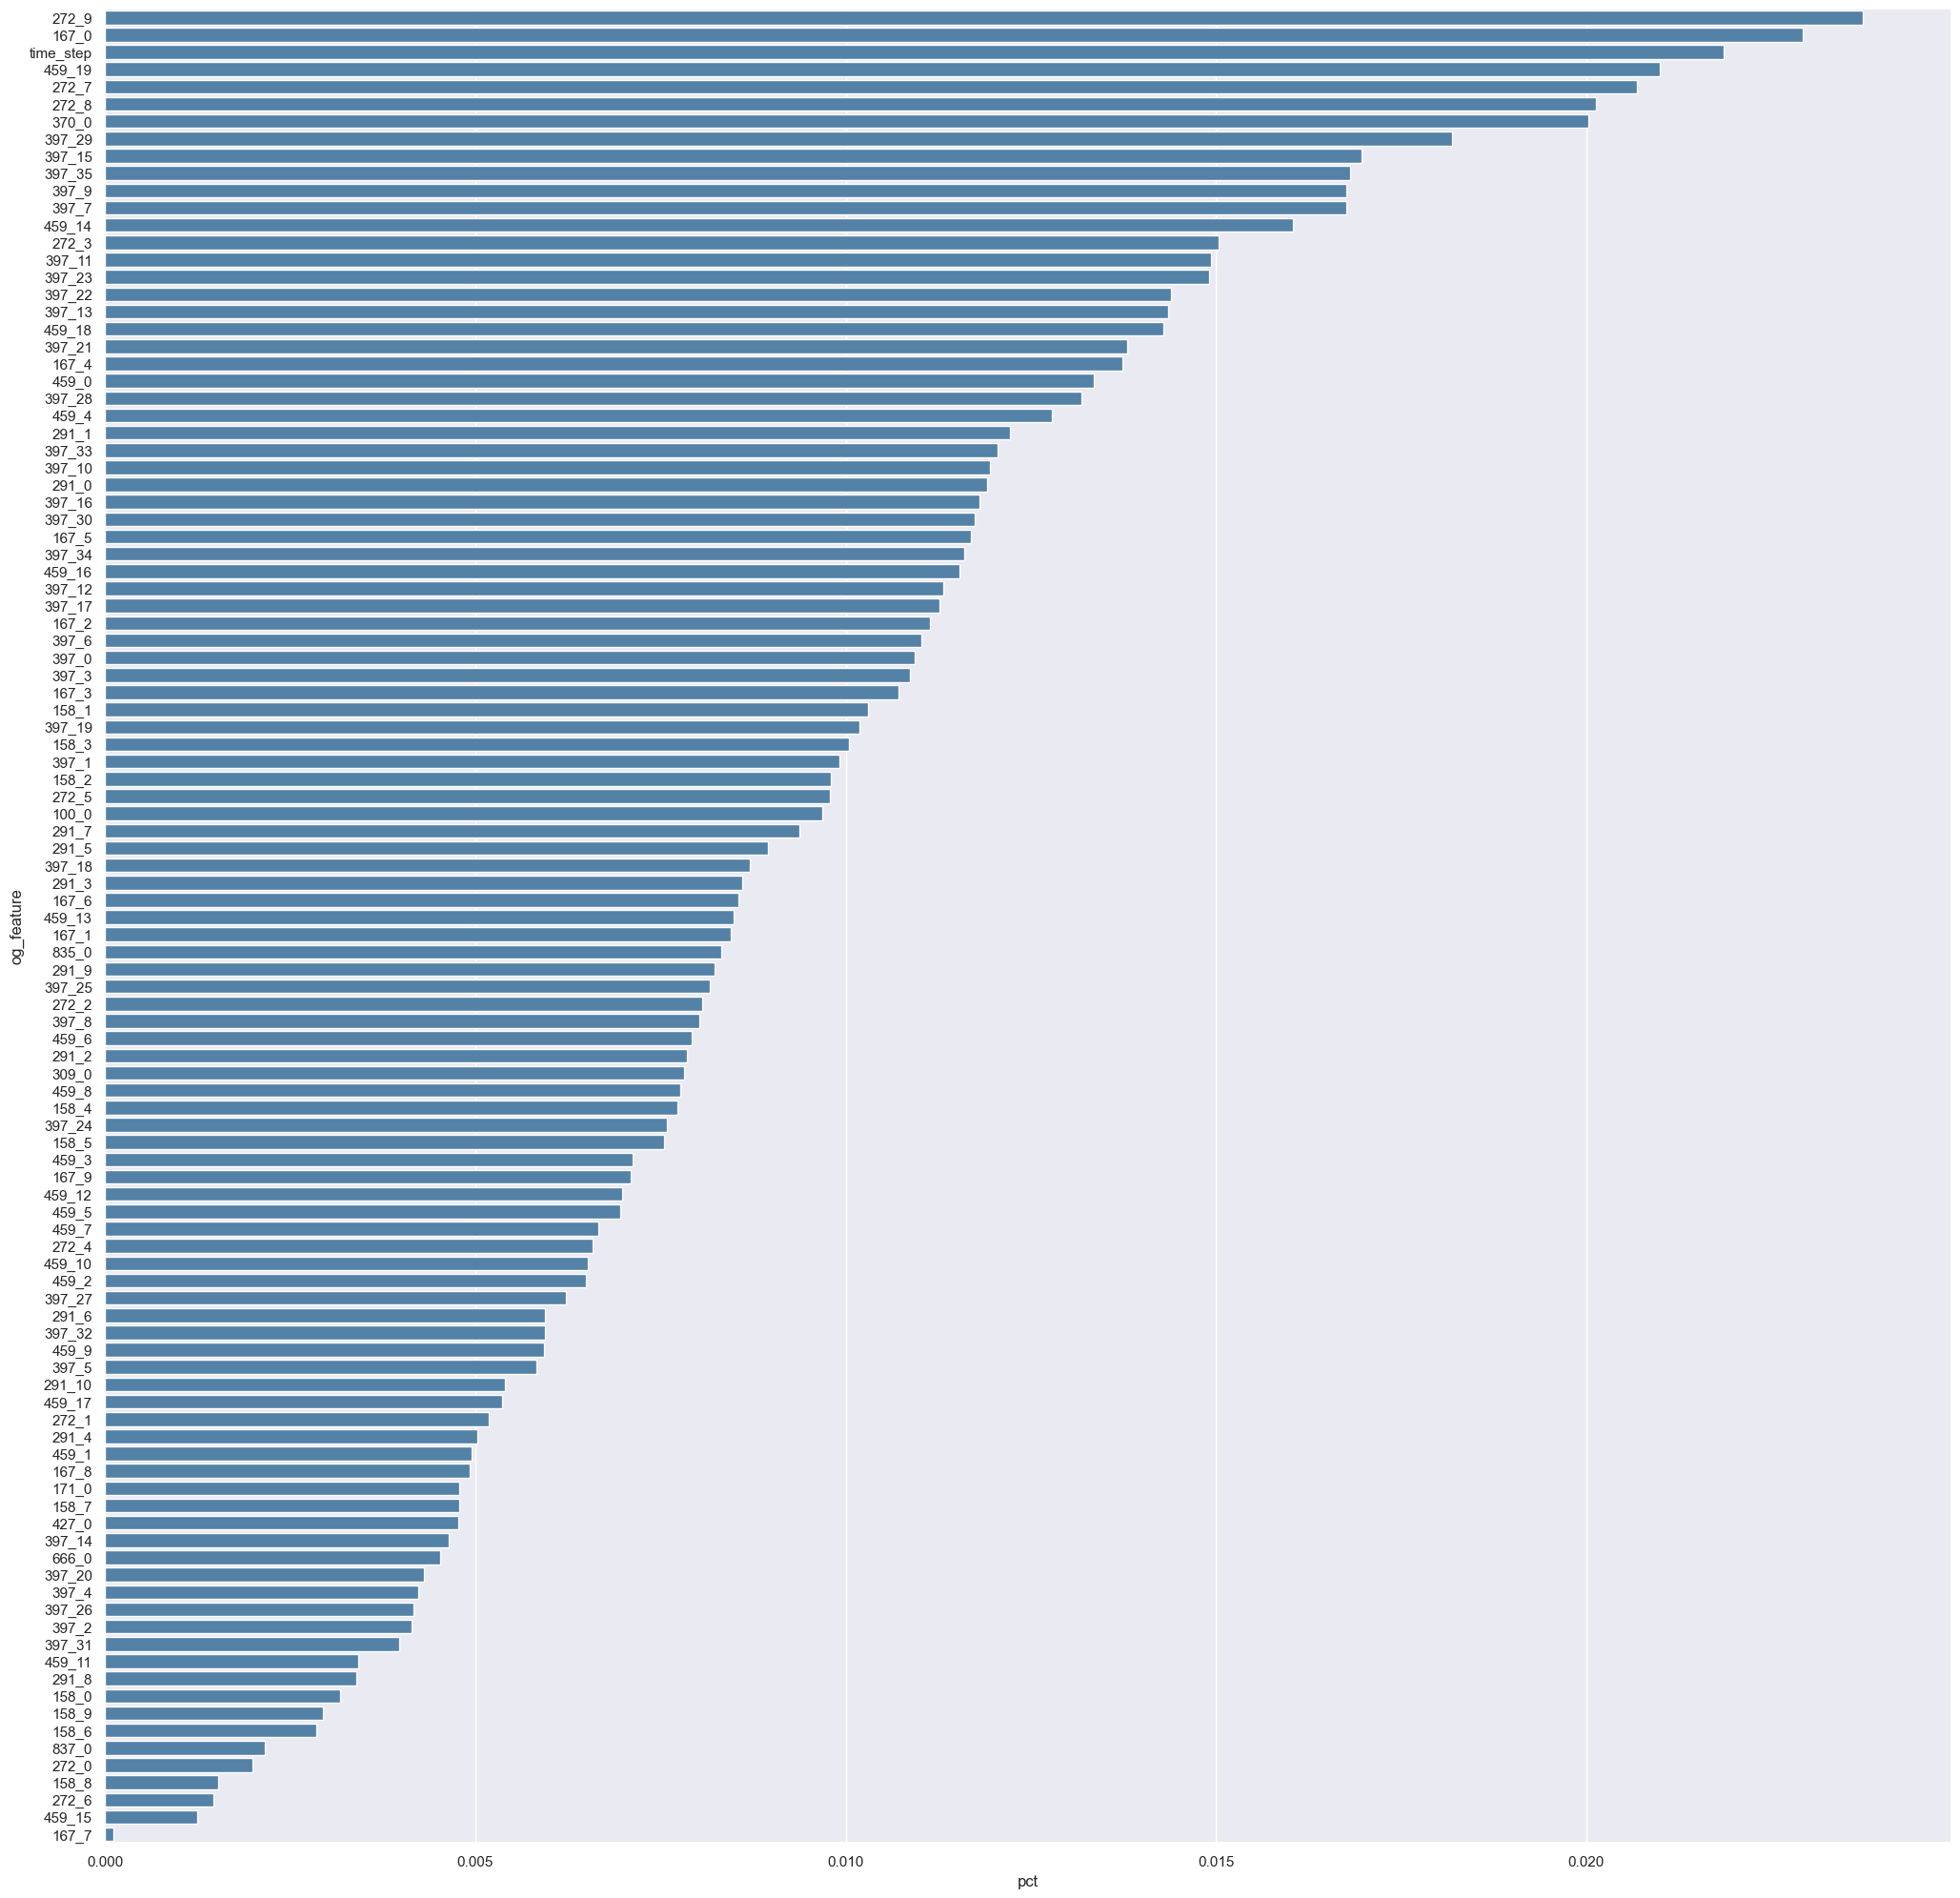

In [274]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum()
plt.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [275]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [276]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').sum().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

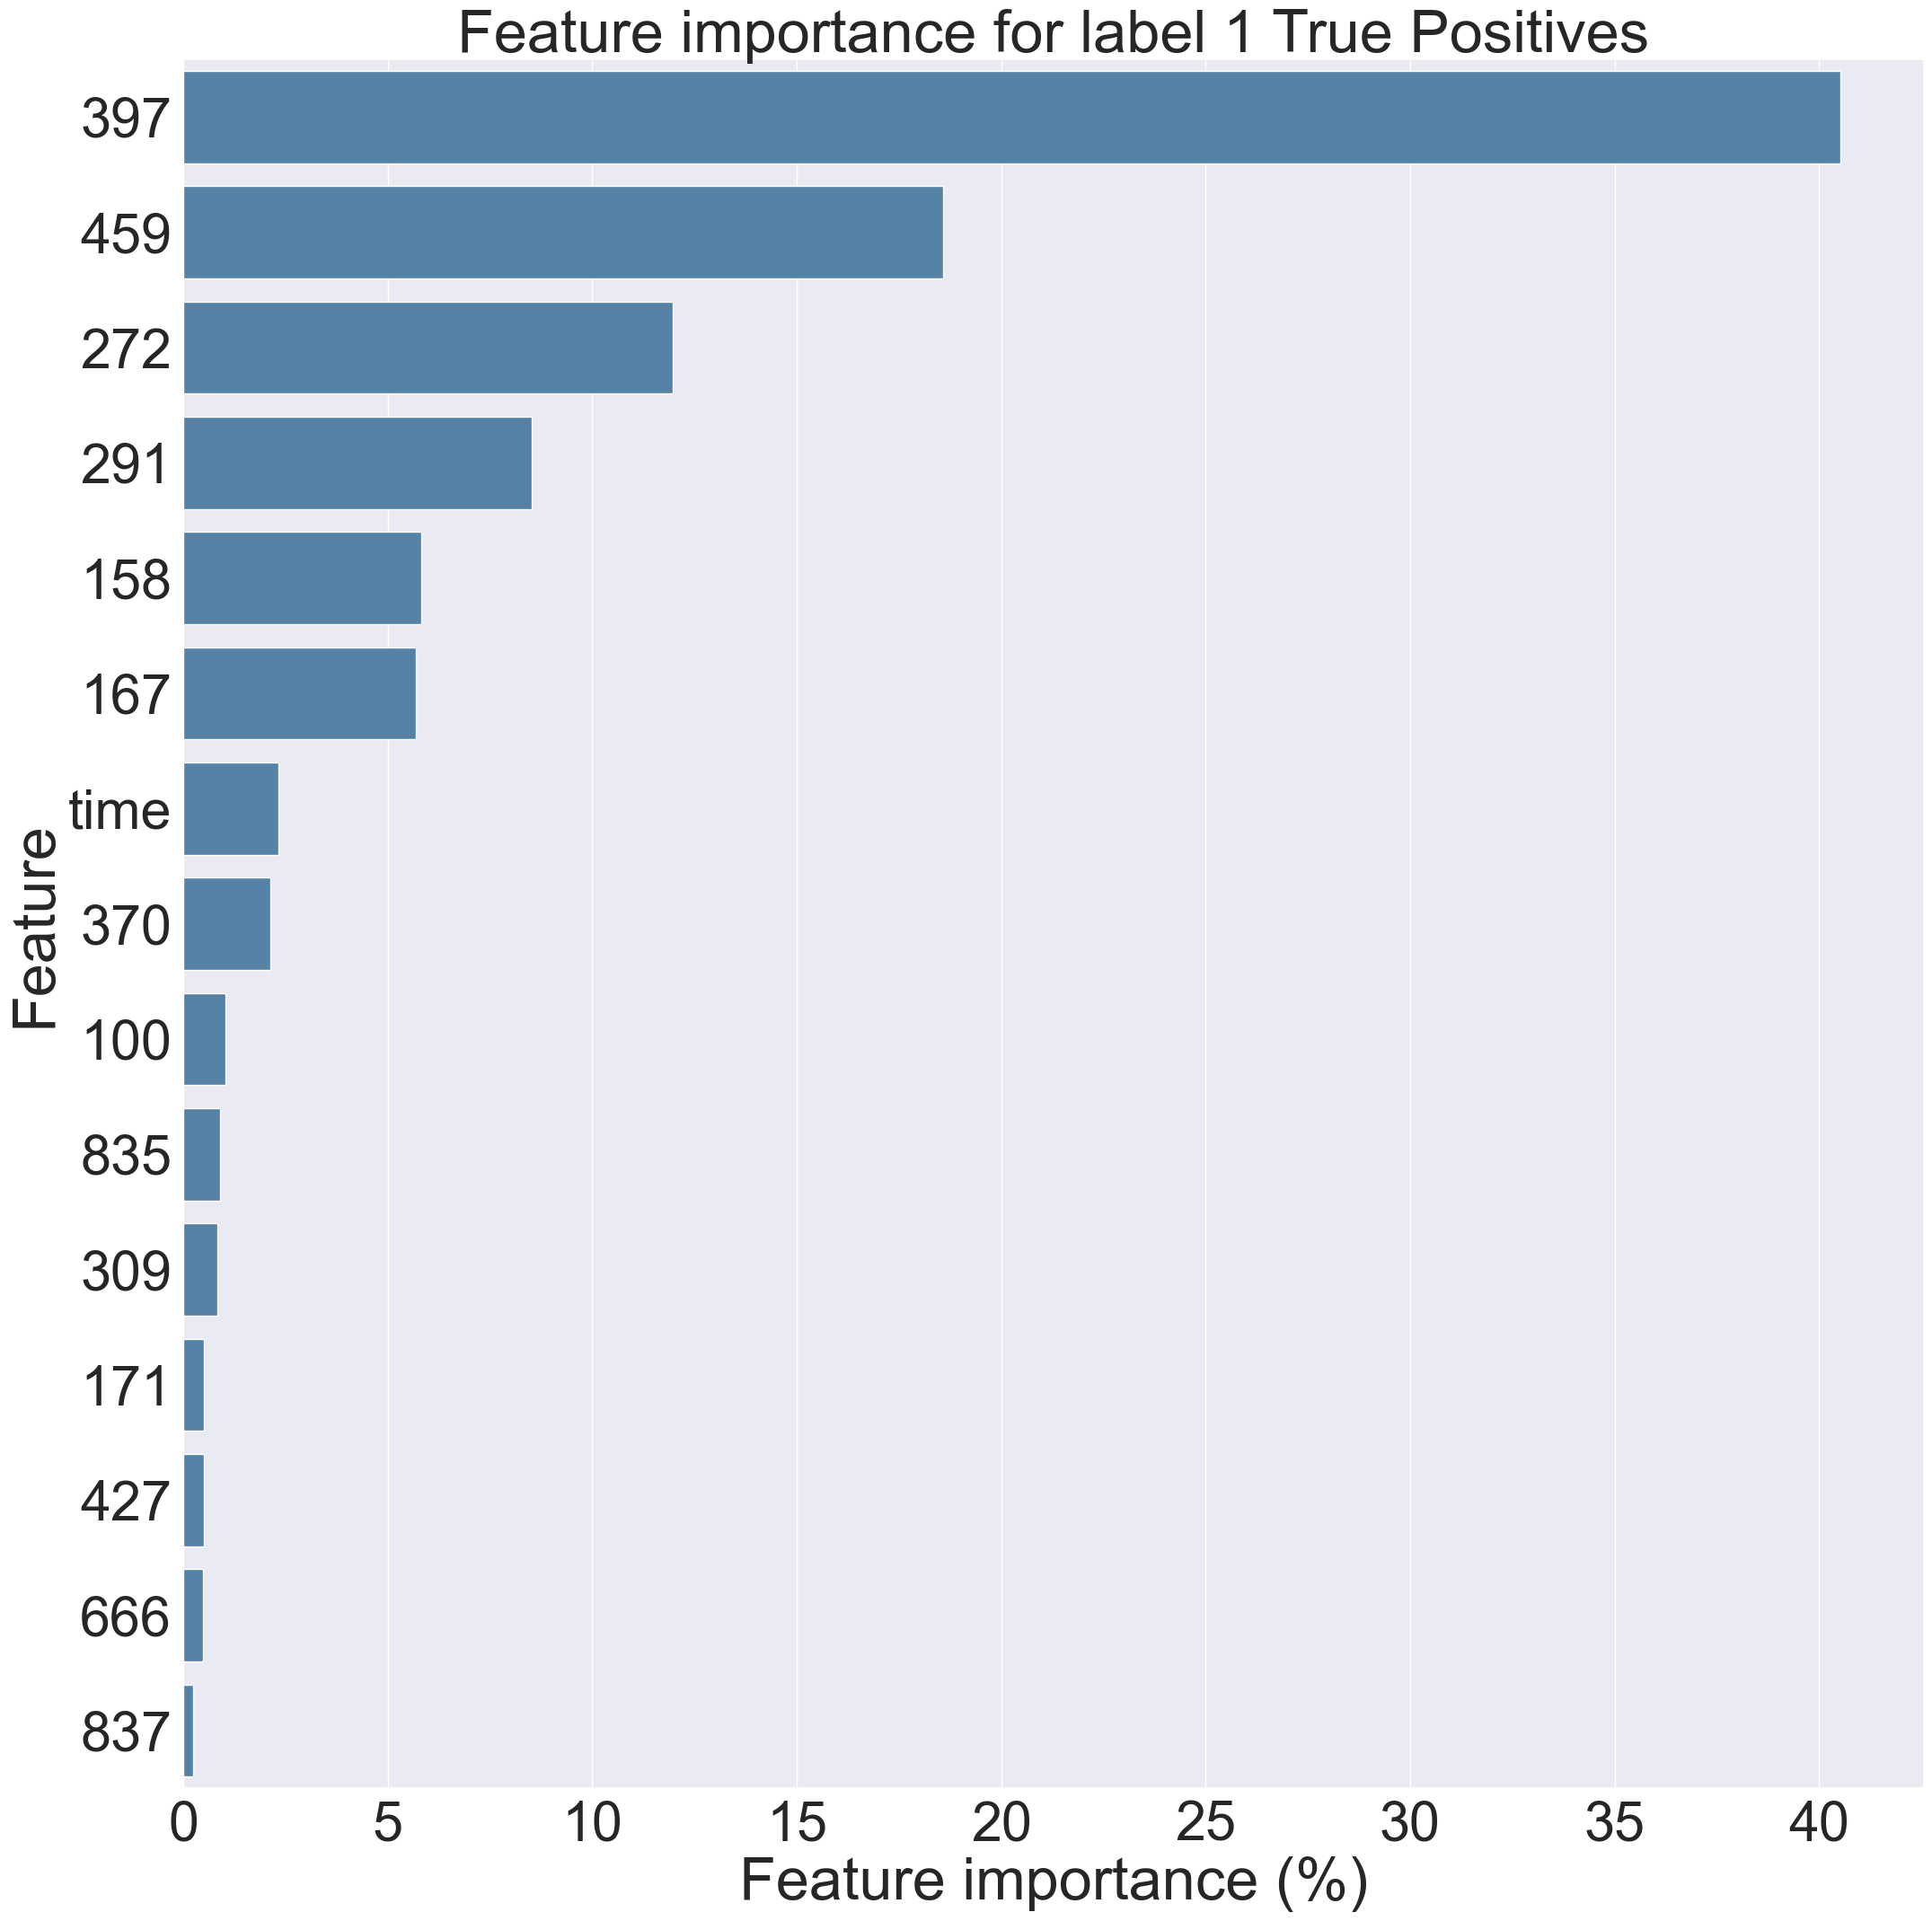

In [277]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label} True Positives')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

### False positive

In [278]:
label = 1

In [279]:
x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_tp_or_fp_label_from_loader(valid_loader, label, tp=False) 

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [280]:
# test_idx = pd.Series(y_test.argmax(dim=-1).view(-1).numpy())
# test_idx = test_idx[test_idx == label].index.values.tolist()
x_test.shape

torch.Size([7, 200, 106])

In [281]:
explanation = get_lime_explanations(x_train, y_train, x_test[:10].numpy(), feature_names, ['0','1','2','3','4'], model)

In [282]:
explanation

In [283]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [284]:
feature_importance

feature timestamp         value
0      feature_36      t-23 -3.844771e-04
1      feature_94      t-23 -3.596448e-04
2      feature_78      t-23 -3.568961e-04
3       feature_2      t-21 -3.552844e-04
4       feature_3      t-20 -3.474473e-04
...           ...       ...           ...
21195  feature_89     t-106  1.411831e-08
21196  feature_61     t-173 -1.026484e-08
21197  feature_74     t-184 -6.757710e-09
21198  feature_49     t-183  5.565887e-09
21199  feature_11     t-152  1.568124e-09

[148400 rows x 3 columns]

In [285]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

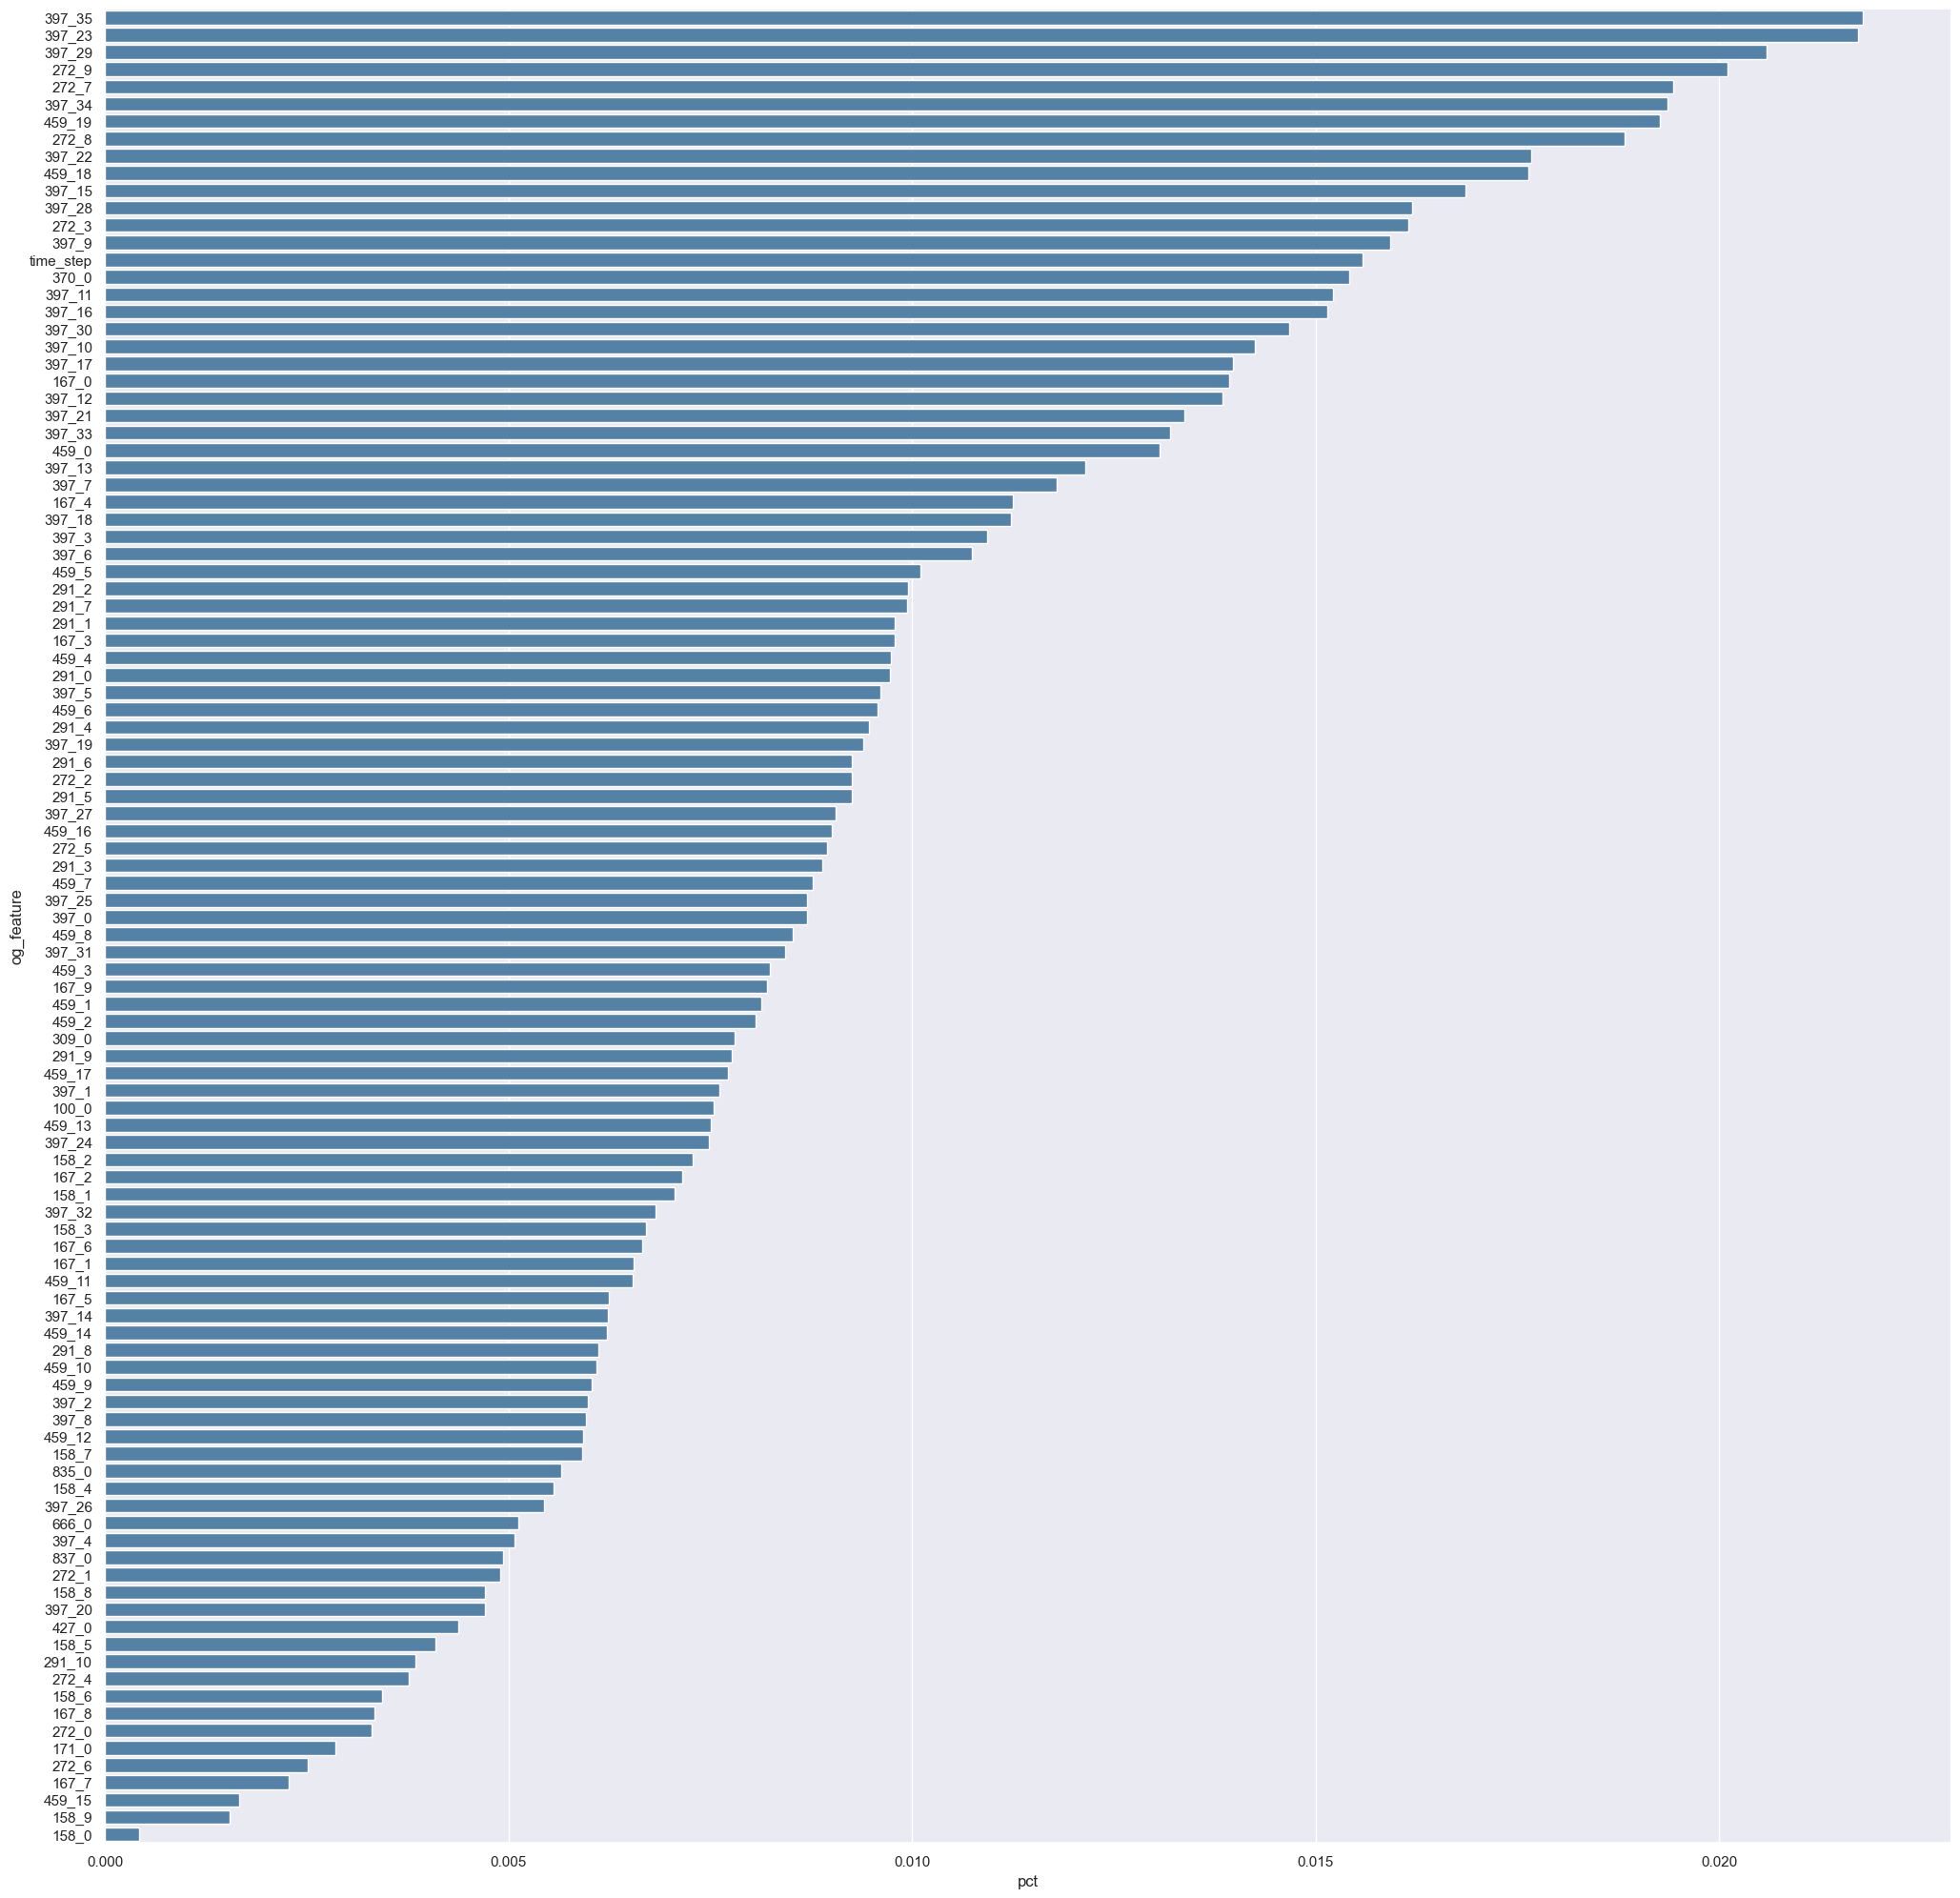

In [286]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum()
plt.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [287]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [288]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').sum().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

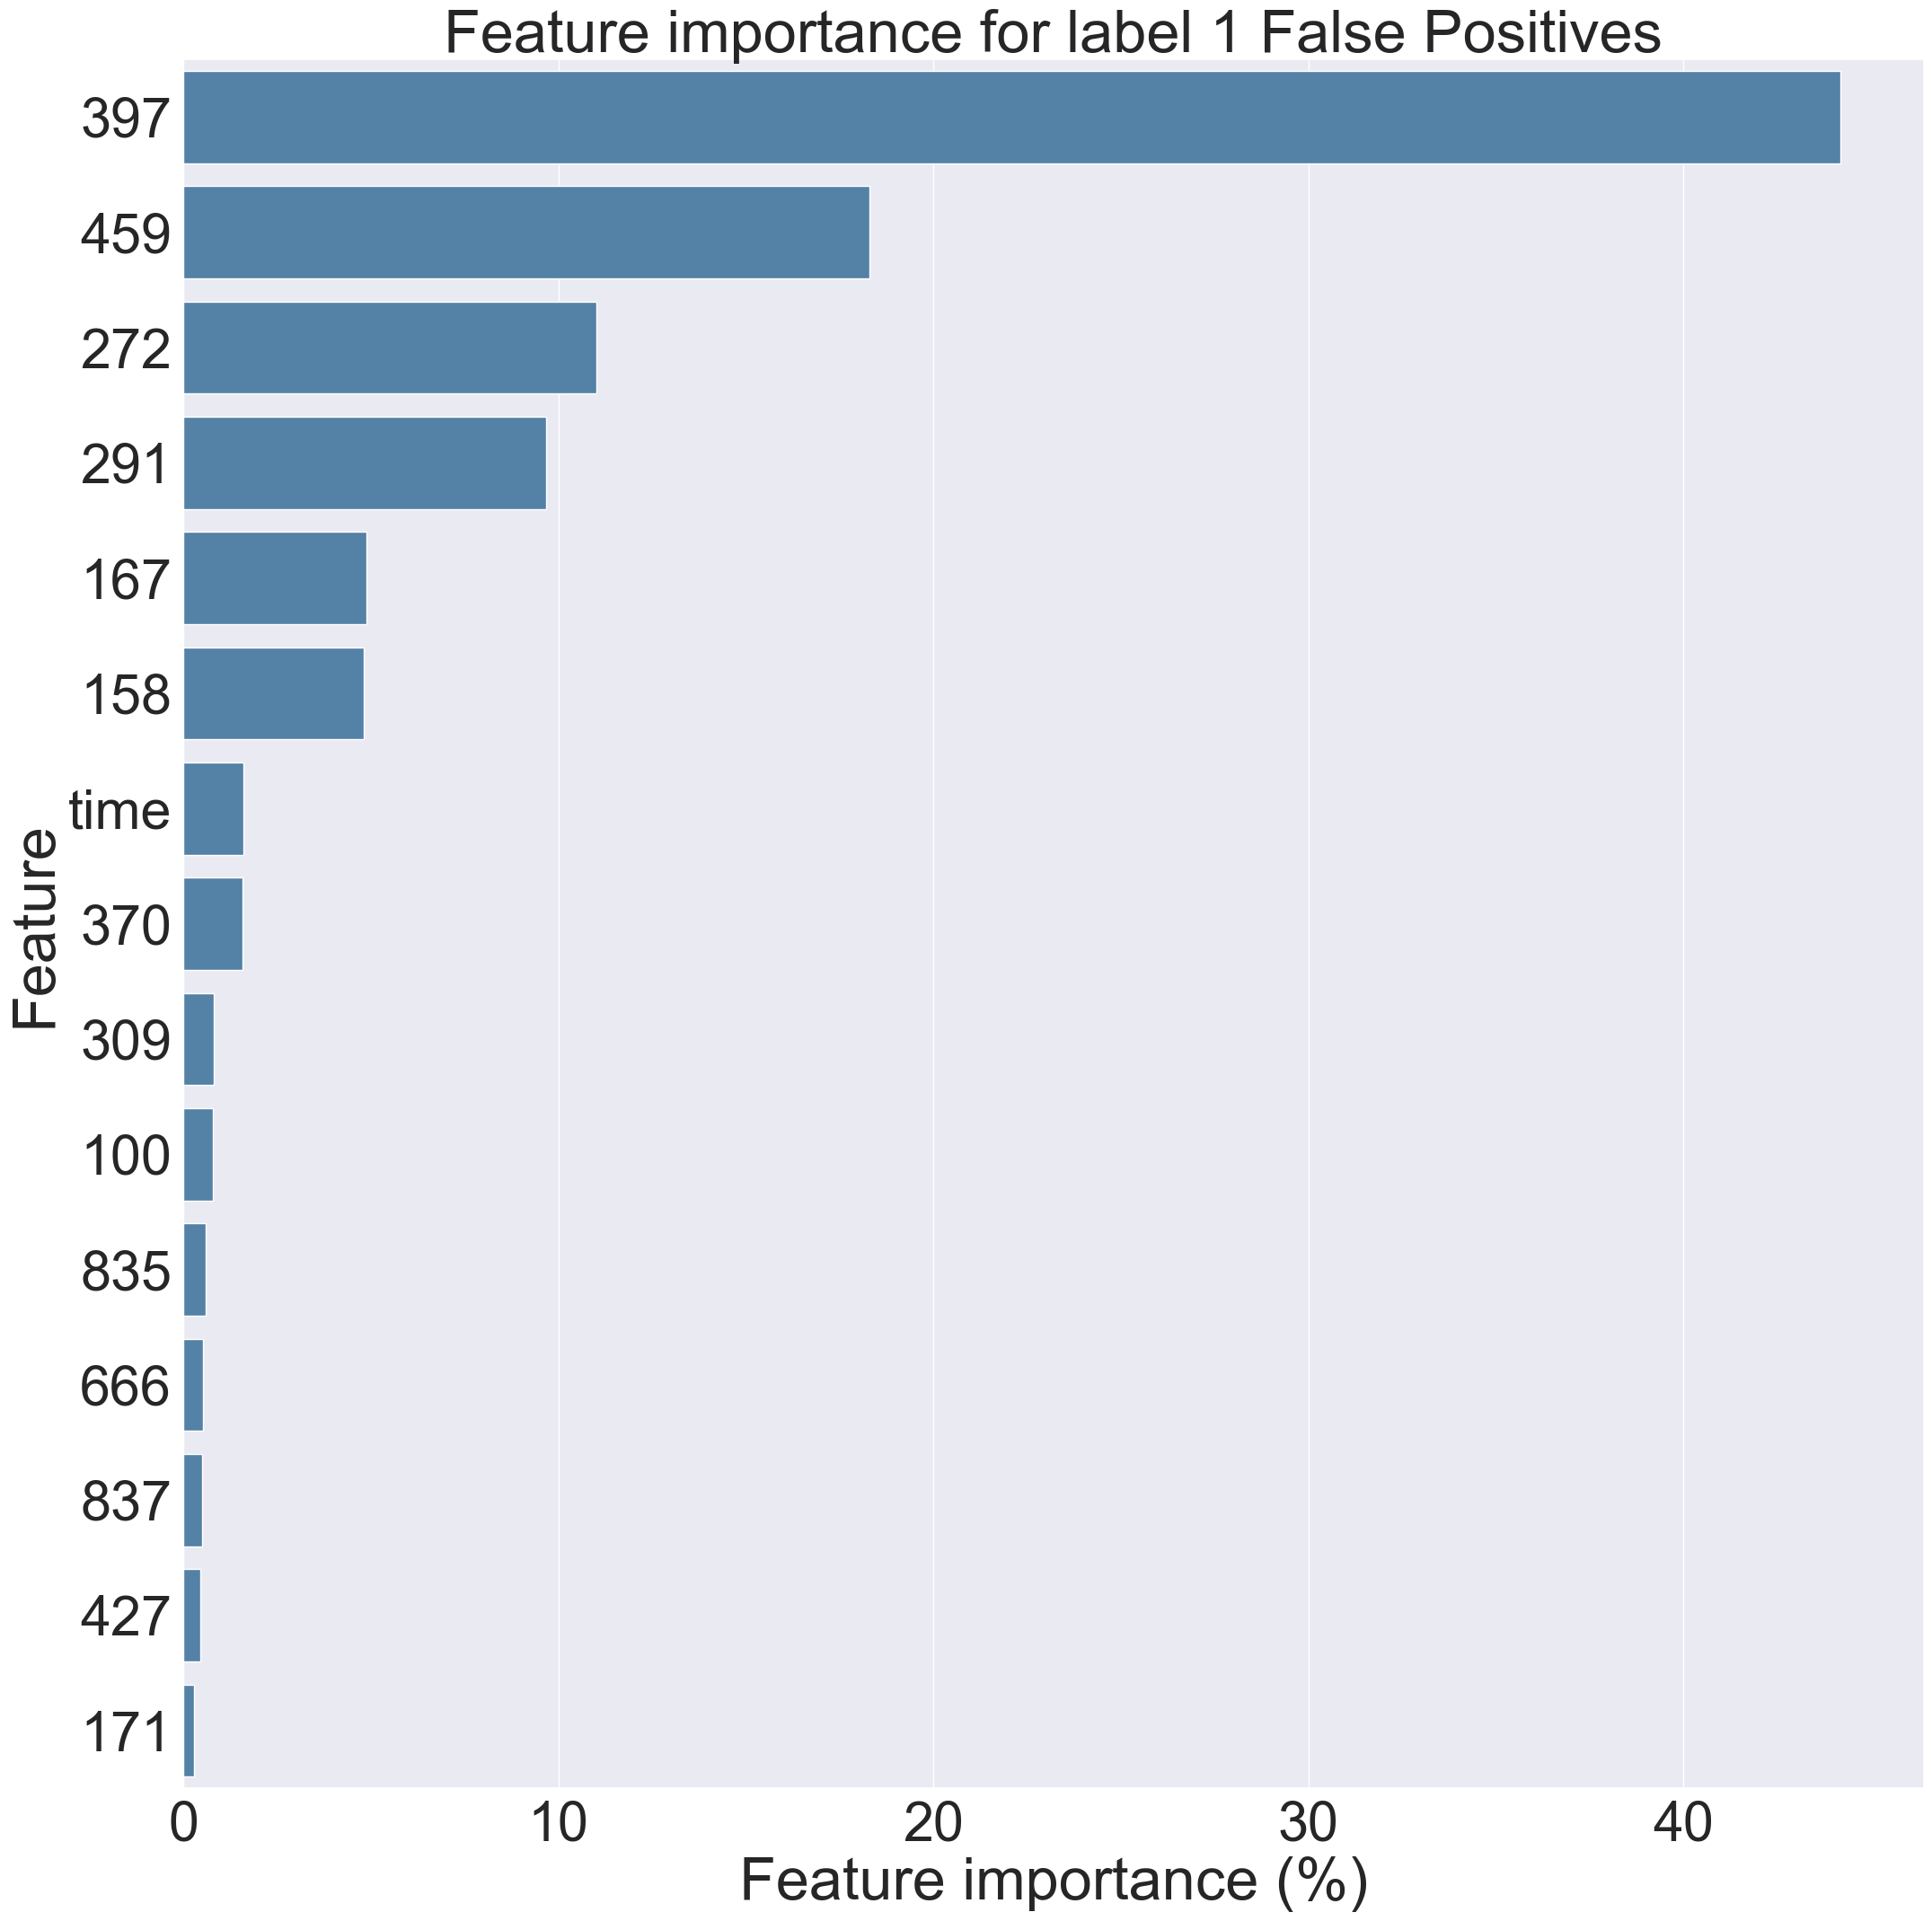

In [289]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label} False Positives')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

## LIME Label 2

### General

In [212]:
label = 2

In [ ]:
# x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_label_from_loader(train_loader, label) 

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
model.eval()
pred = model(x_test.to(model.device))
test_idx = pd.Series(pred.argmax(dim=-1).view(-1).cpu().numpy())
test_idx = test_idx[test_idx == label].index.values.tolist() 


In [ ]:
explanation = get_lime_explanations(x_test, y_train, x_test[test_idx[:10]].numpy(), feature_names, ['0','1','2','3','4'], model)

In [ ]:
explanation

In [ ]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [ ]:
feature_importance

feature timestamp         value
0      feature_36      t-23 -3.844771e-04
1      feature_94      t-23 -3.596448e-04
2      feature_78      t-23 -3.568961e-04
3       feature_2      t-21 -3.552844e-04
4       feature_3      t-20 -3.474473e-04
...           ...       ...           ...
21195  feature_89     t-106  1.411831e-08
21196  feature_61     t-173 -1.026484e-08
21197  feature_74     t-184 -6.757710e-09
21198  feature_49     t-183  5.565887e-09
21199  feature_11     t-152  1.568124e-09

[148400 rows x 3 columns]

In [ ]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

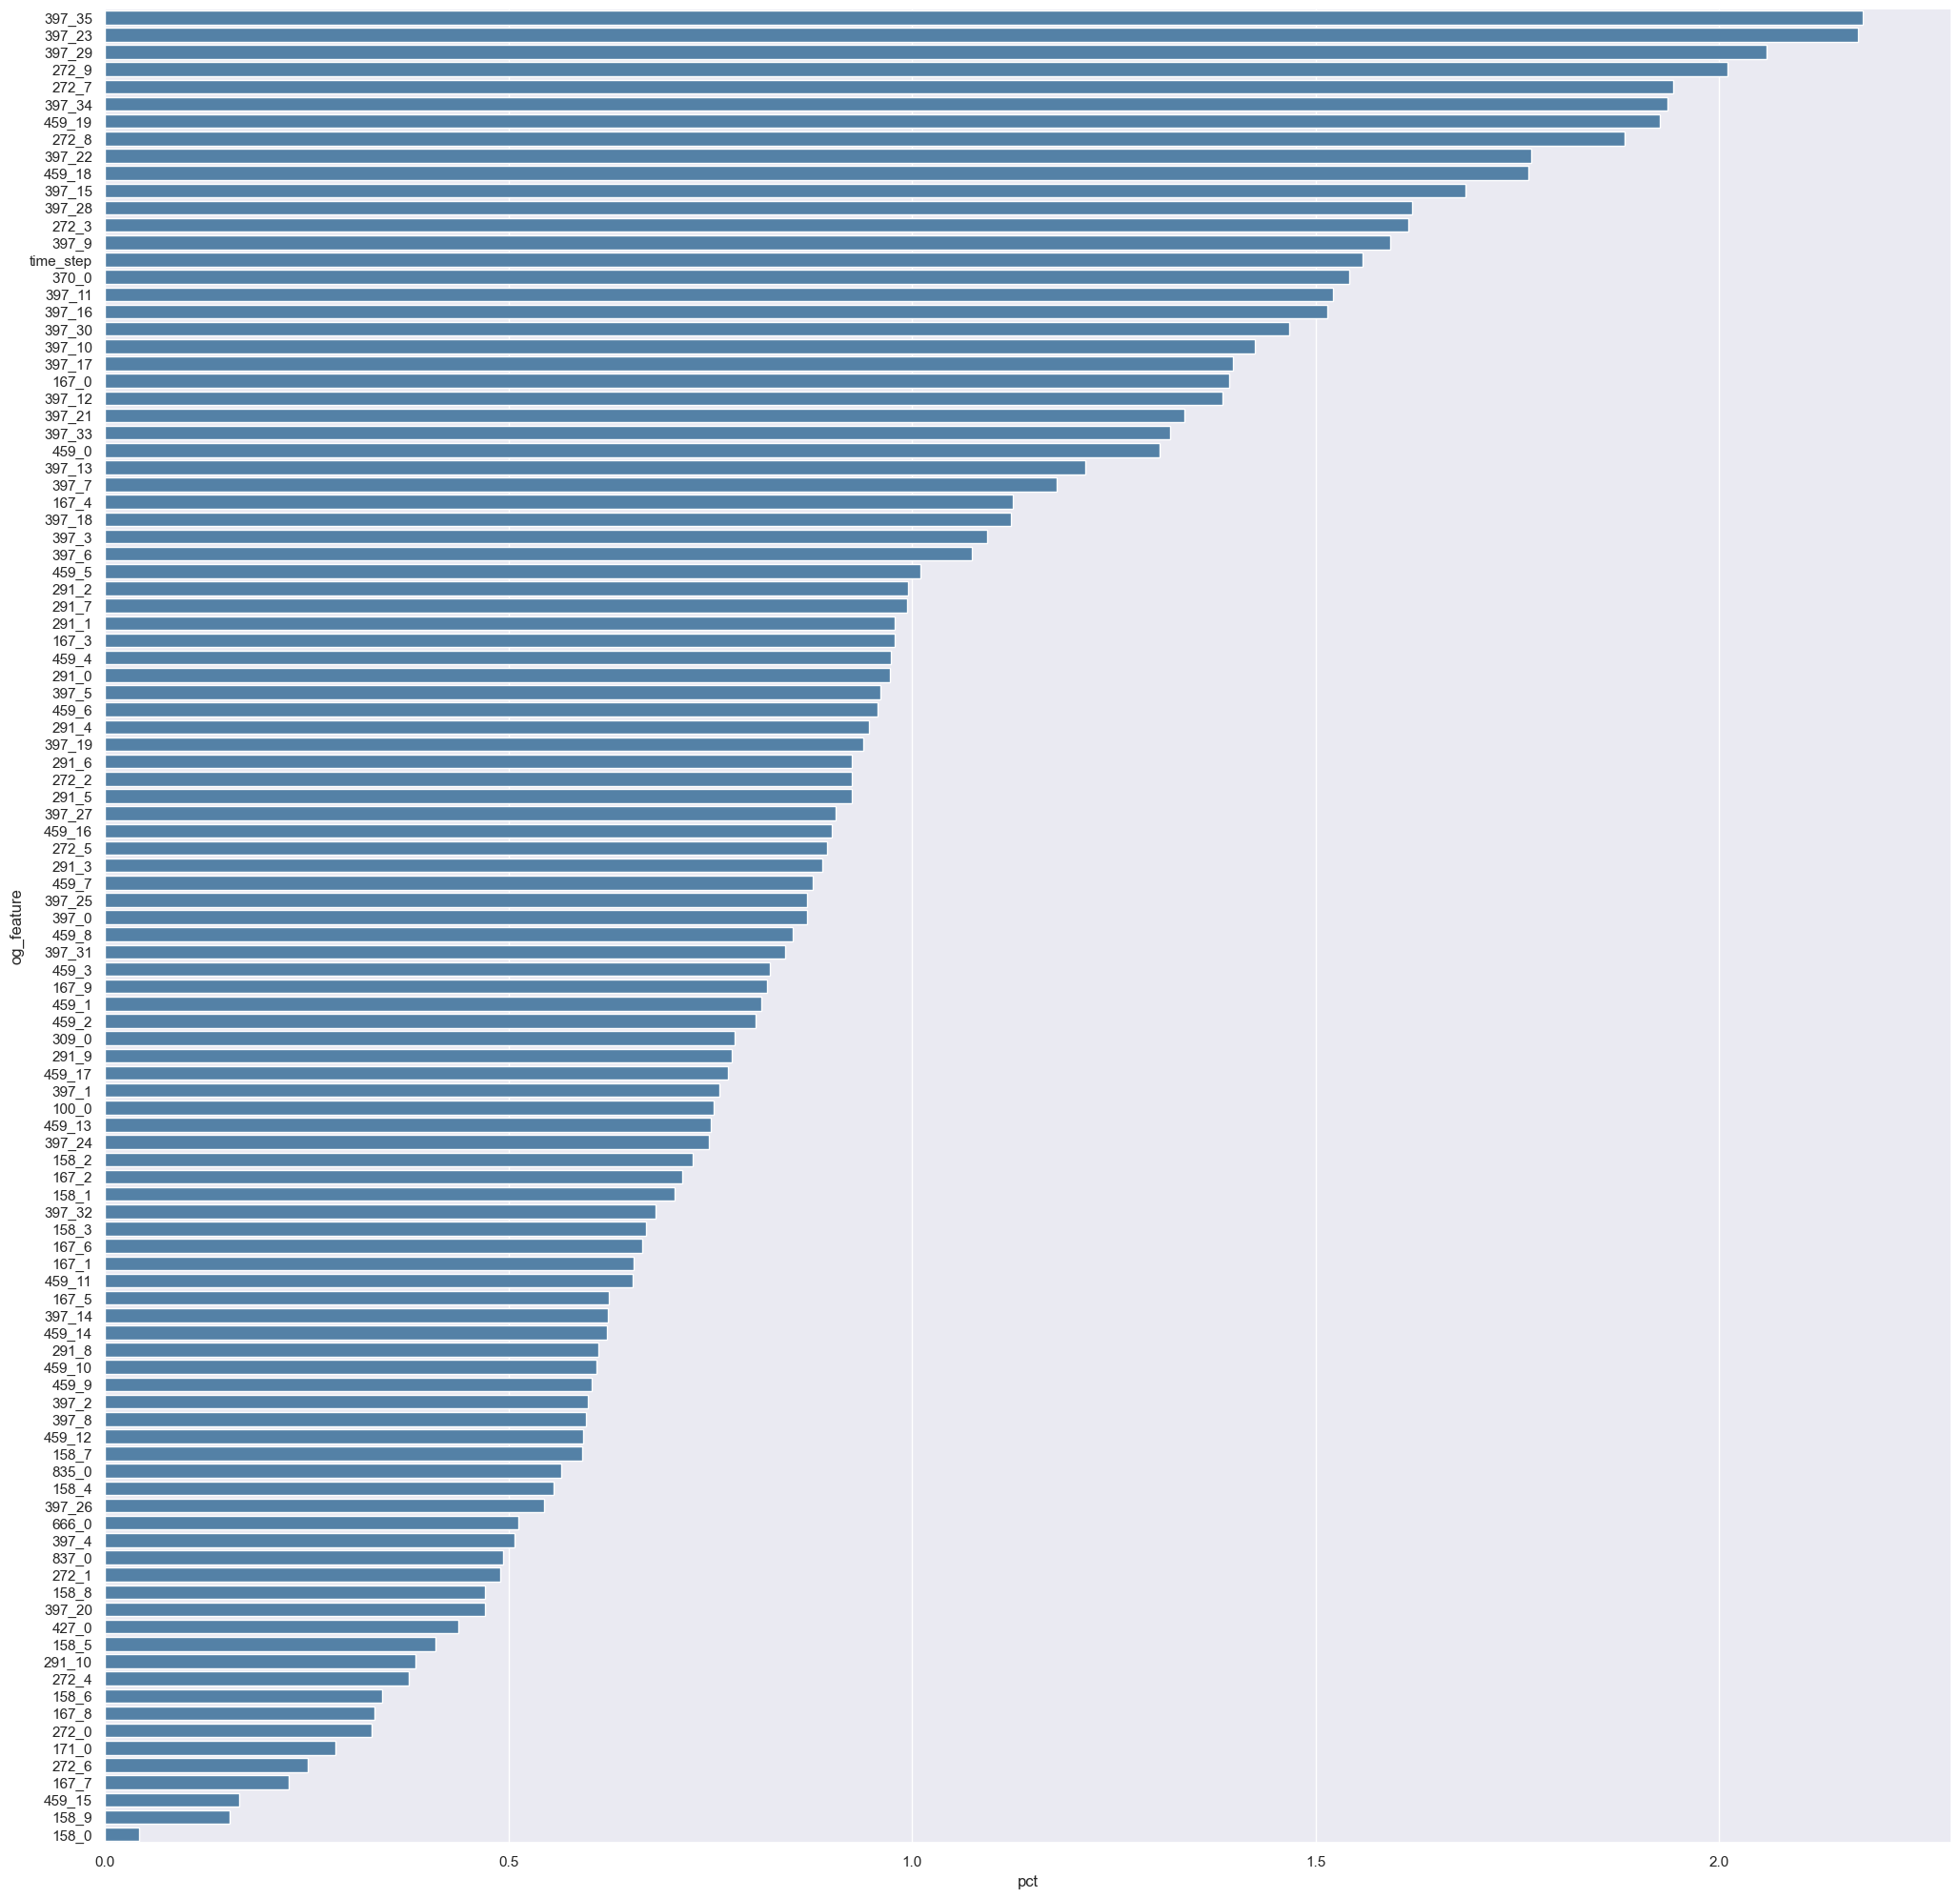

In [ ]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
plt.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [ ]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [ ]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').sum().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

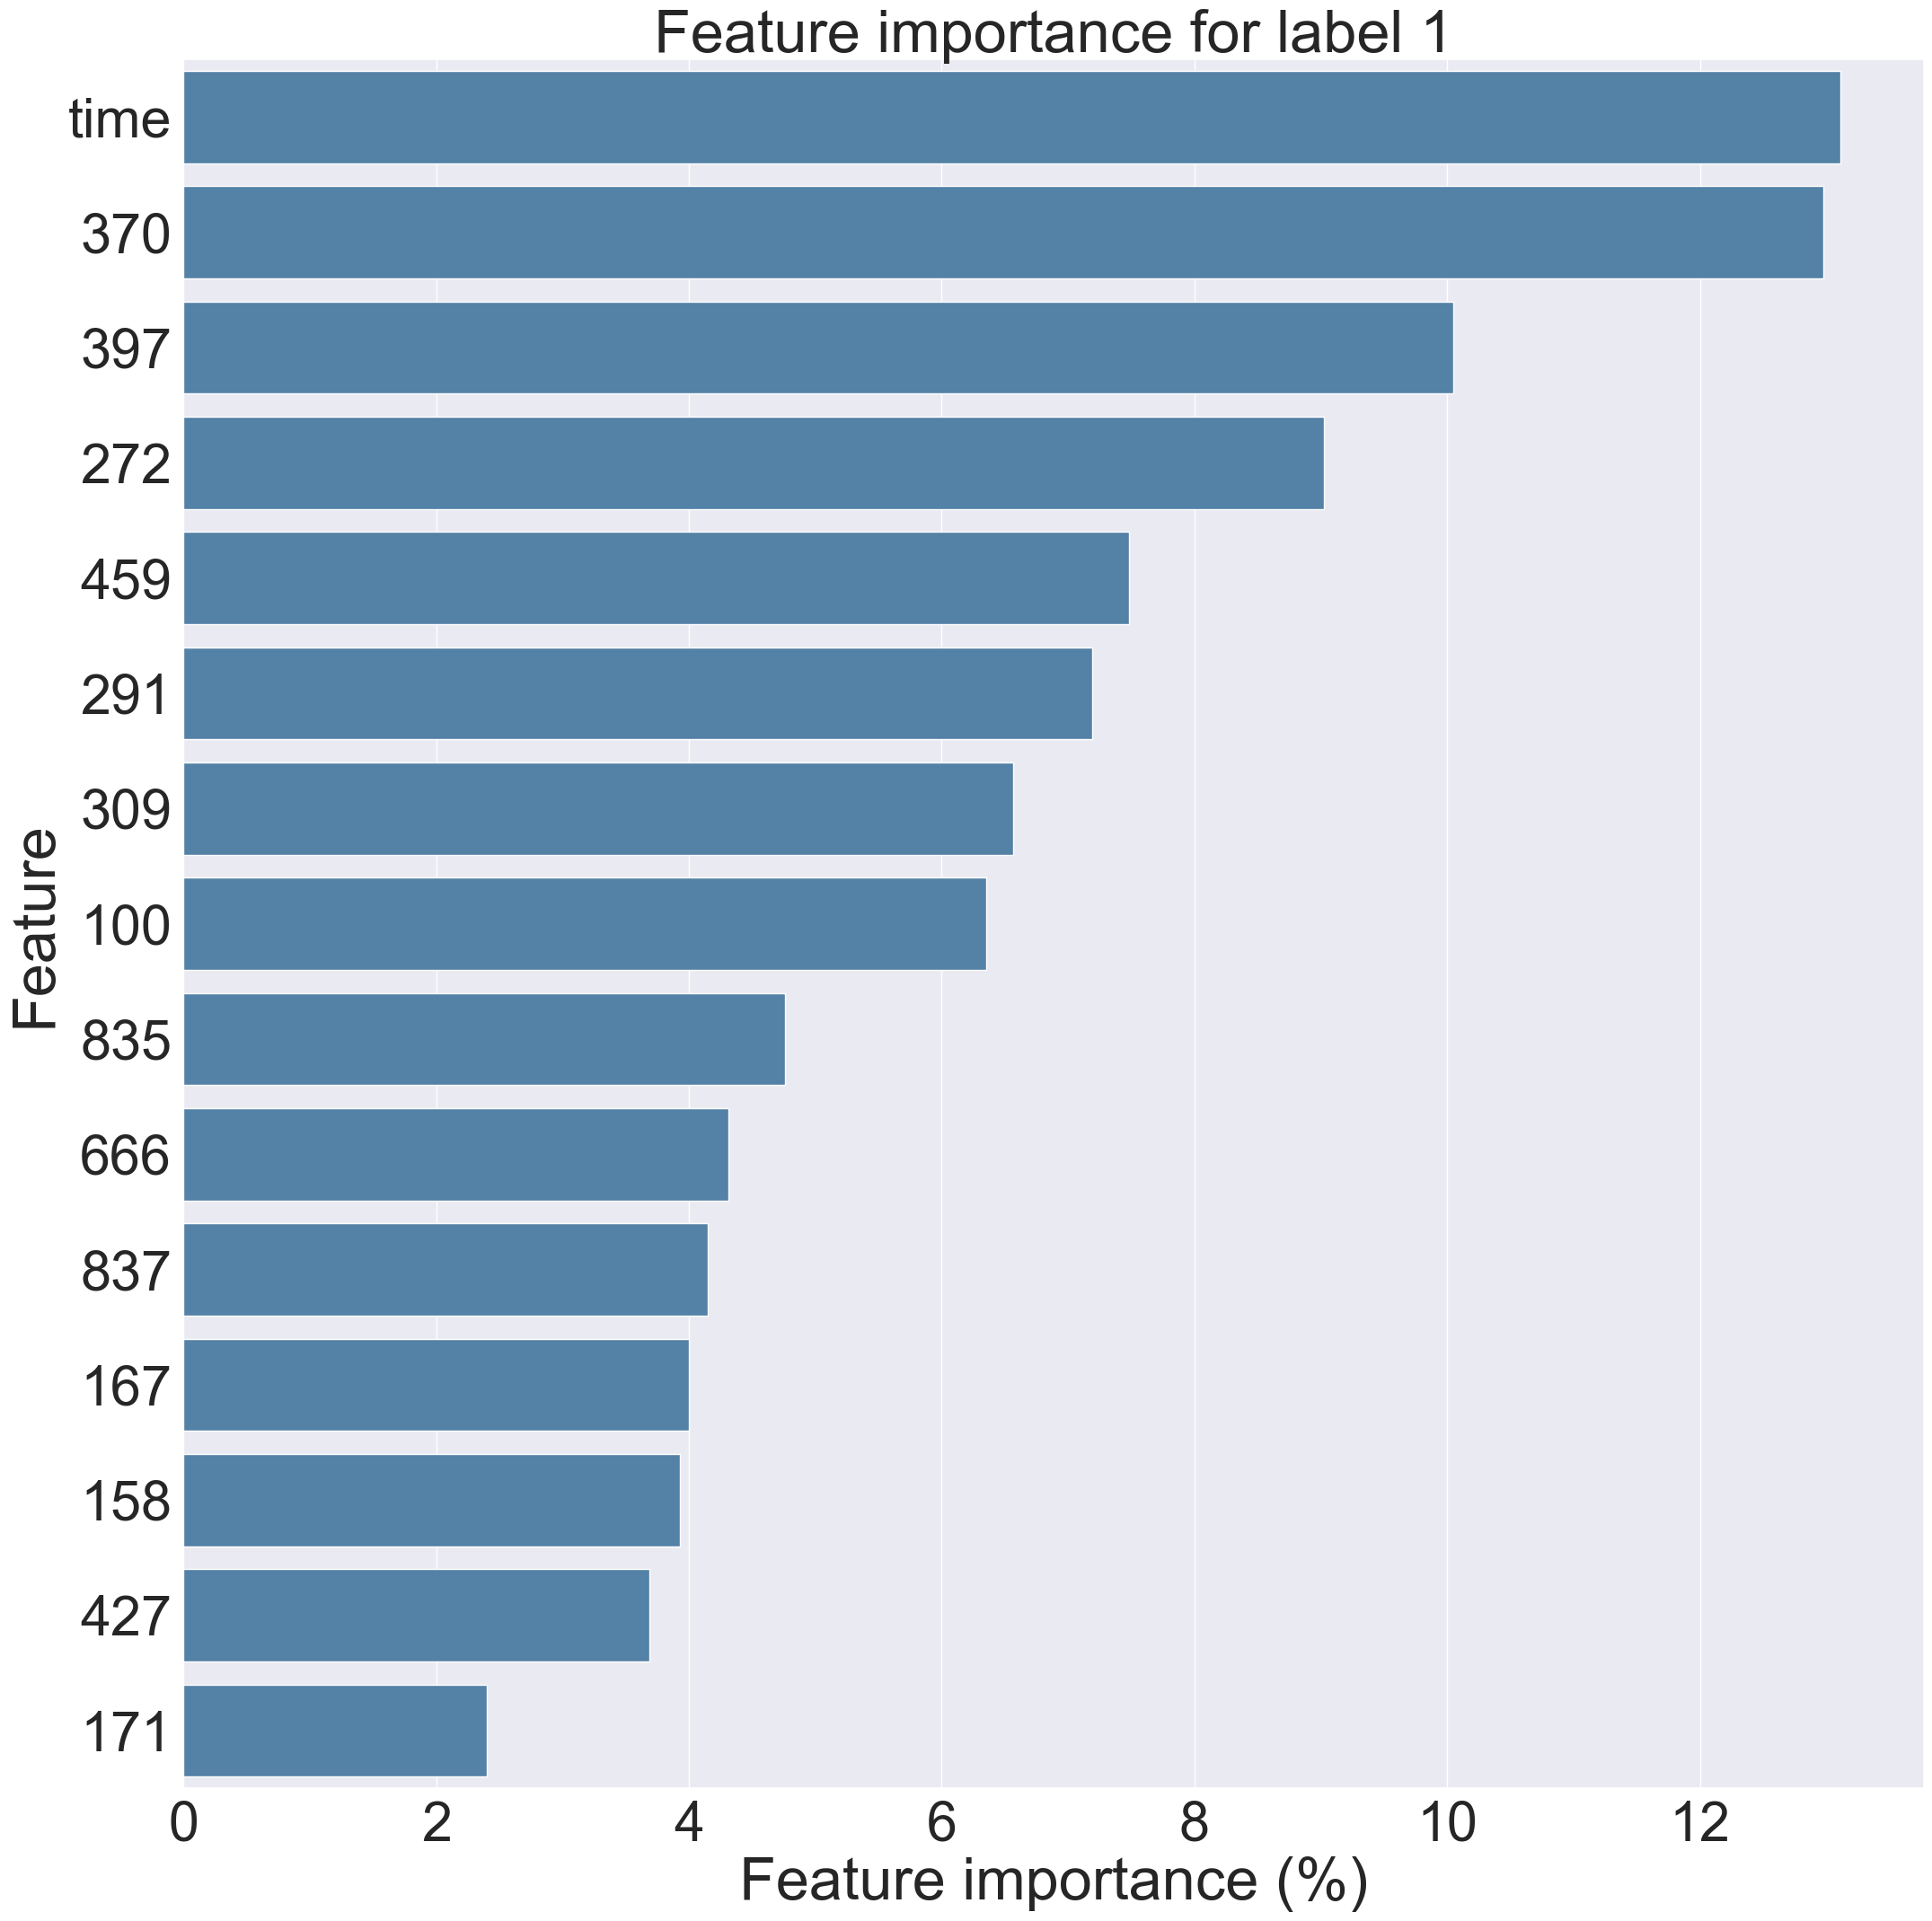

In [ ]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label}')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

### True positives

In [ ]:
label = 1

In [ ]:
x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_tp_or_fp_label_from_loader(train_loader, label, tp=True) 

tensor([ 91,  92,  93,  94,  95,  96, 114, 115])
tensor([ 47,  48, 114, 125, 172, 173, 224, 225, 226, 227, 228, 229, 230, 231],
       device='cuda:0')
[114]


In [ ]:
# test_idx = pd.Series(y_test.argmax(dim=-1).view(-1).numpy())
# test_idx = test_idx[test_idx == label].index.values.tolist()
x_test.shape

torch.Size([1, 200, 106])

In [ ]:
explanation = get_lime_explanations(x_train, y_train, x_test[:10].numpy(), feature_names, ['0','1','2','3','4'], model)

In [ ]:
explanation

In [ ]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [ ]:
feature_importance

feature timestamp         value
0       feature_70      t-11 -5.563574e-04
1       feature_80       t-9 -5.357825e-04
2       feature_18      t-12 -5.155741e-04
3       feature_36       t-9 -5.110973e-04
4      feature_101      t-12 -4.950251e-04
...            ...       ...           ...
21195   feature_38      t-86 -2.971123e-08
21196   feature_75     t-145  2.883297e-08
21197  feature_102     t-181  1.760829e-08
21198   feature_65     t-110  1.466690e-08
21199   feature_91     t-170 -1.297471e-08

[21200 rows x 3 columns]

In [ ]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

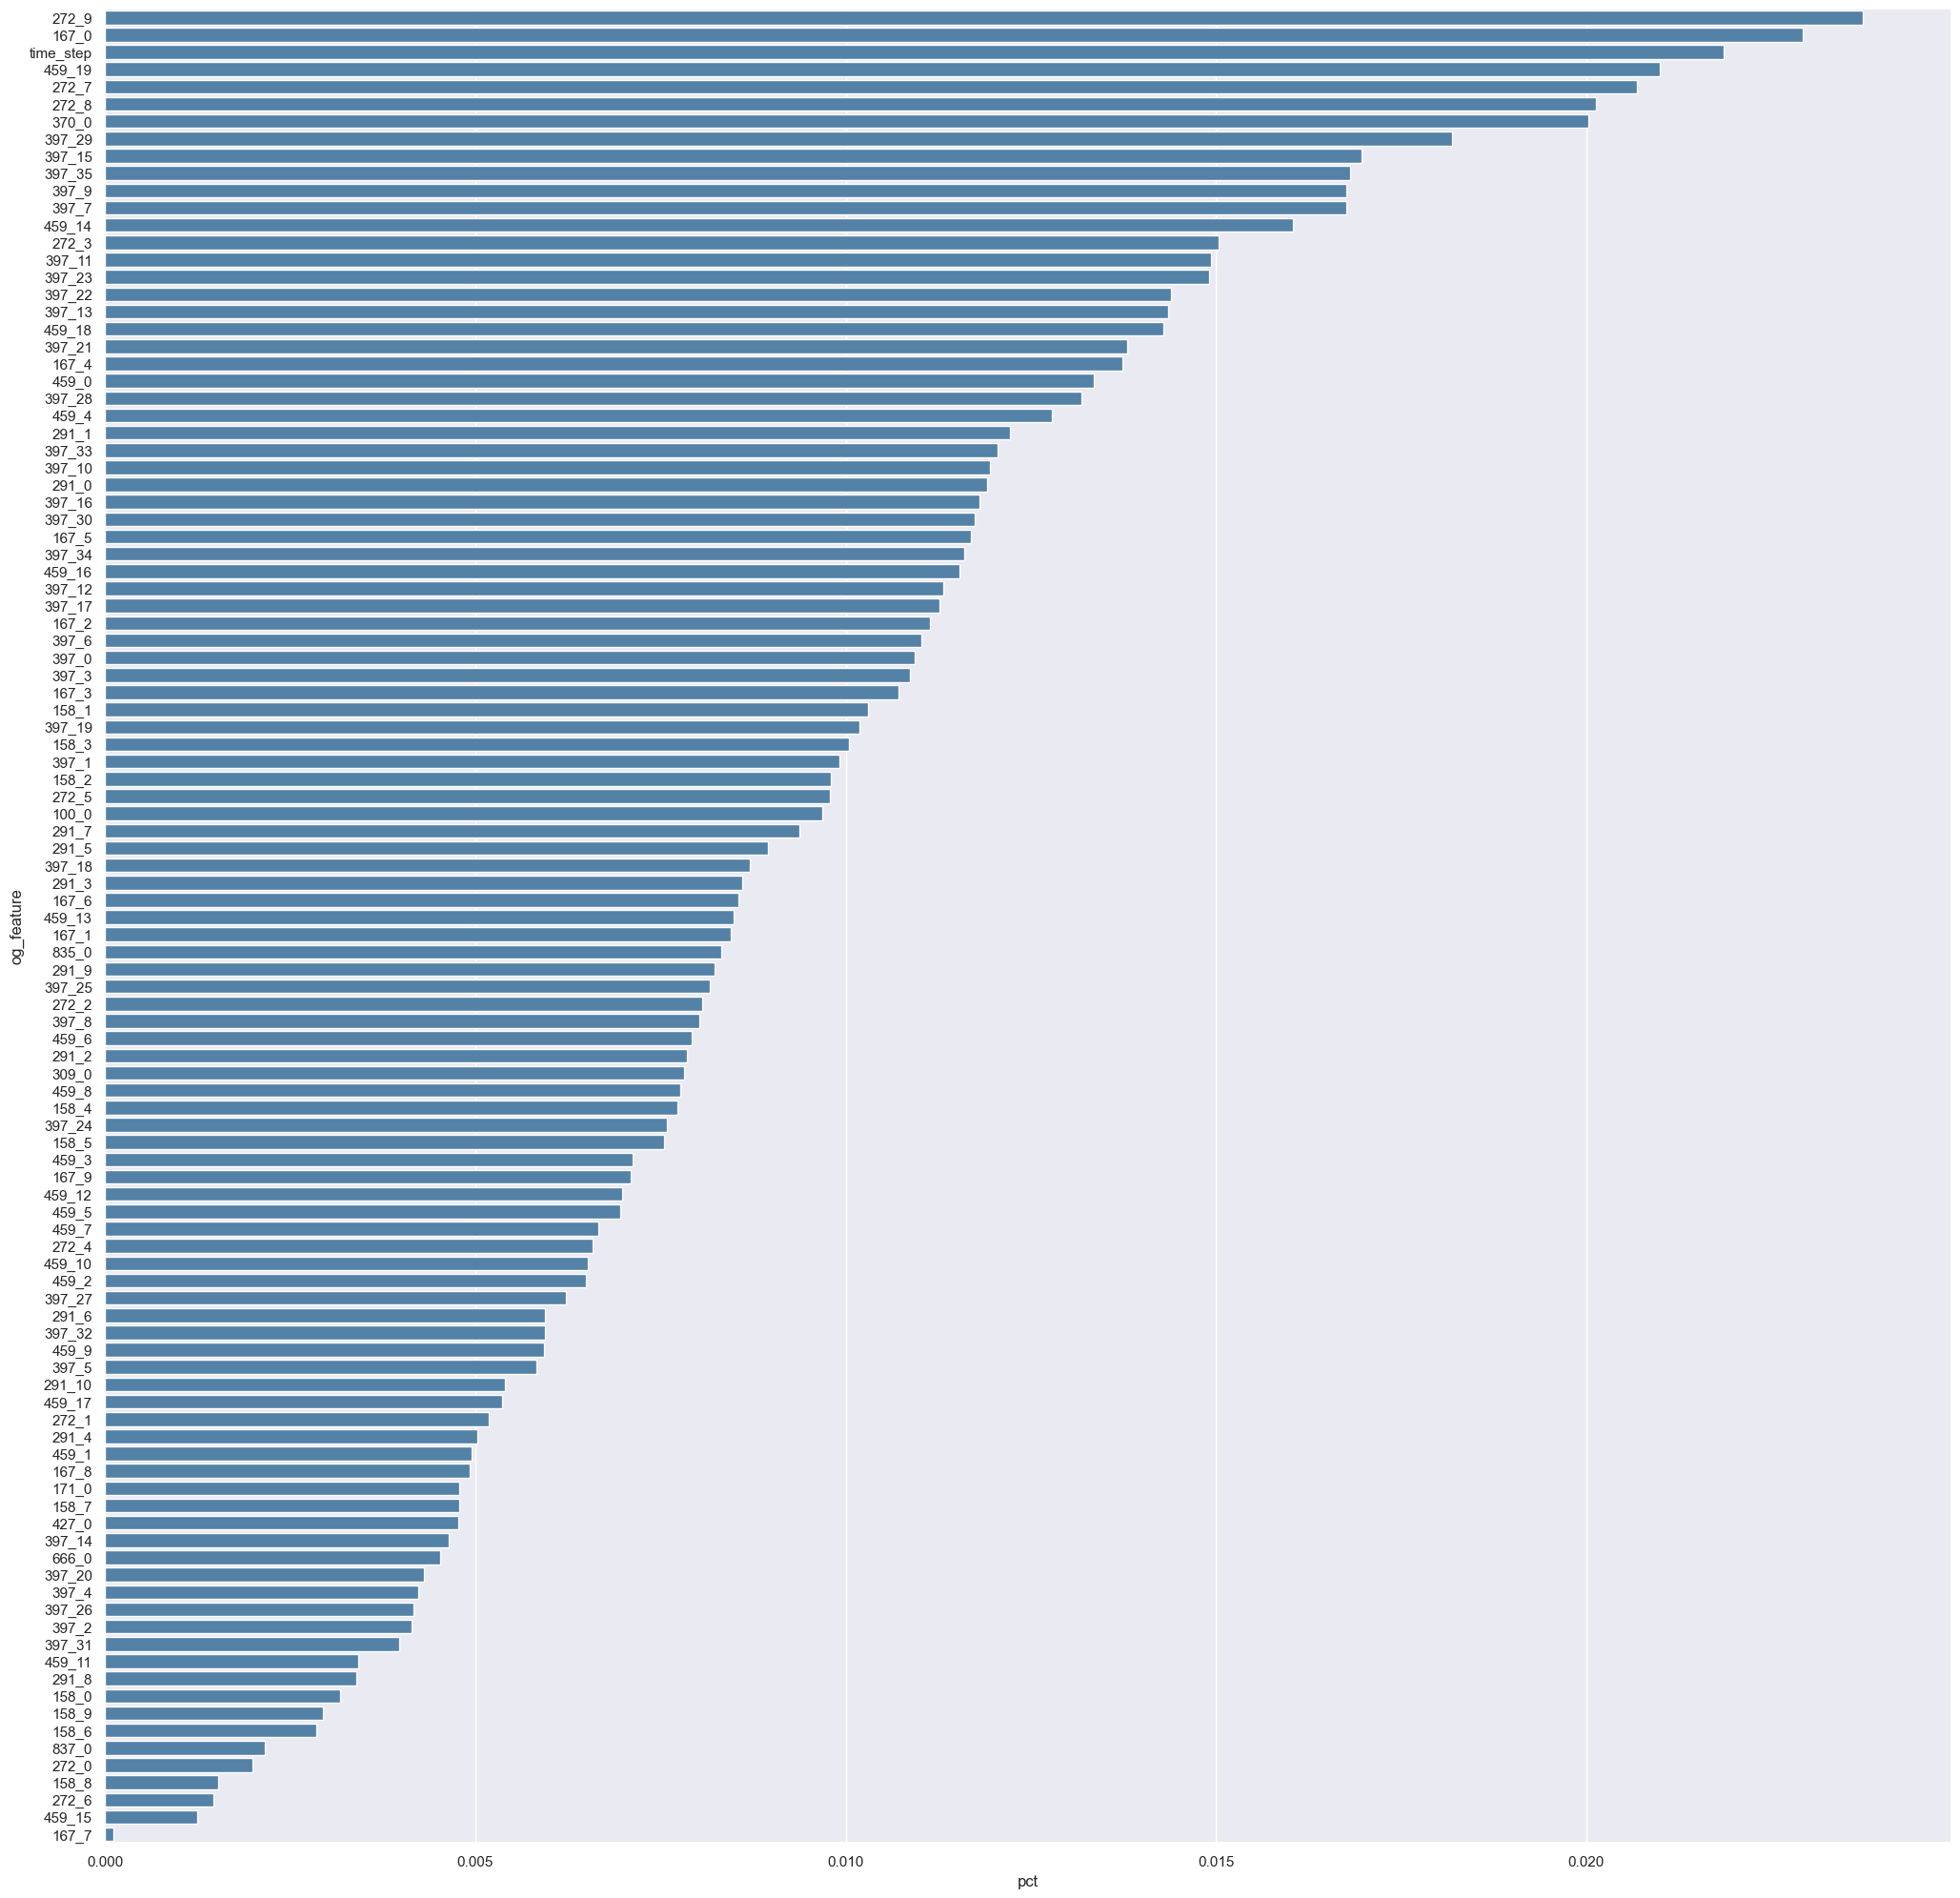

In [ ]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum()
plt.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [ ]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [ ]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').sum().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

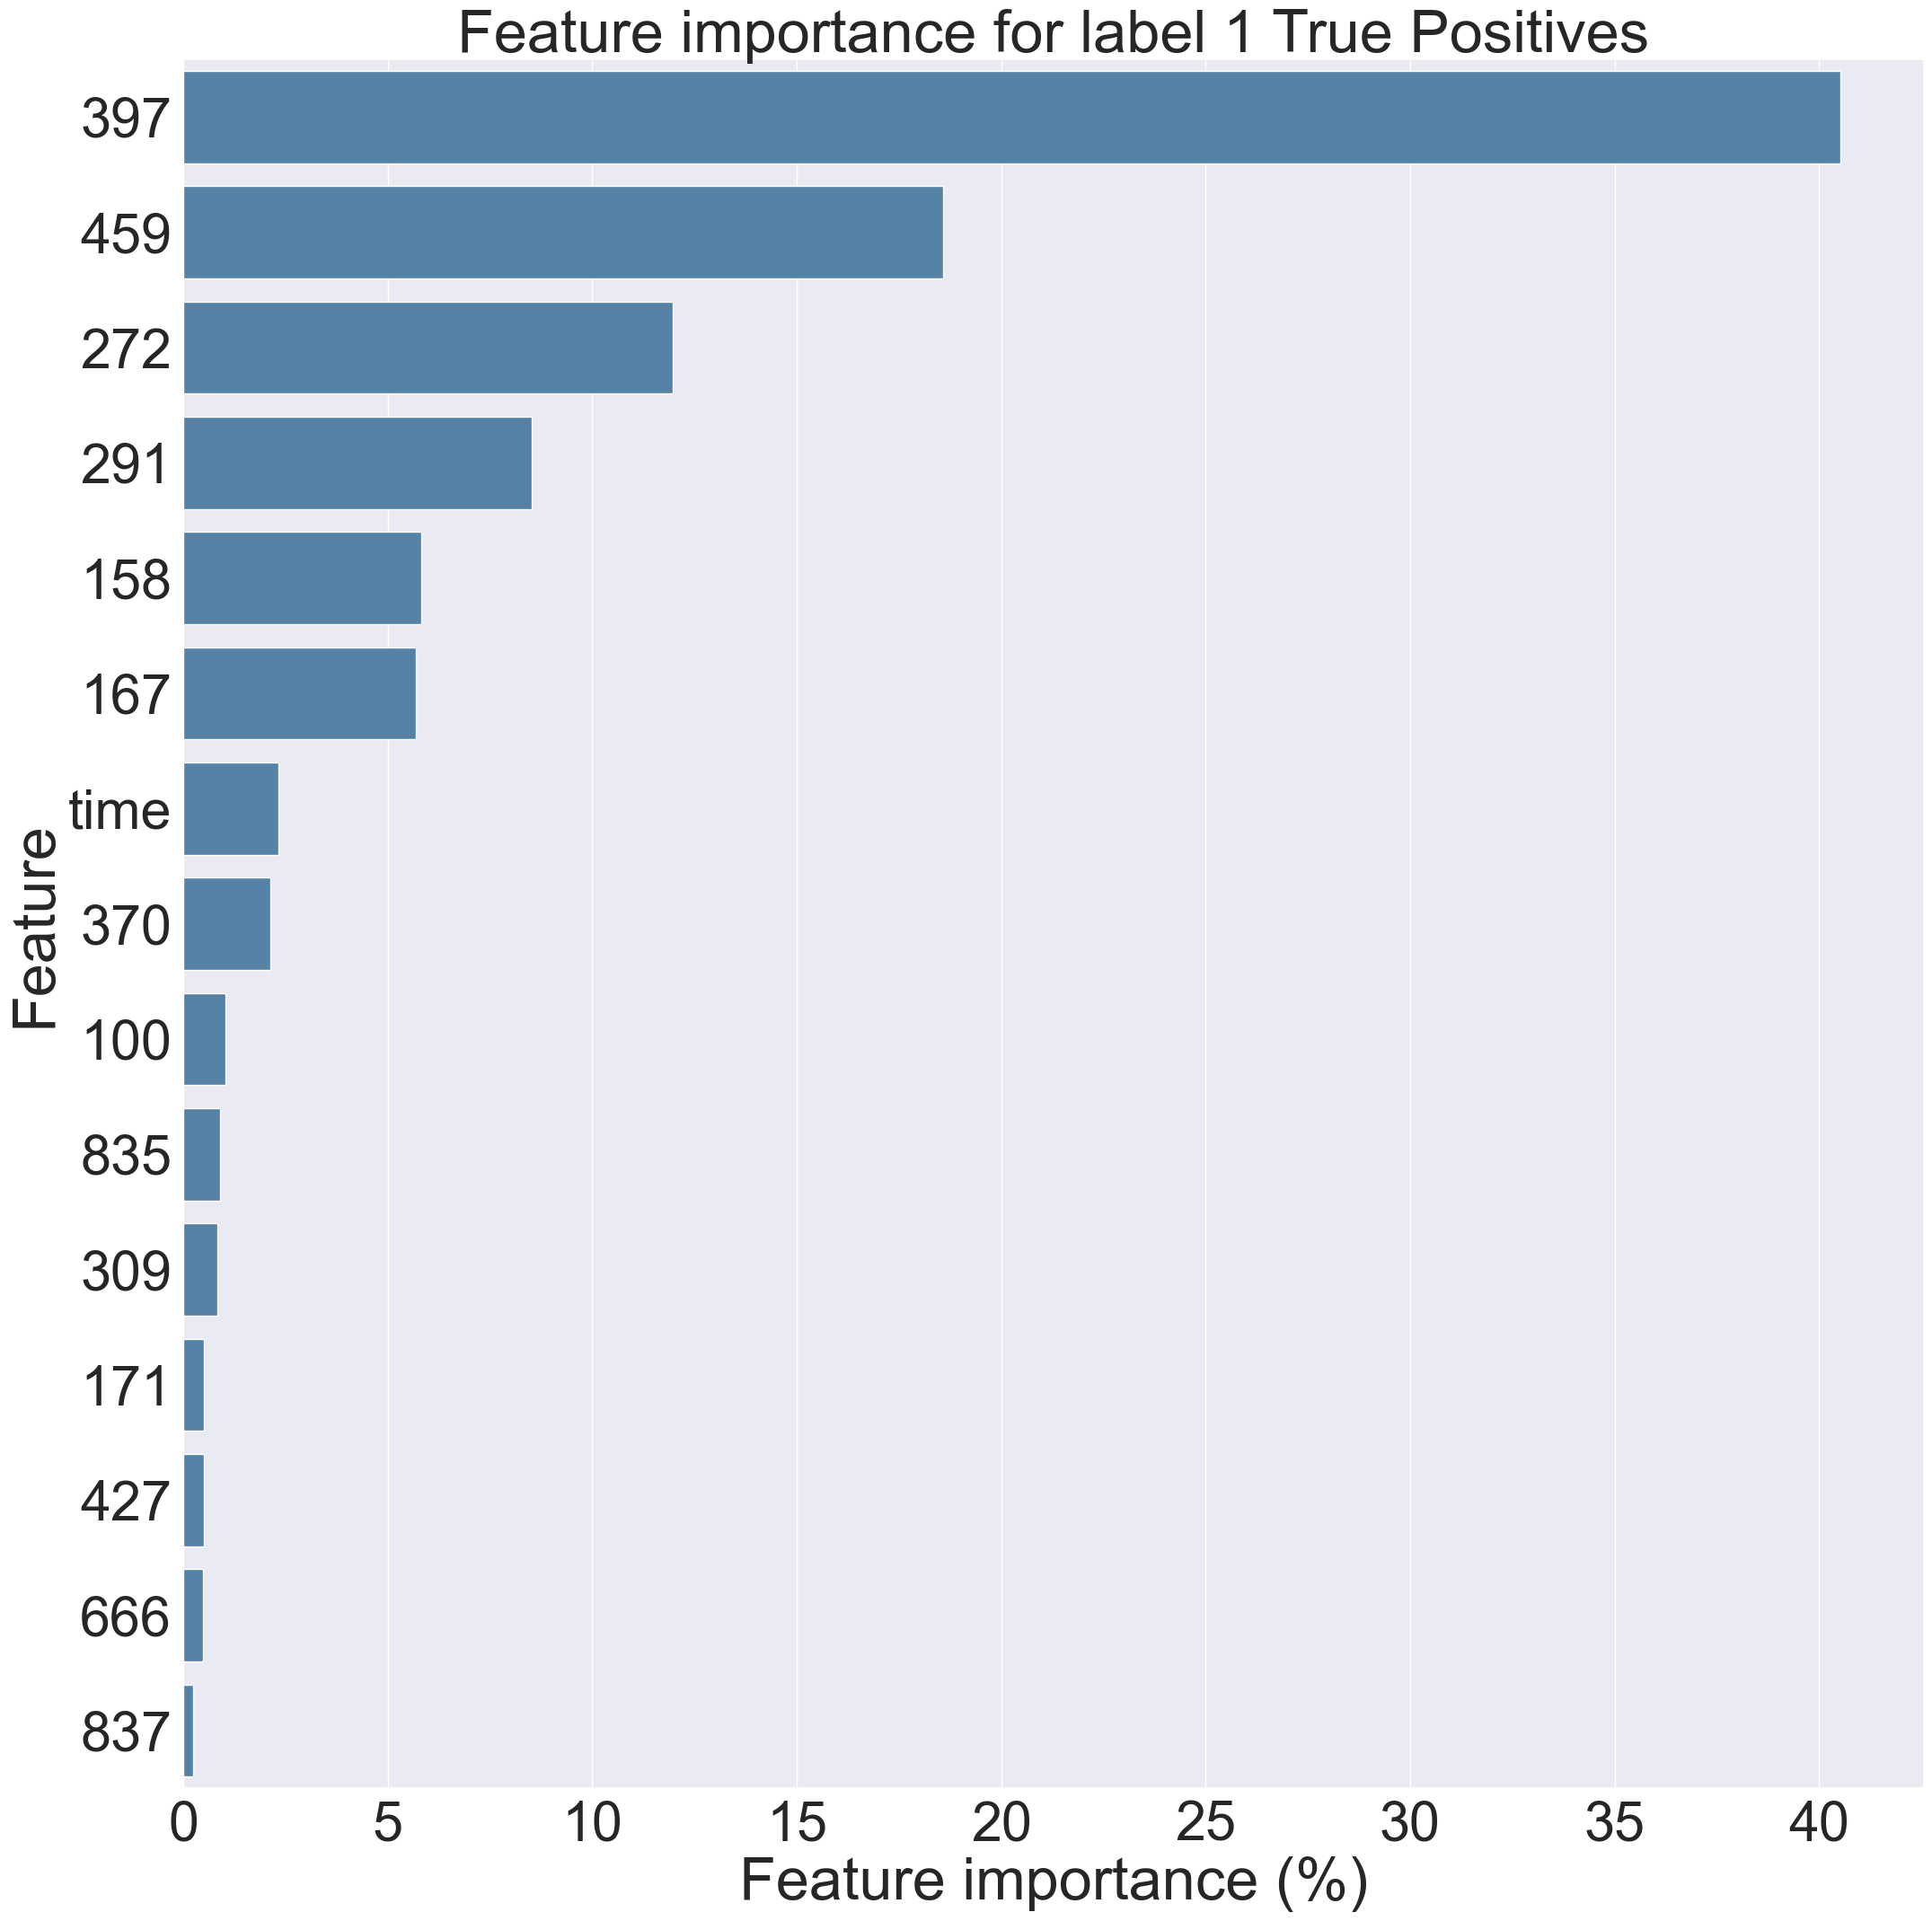

In [ ]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label} True Positives')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

### False positive

In [ ]:
label = 1

In [ ]:
x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_tp_or_fp_label_from_loader(valid_loader, label, tp=False) 

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [ ]:
# test_idx = pd.Series(y_test.argmax(dim=-1).view(-1).numpy())
# test_idx = test_idx[test_idx == label].index.values.tolist()
x_test.shape

torch.Size([7, 200, 106])

In [ ]:
explanation = get_lime_explanations(x_train, y_train, x_test[:10].numpy(), feature_names, ['0','1','2','3','4'], model)

In [ ]:
explanation

In [ ]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [ ]:
feature_importance

feature timestamp         value
0      feature_99       t-0  2.059921e-03
1      feature_99       t-1  1.788183e-03
2      feature_93       t-0  1.244782e-03
3      feature_93       t-1  1.044454e-03
4      feature_92       t-0  9.301778e-04
...           ...       ...           ...
21195  feature_79     t-159  1.567303e-08
21196  feature_73     t-120  1.412871e-08
21197  feature_28     t-147  1.122939e-08
21198   feature_6      t-80 -1.111708e-08
21199   feature_6     t-104  1.011391e-08

[84800 rows x 3 columns]

In [ ]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

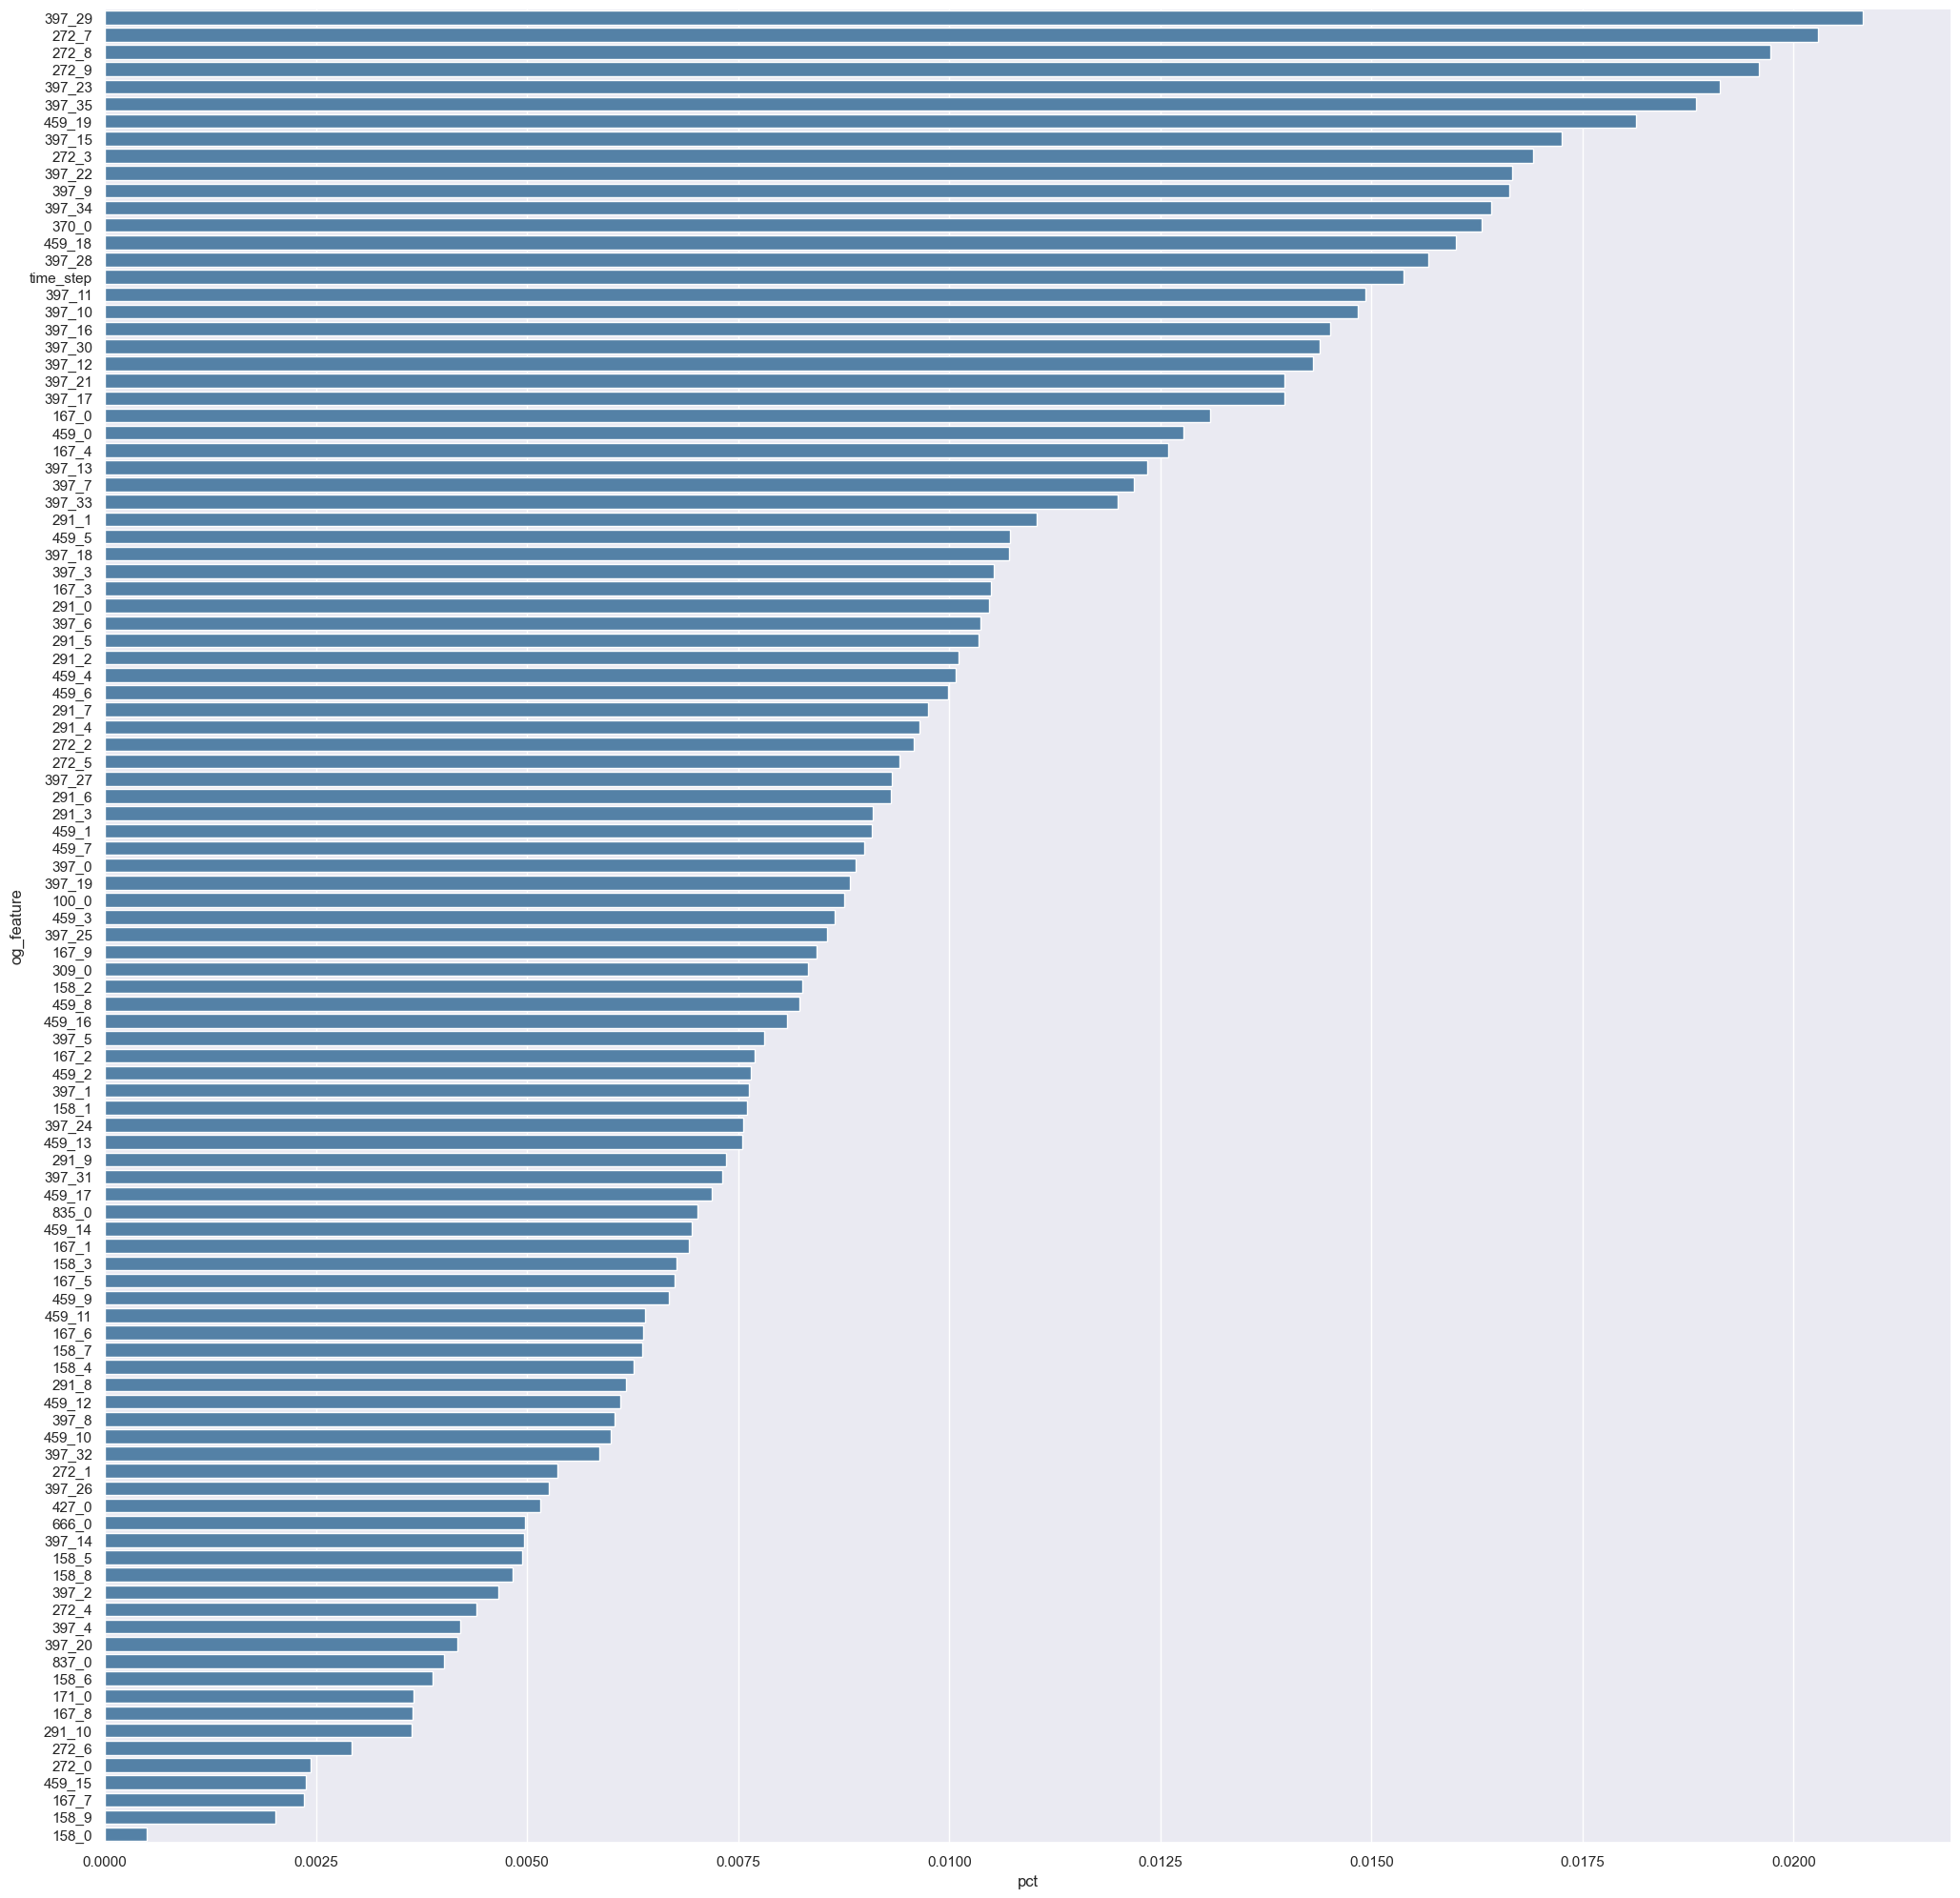

In [ ]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum()
plt.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [ ]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [ ]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').sum().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

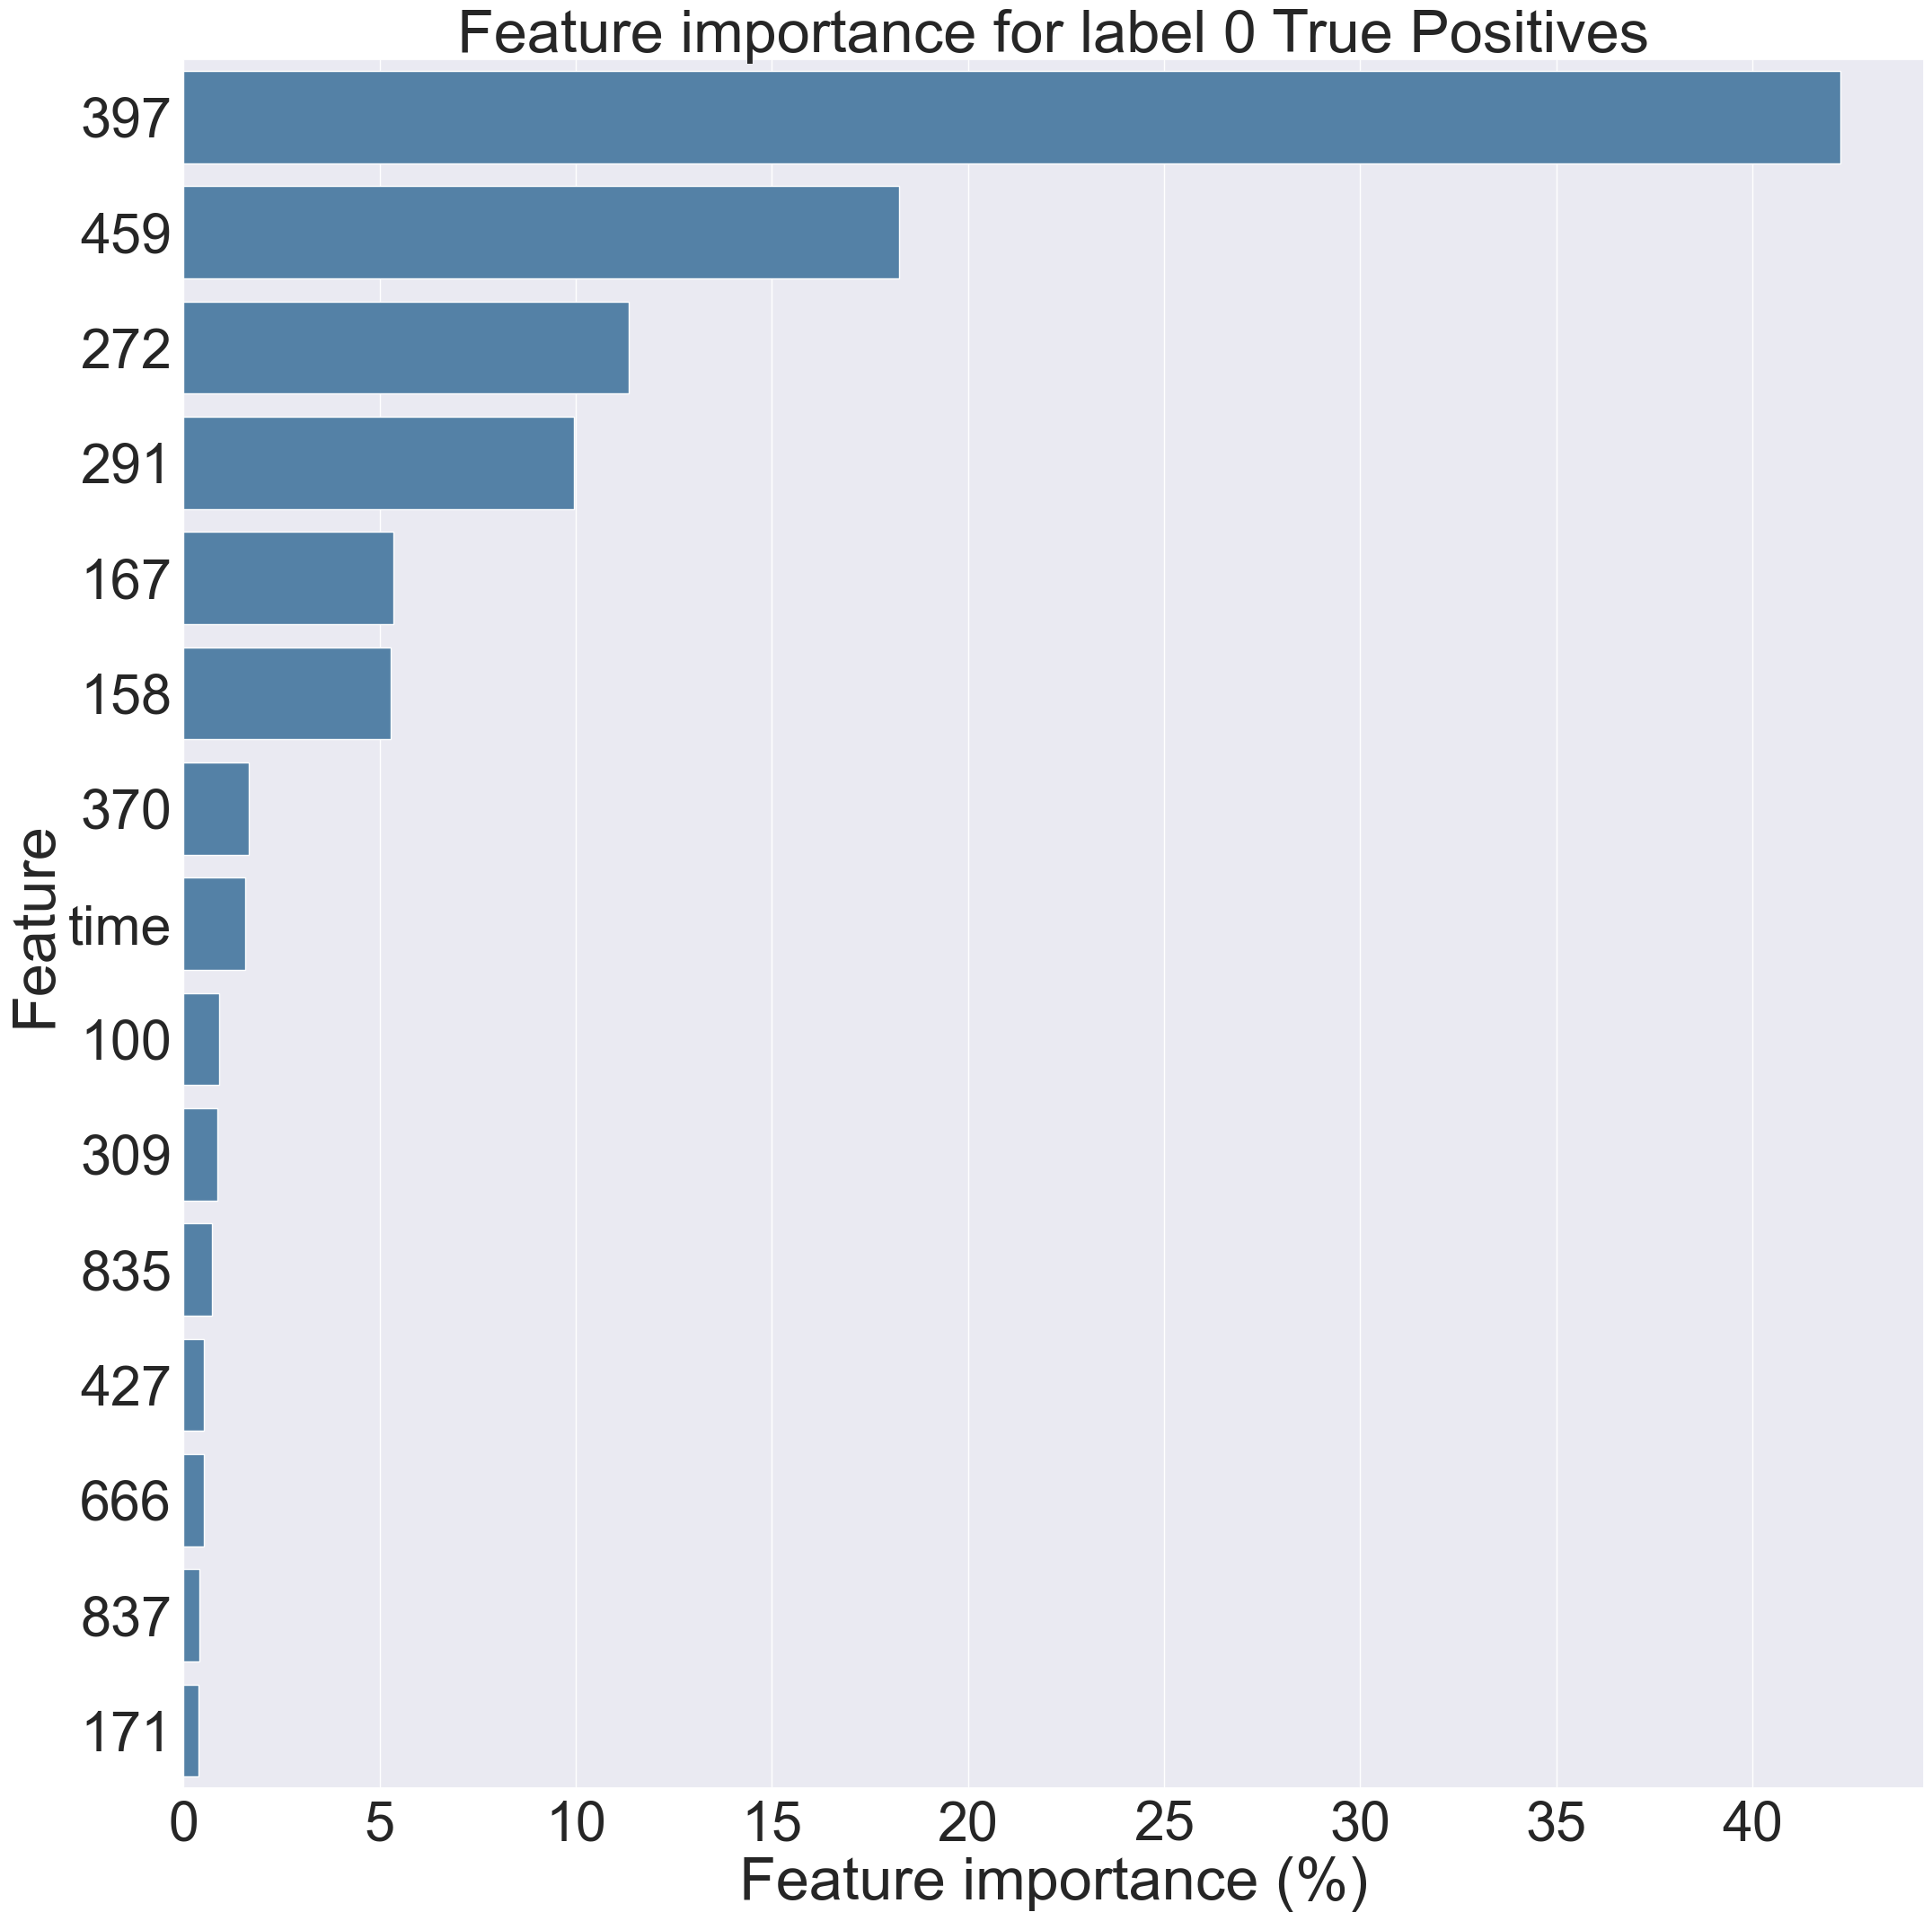

In [ ]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label} False Positives')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

## LIME Label 3

### General

In [15]:
label = 3

In [16]:
x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_label_from_loader(valid_loader, label) 

In [17]:
model.eval()
pred = model(x_test.to(model.device))
test_idx = pd.Series(pred.argmax(dim=-1).view(-1).cpu().numpy())
test_idx = test_idx[test_idx == label].index.values.tolist() 


In [18]:
explanation = get_lime_explanations(x_train, y_train, x_test[test_idx[:10]].numpy(), feature_names, ['0','1','2','3','4'], model)

In [19]:
explanation

In [20]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [21]:
feature_importance

feature timestamp         value
0       feature_58      t-33 -2.910413e-04
1       feature_40      t-32 -2.789277e-04
2       feature_17      t-17 -2.782240e-04
3        feature_2      t-33 -2.684976e-04
4       feature_78      t-33 -2.679280e-04
...            ...       ...           ...
21195   feature_84     t-128  5.932717e-09
21196   feature_60      t-31 -5.930424e-09
21197  feature_101     t-159 -5.229507e-09
21198   feature_90     t-160 -3.299100e-09
21199   feature_36     t-194  1.324517e-09

[190800 rows x 3 columns]

In [22]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

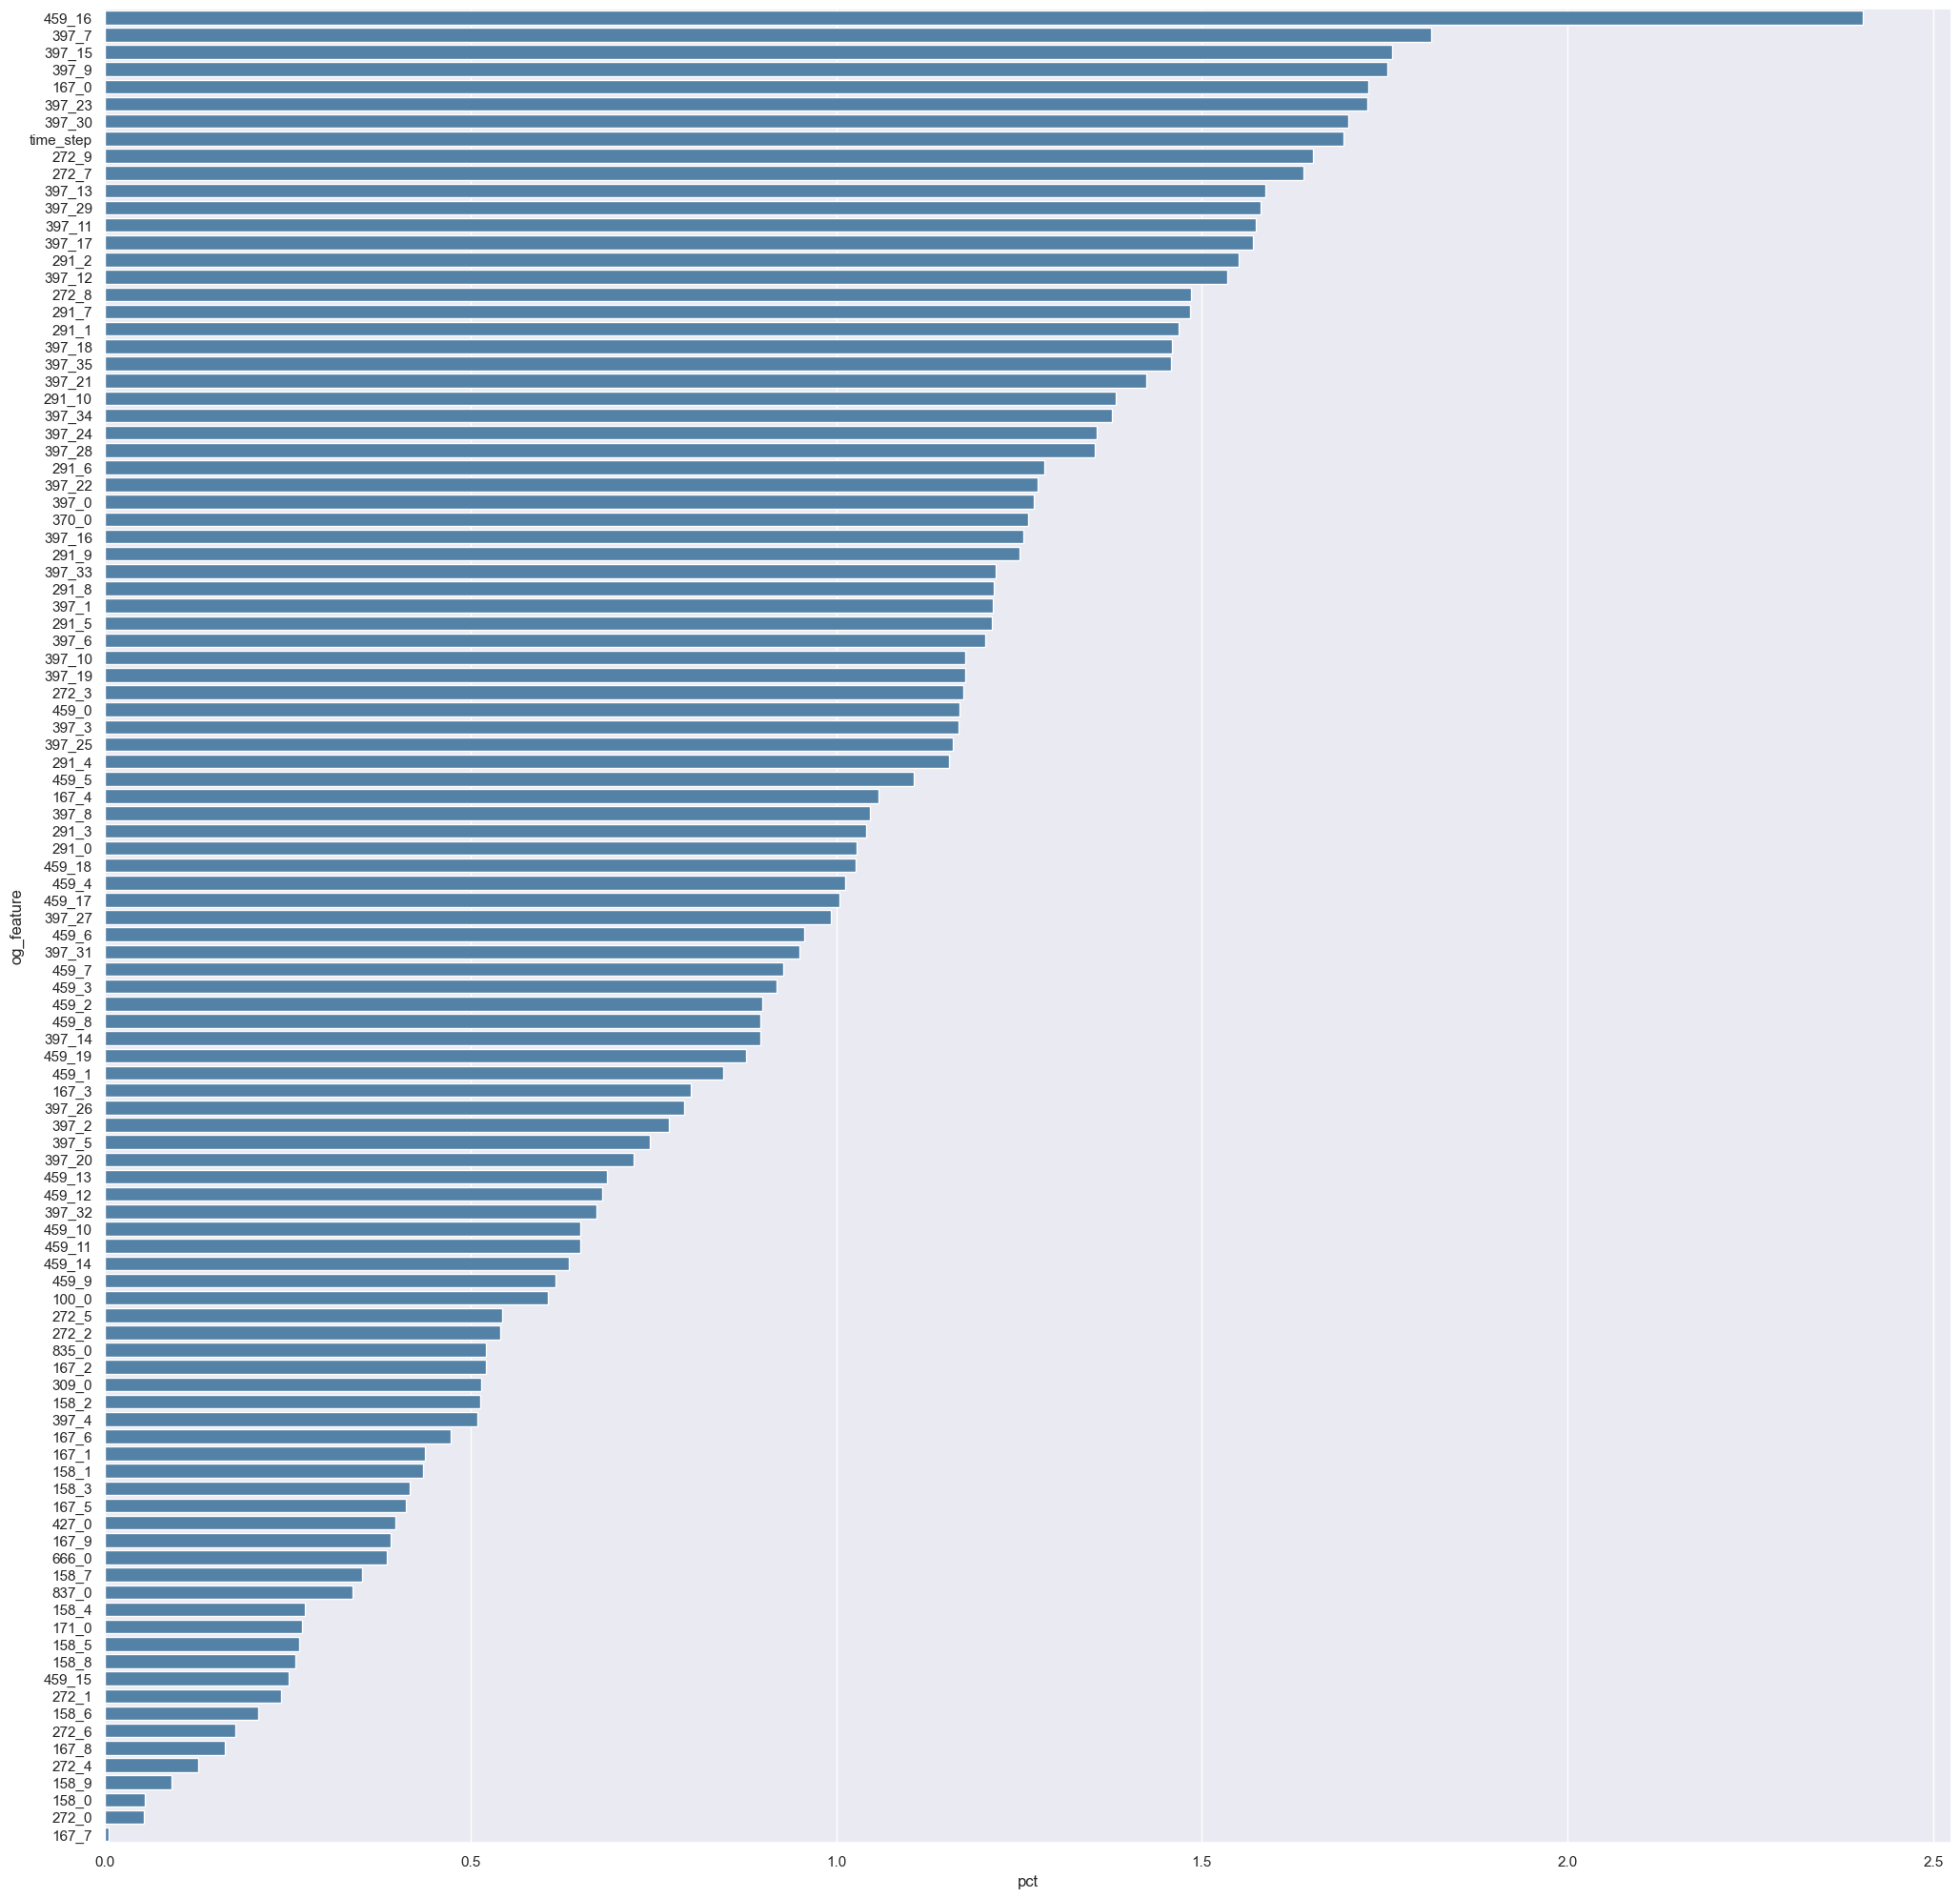

In [23]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
plt.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [24]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [25]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').sum().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

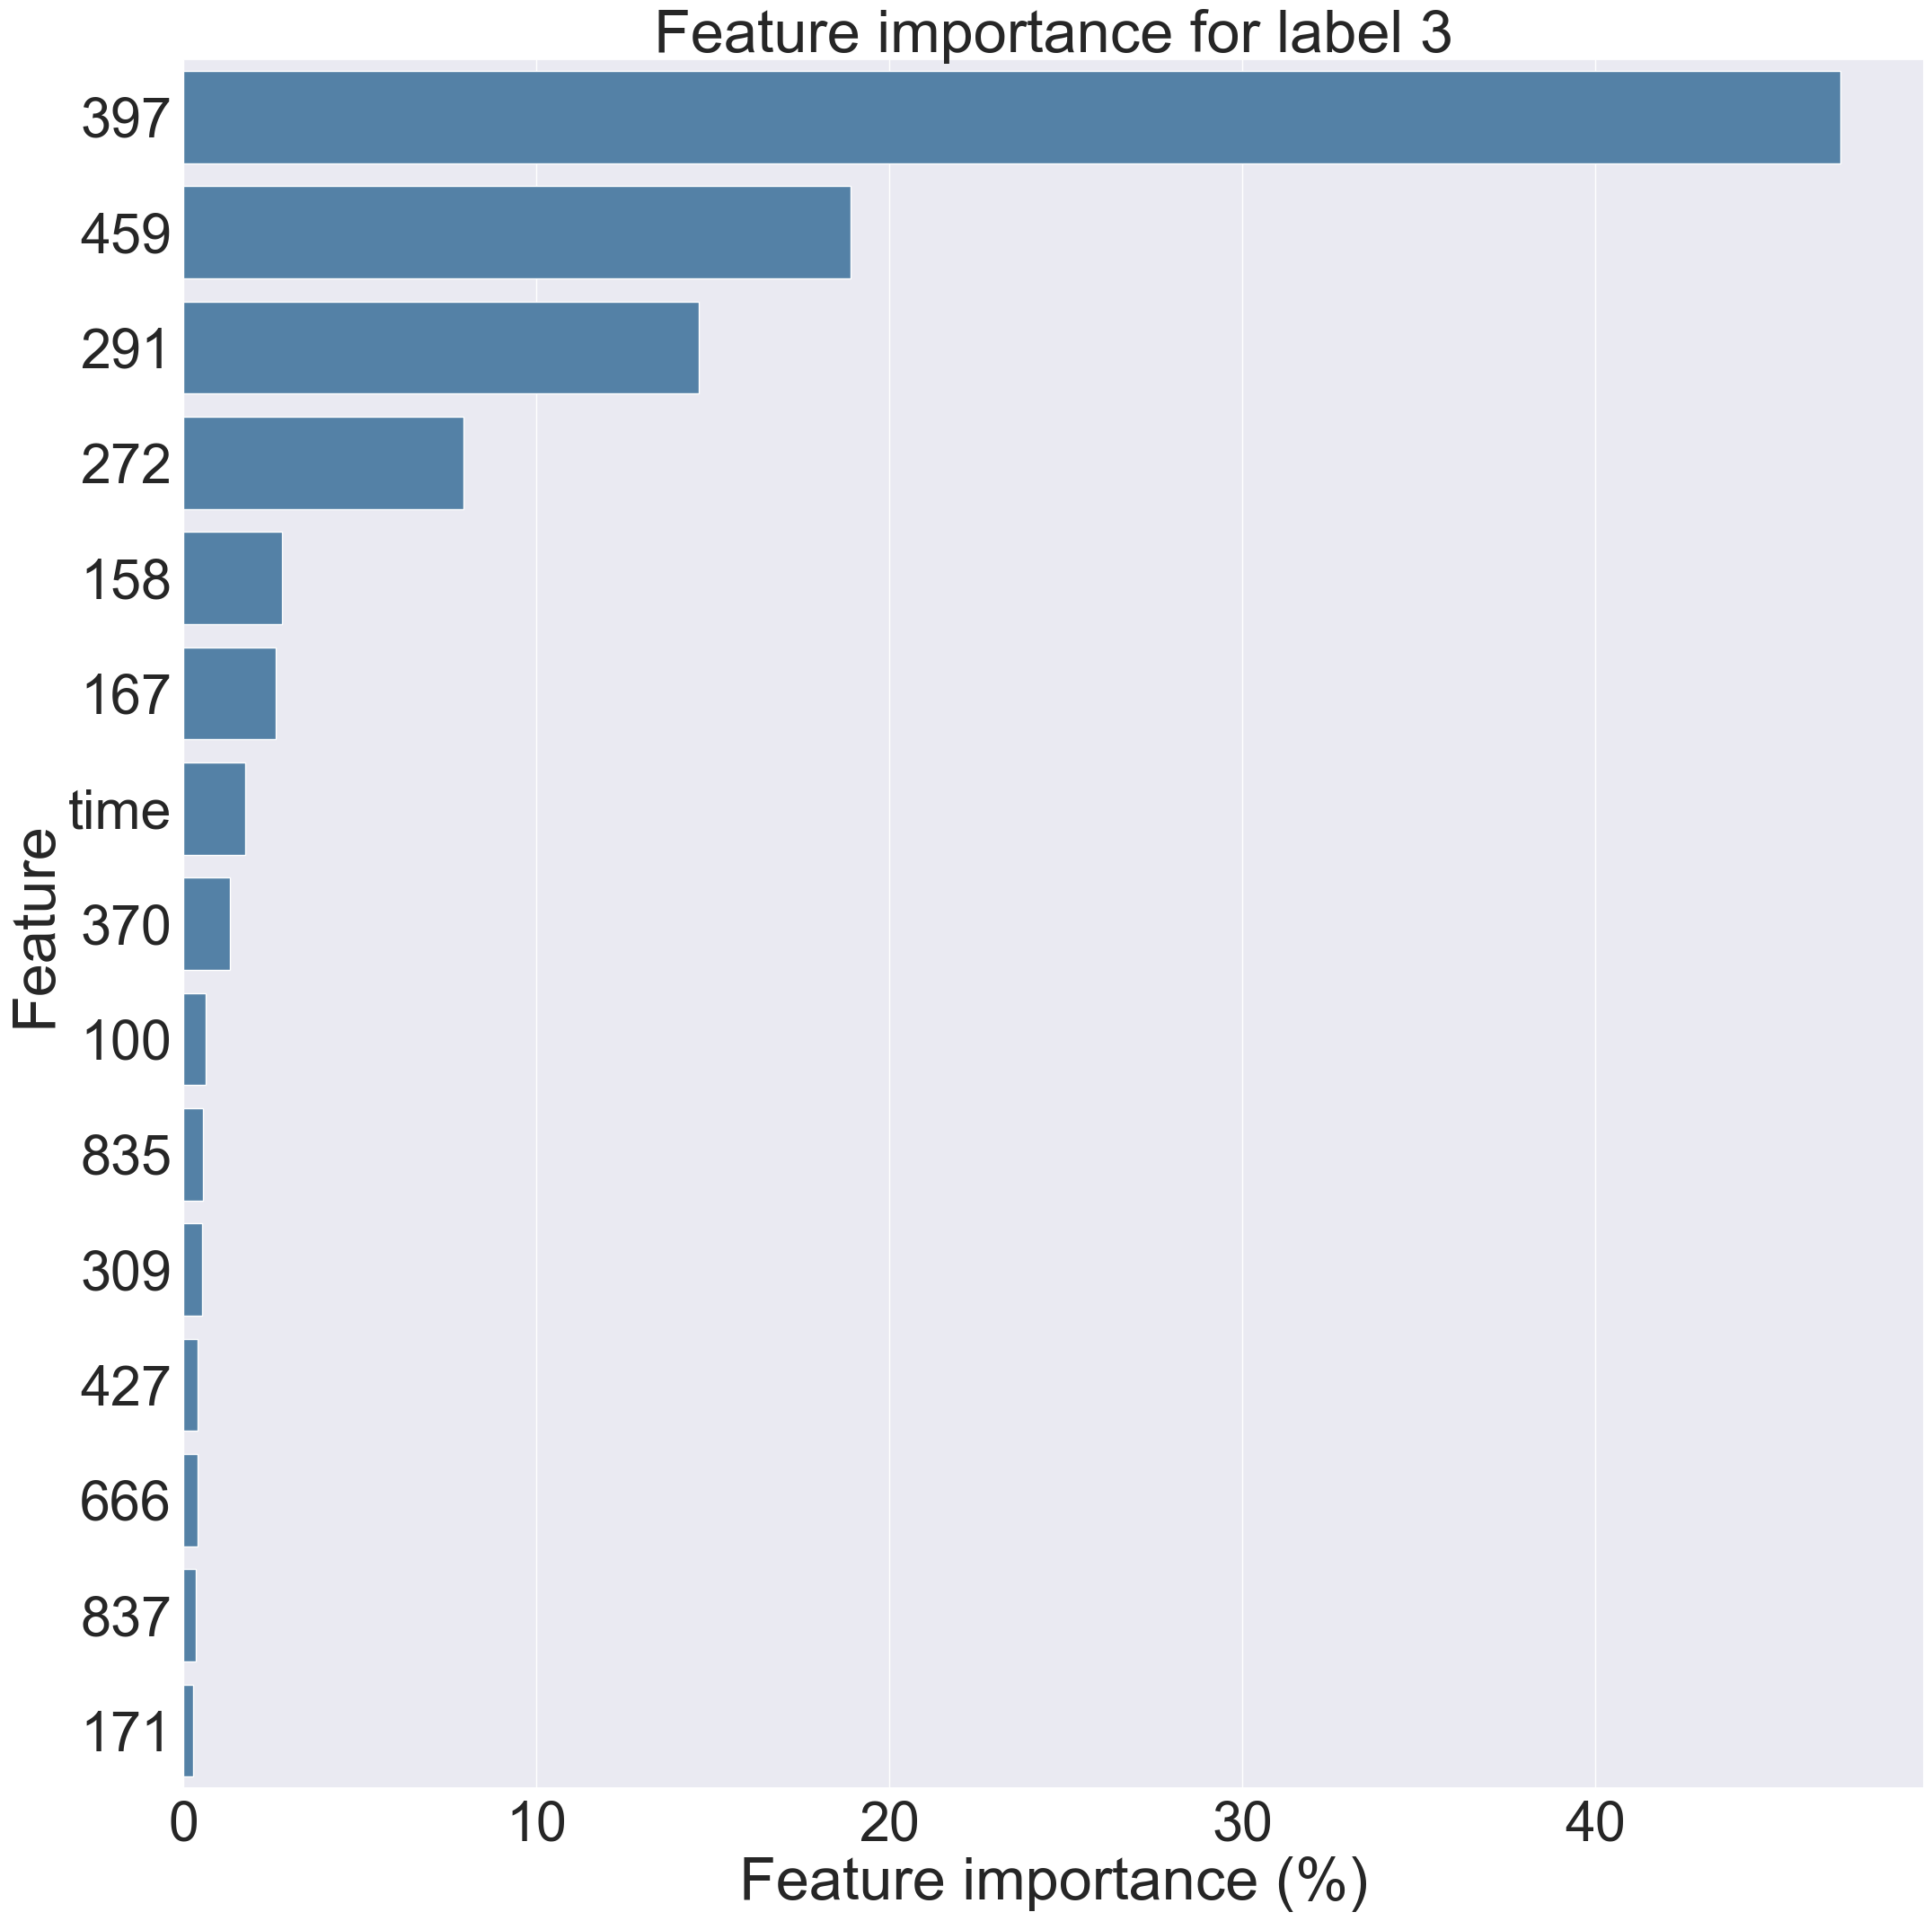

In [26]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label}')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

### True positives

In [27]:
label = 3

In [28]:
x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_tp_or_fp_label_from_loader(train_loader, label, tp=True) 

tensor([ 11, 187, 188, 189, 190, 191, 254])
tensor([ 28,  29, 129, 130, 131, 150, 151, 186, 187, 188, 189, 190, 191, 192,
        209, 210, 211, 212, 213, 214, 215, 216], device='cuda:0')
[187 188 189 190 191]


In [29]:
# test_idx = pd.Series(y_test.argmax(dim=-1).view(-1).numpy())
# test_idx = test_idx[test_idx == label].index.values.tolist()
x_test.shape

torch.Size([5, 200, 106])

In [30]:
explanation = get_lime_explanations(x_train, y_train, x_test[:10].numpy(), feature_names, ['0','1','2','3','4'], model)

In [31]:
explanation

In [32]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [33]:
feature_importance

feature timestamp         value
0       feature_14       t-1  4.543268e-04
1       feature_70      t-16 -4.260444e-04
2       feature_14       t-4  4.135118e-04
3      feature_105       t-8  4.124854e-04
4       feature_14       t-0  4.068916e-04
...            ...       ...           ...
21195   feature_96     t-147  8.908435e-09
21196   feature_62     t-167 -7.154619e-09
21197    feature_7      t-85  5.722049e-09
21198   feature_25      t-87  3.371237e-09
21199   feature_74     t-120 -2.846089e-09

[106000 rows x 3 columns]

In [34]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

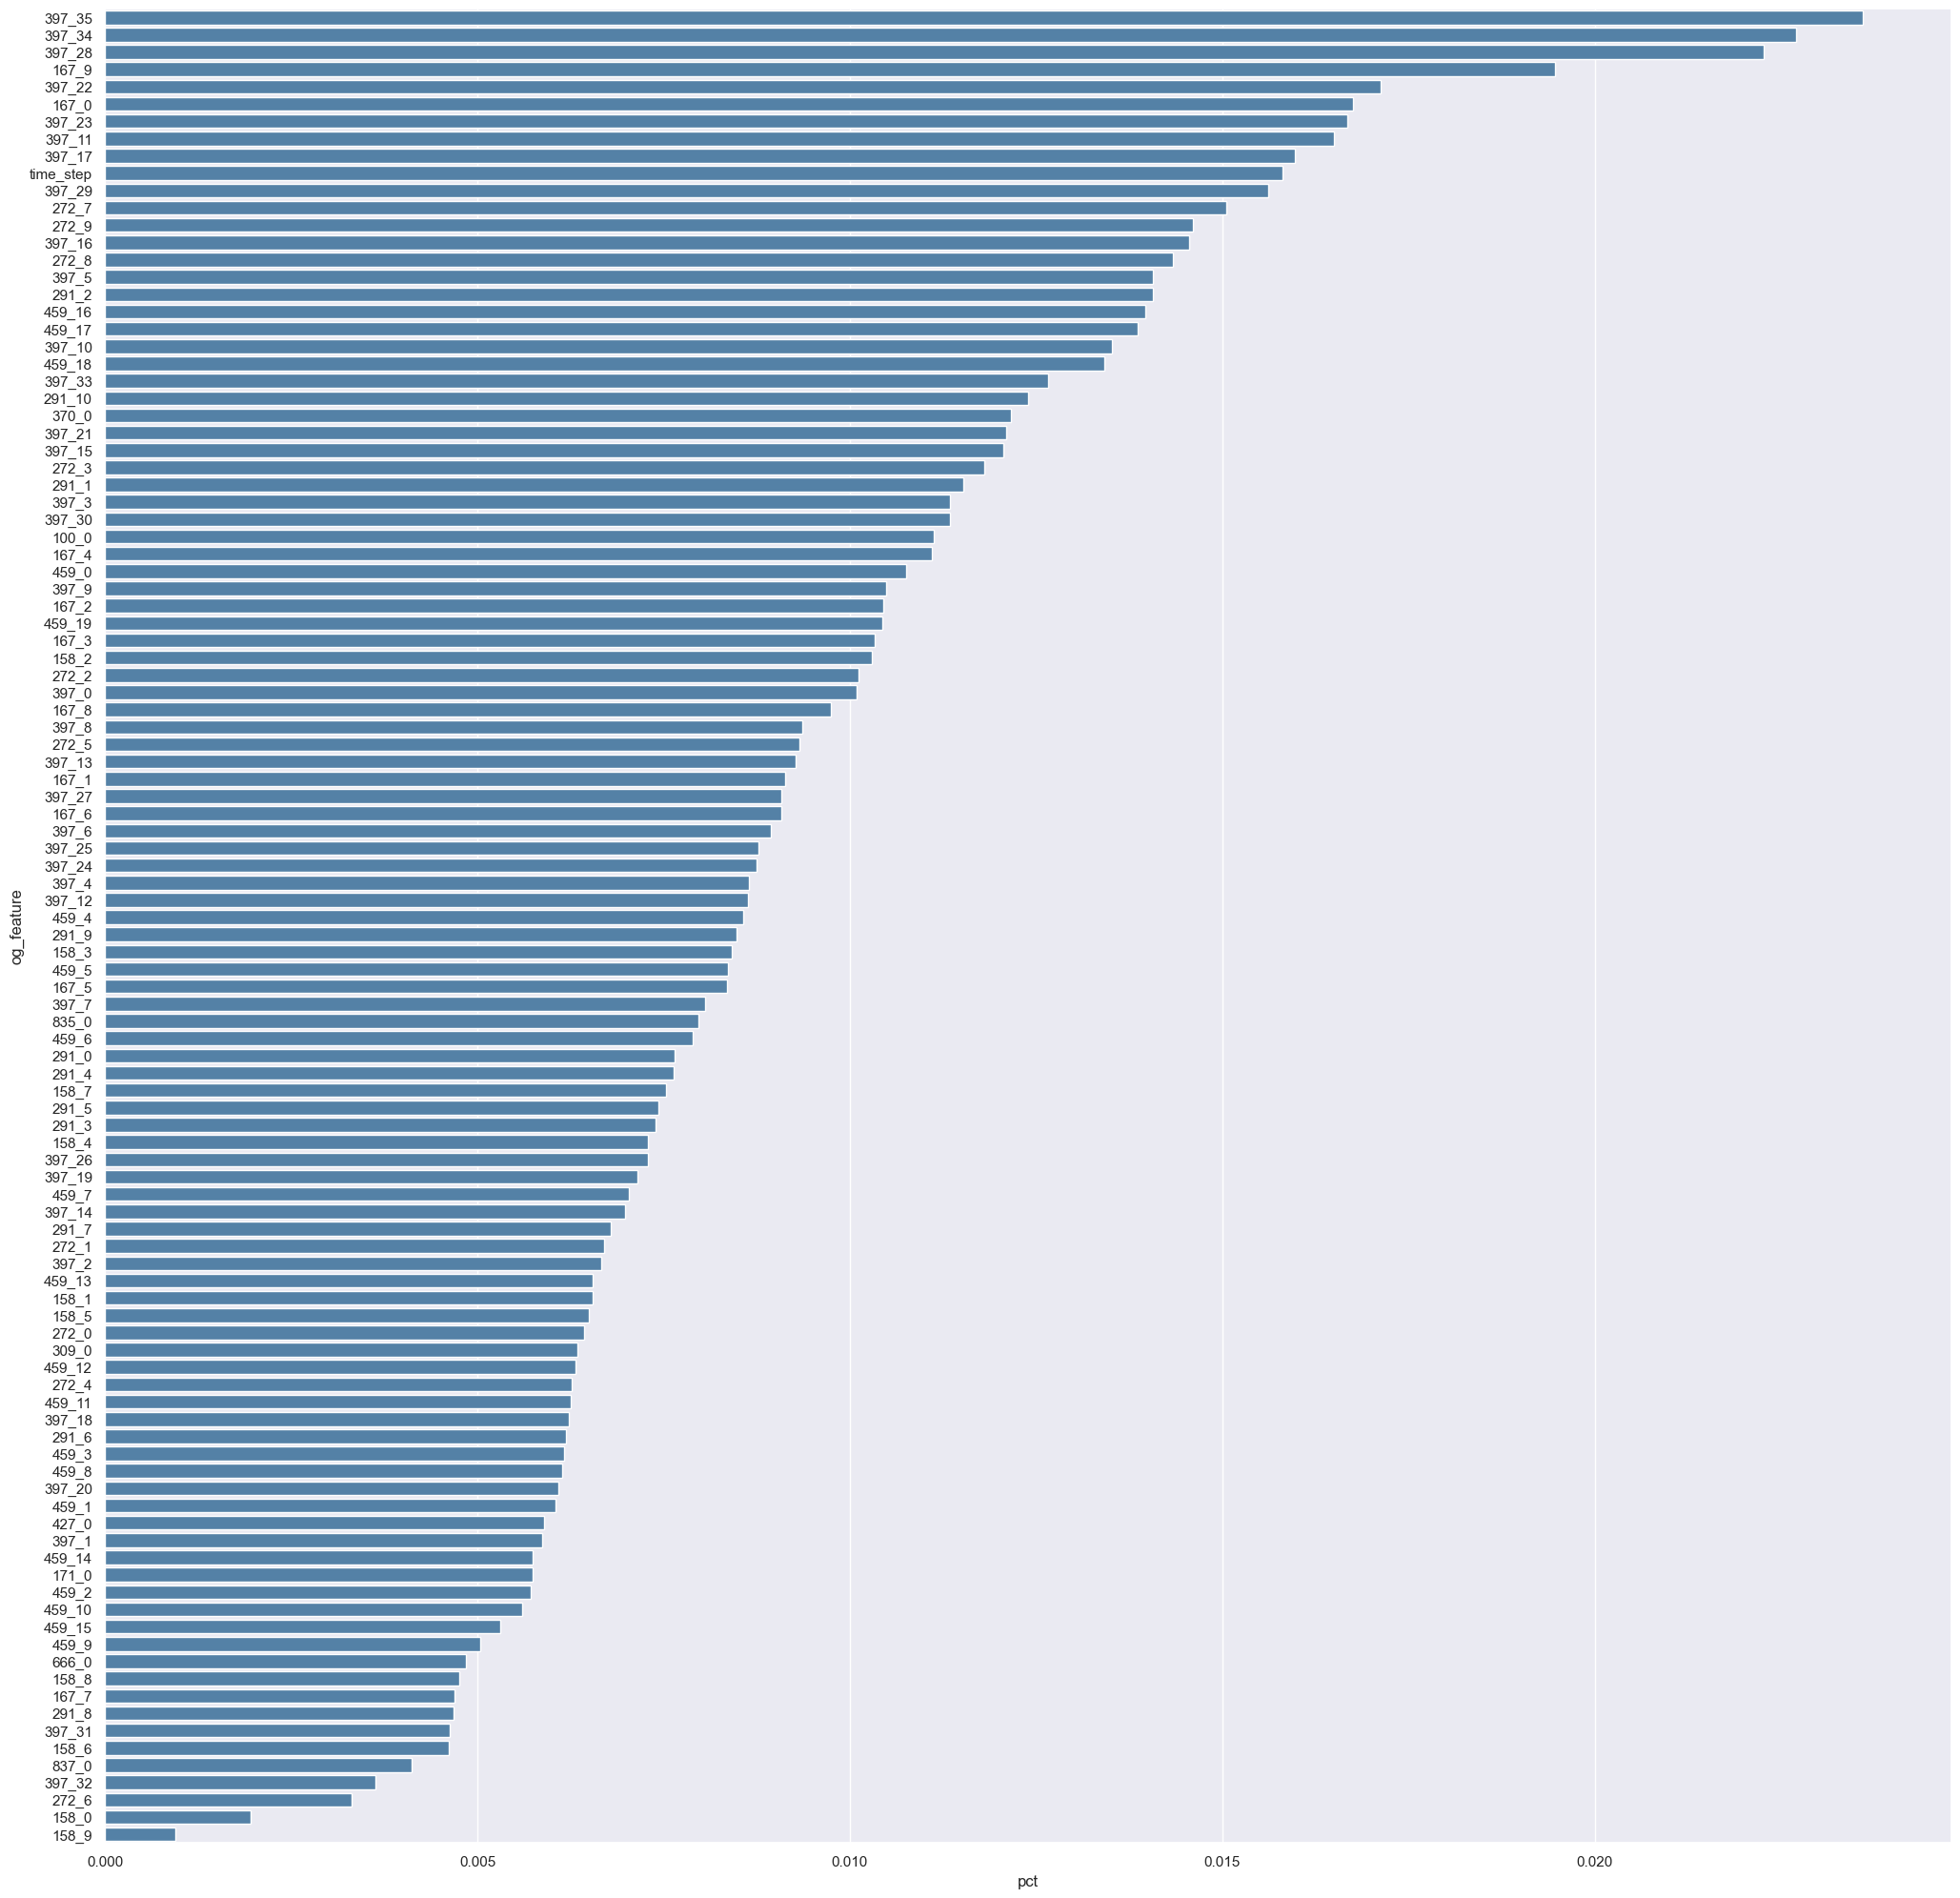

In [35]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum()
plt.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [36]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [37]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').sum().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

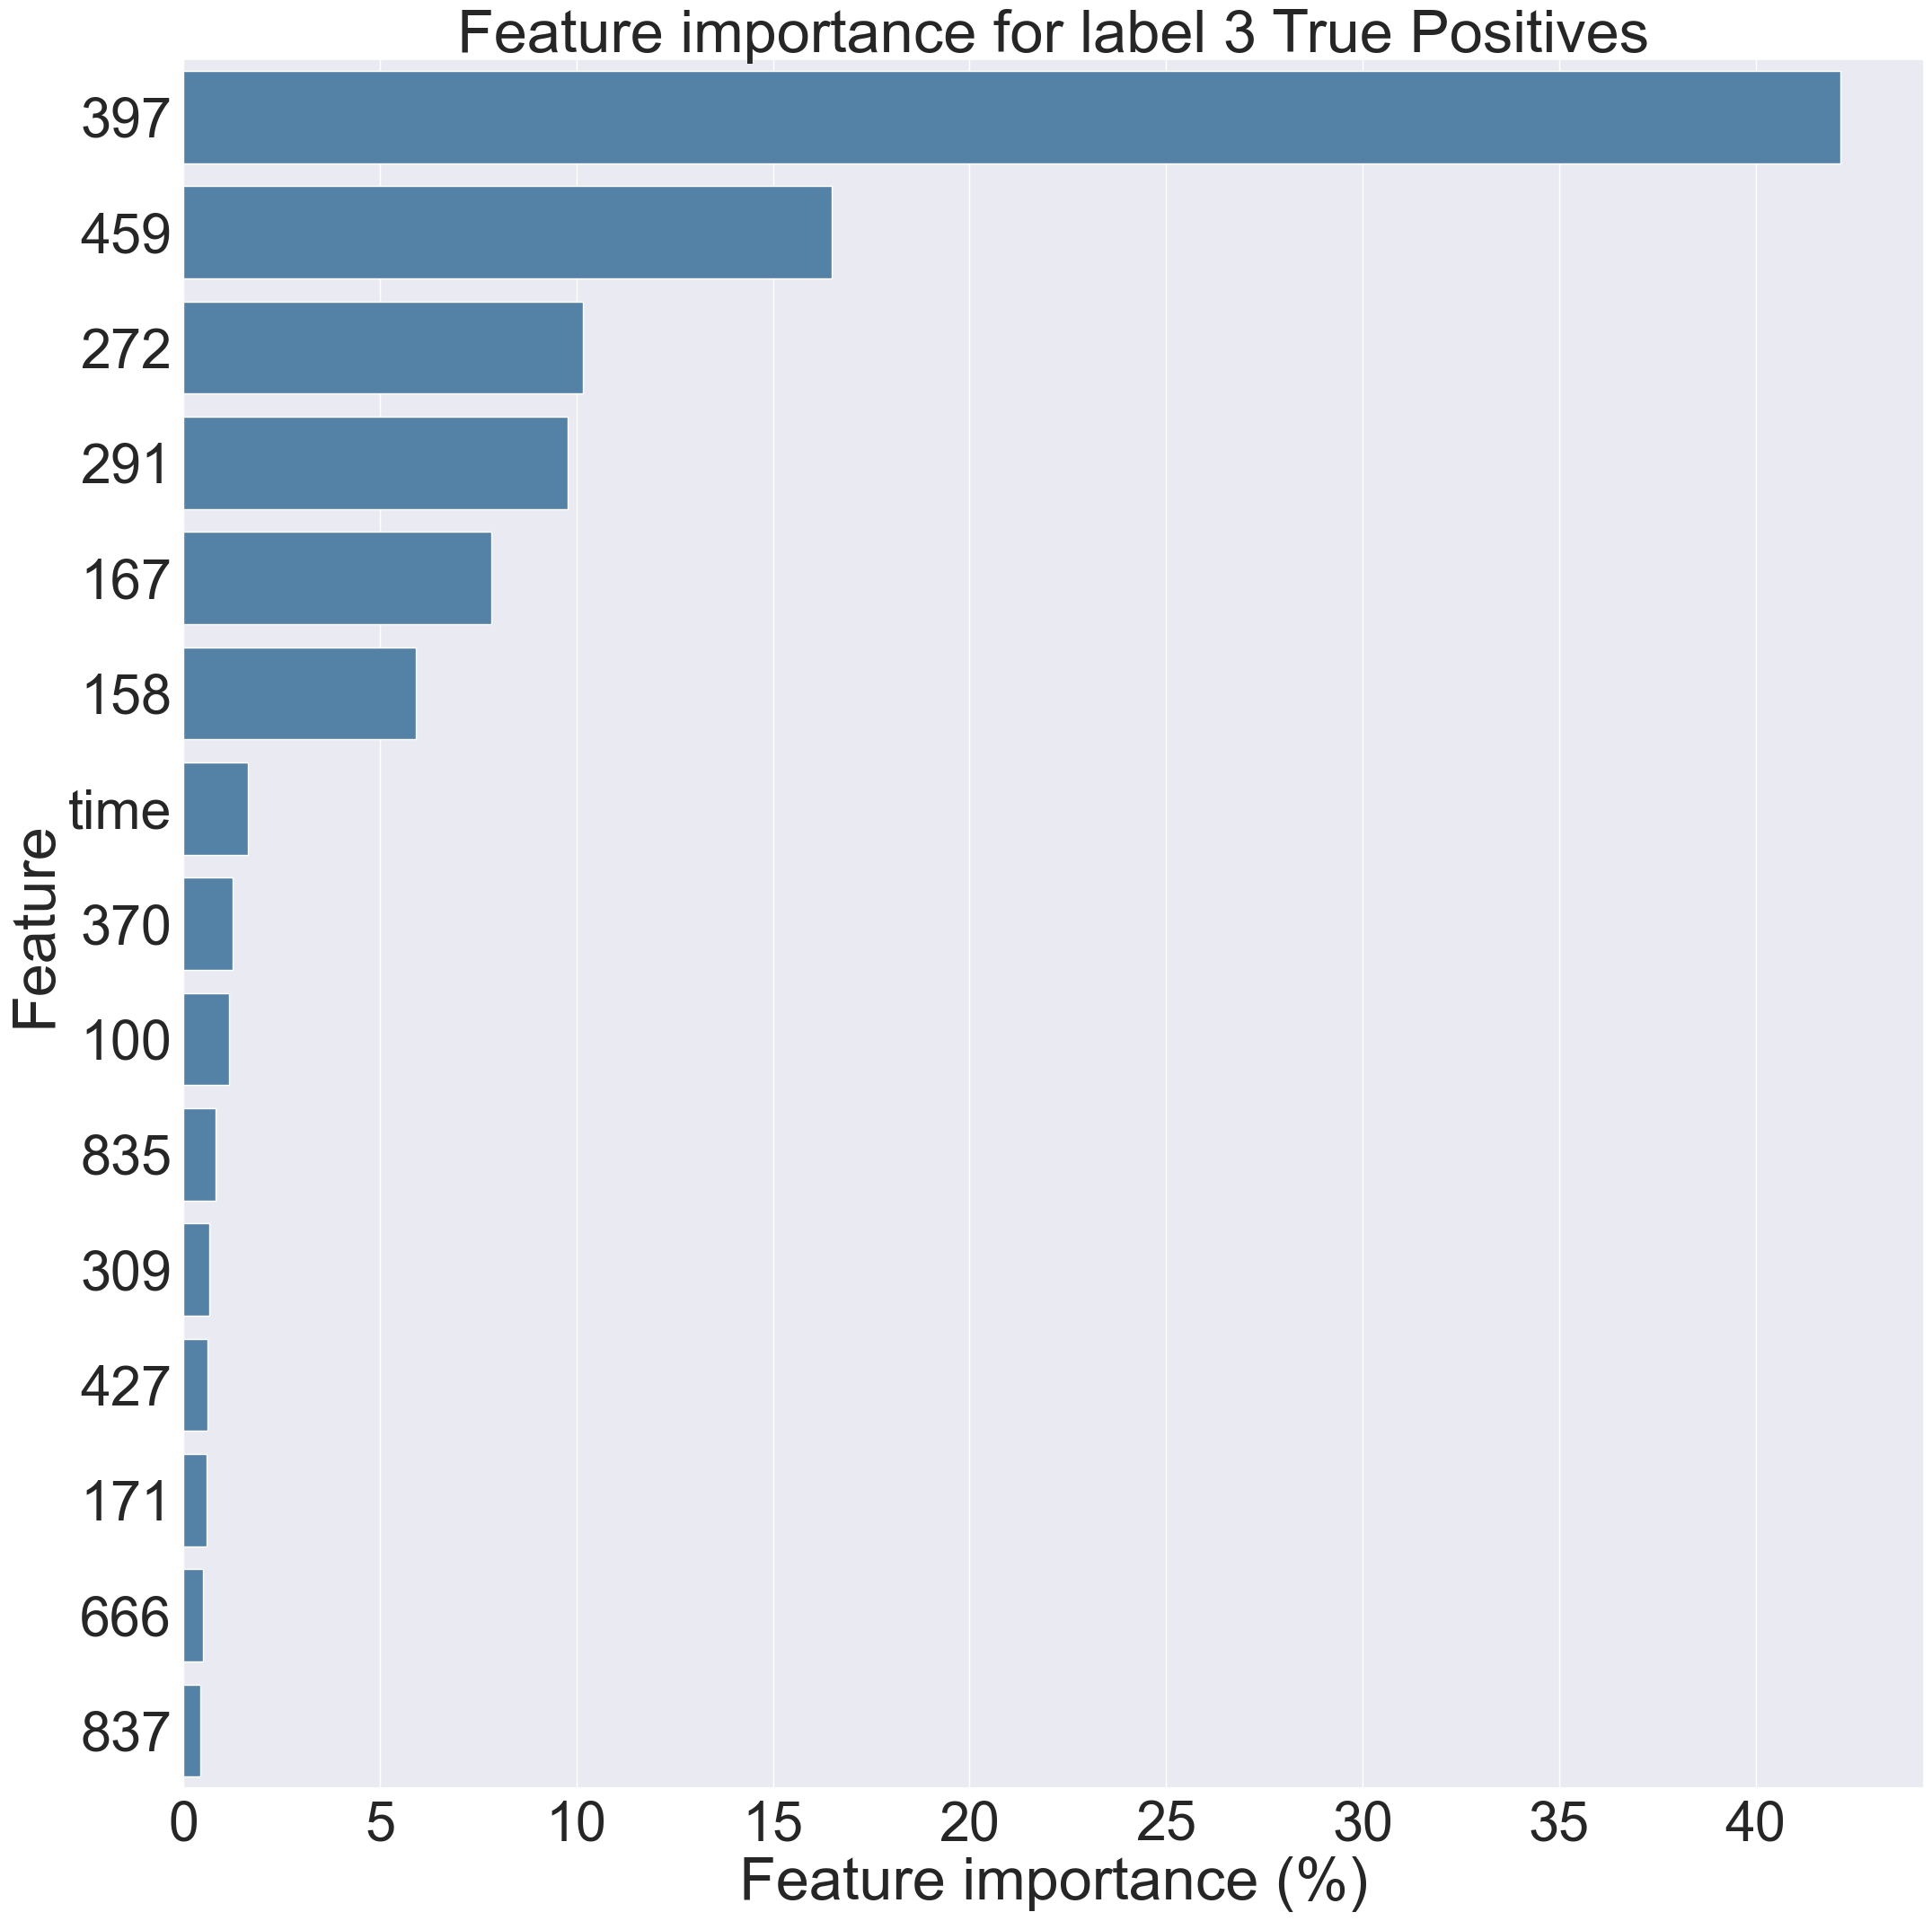

In [38]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label} True Positives')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

### False positive

In [39]:
label = 3

In [40]:
x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_tp_or_fp_label_from_loader(valid_loader, label, tp=False) 

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [41]:
# test_idx = pd.Series(y_test.argmax(dim=-1).view(-1).numpy())
# test_idx = test_idx[test_idx == label].index.values.tolist()
x_test.shape

torch.Size([9, 200, 106])

In [42]:
explanation = get_lime_explanations(x_train, y_train, x_test[:10].numpy(), feature_names, ['0','1','2','3','4'], model)

In [43]:
explanation

In [44]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [45]:
feature_importance

feature timestamp         value
0       feature_58      t-33 -2.910413e-04
1       feature_40      t-32 -2.789277e-04
2       feature_17      t-17 -2.782240e-04
3        feature_2      t-33 -2.684976e-04
4       feature_78      t-33 -2.679280e-04
...            ...       ...           ...
21195   feature_84     t-128  5.932717e-09
21196   feature_60      t-31 -5.930424e-09
21197  feature_101     t-159 -5.229507e-09
21198   feature_90     t-160 -3.299100e-09
21199   feature_36     t-194  1.324517e-09

[190800 rows x 3 columns]

In [46]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

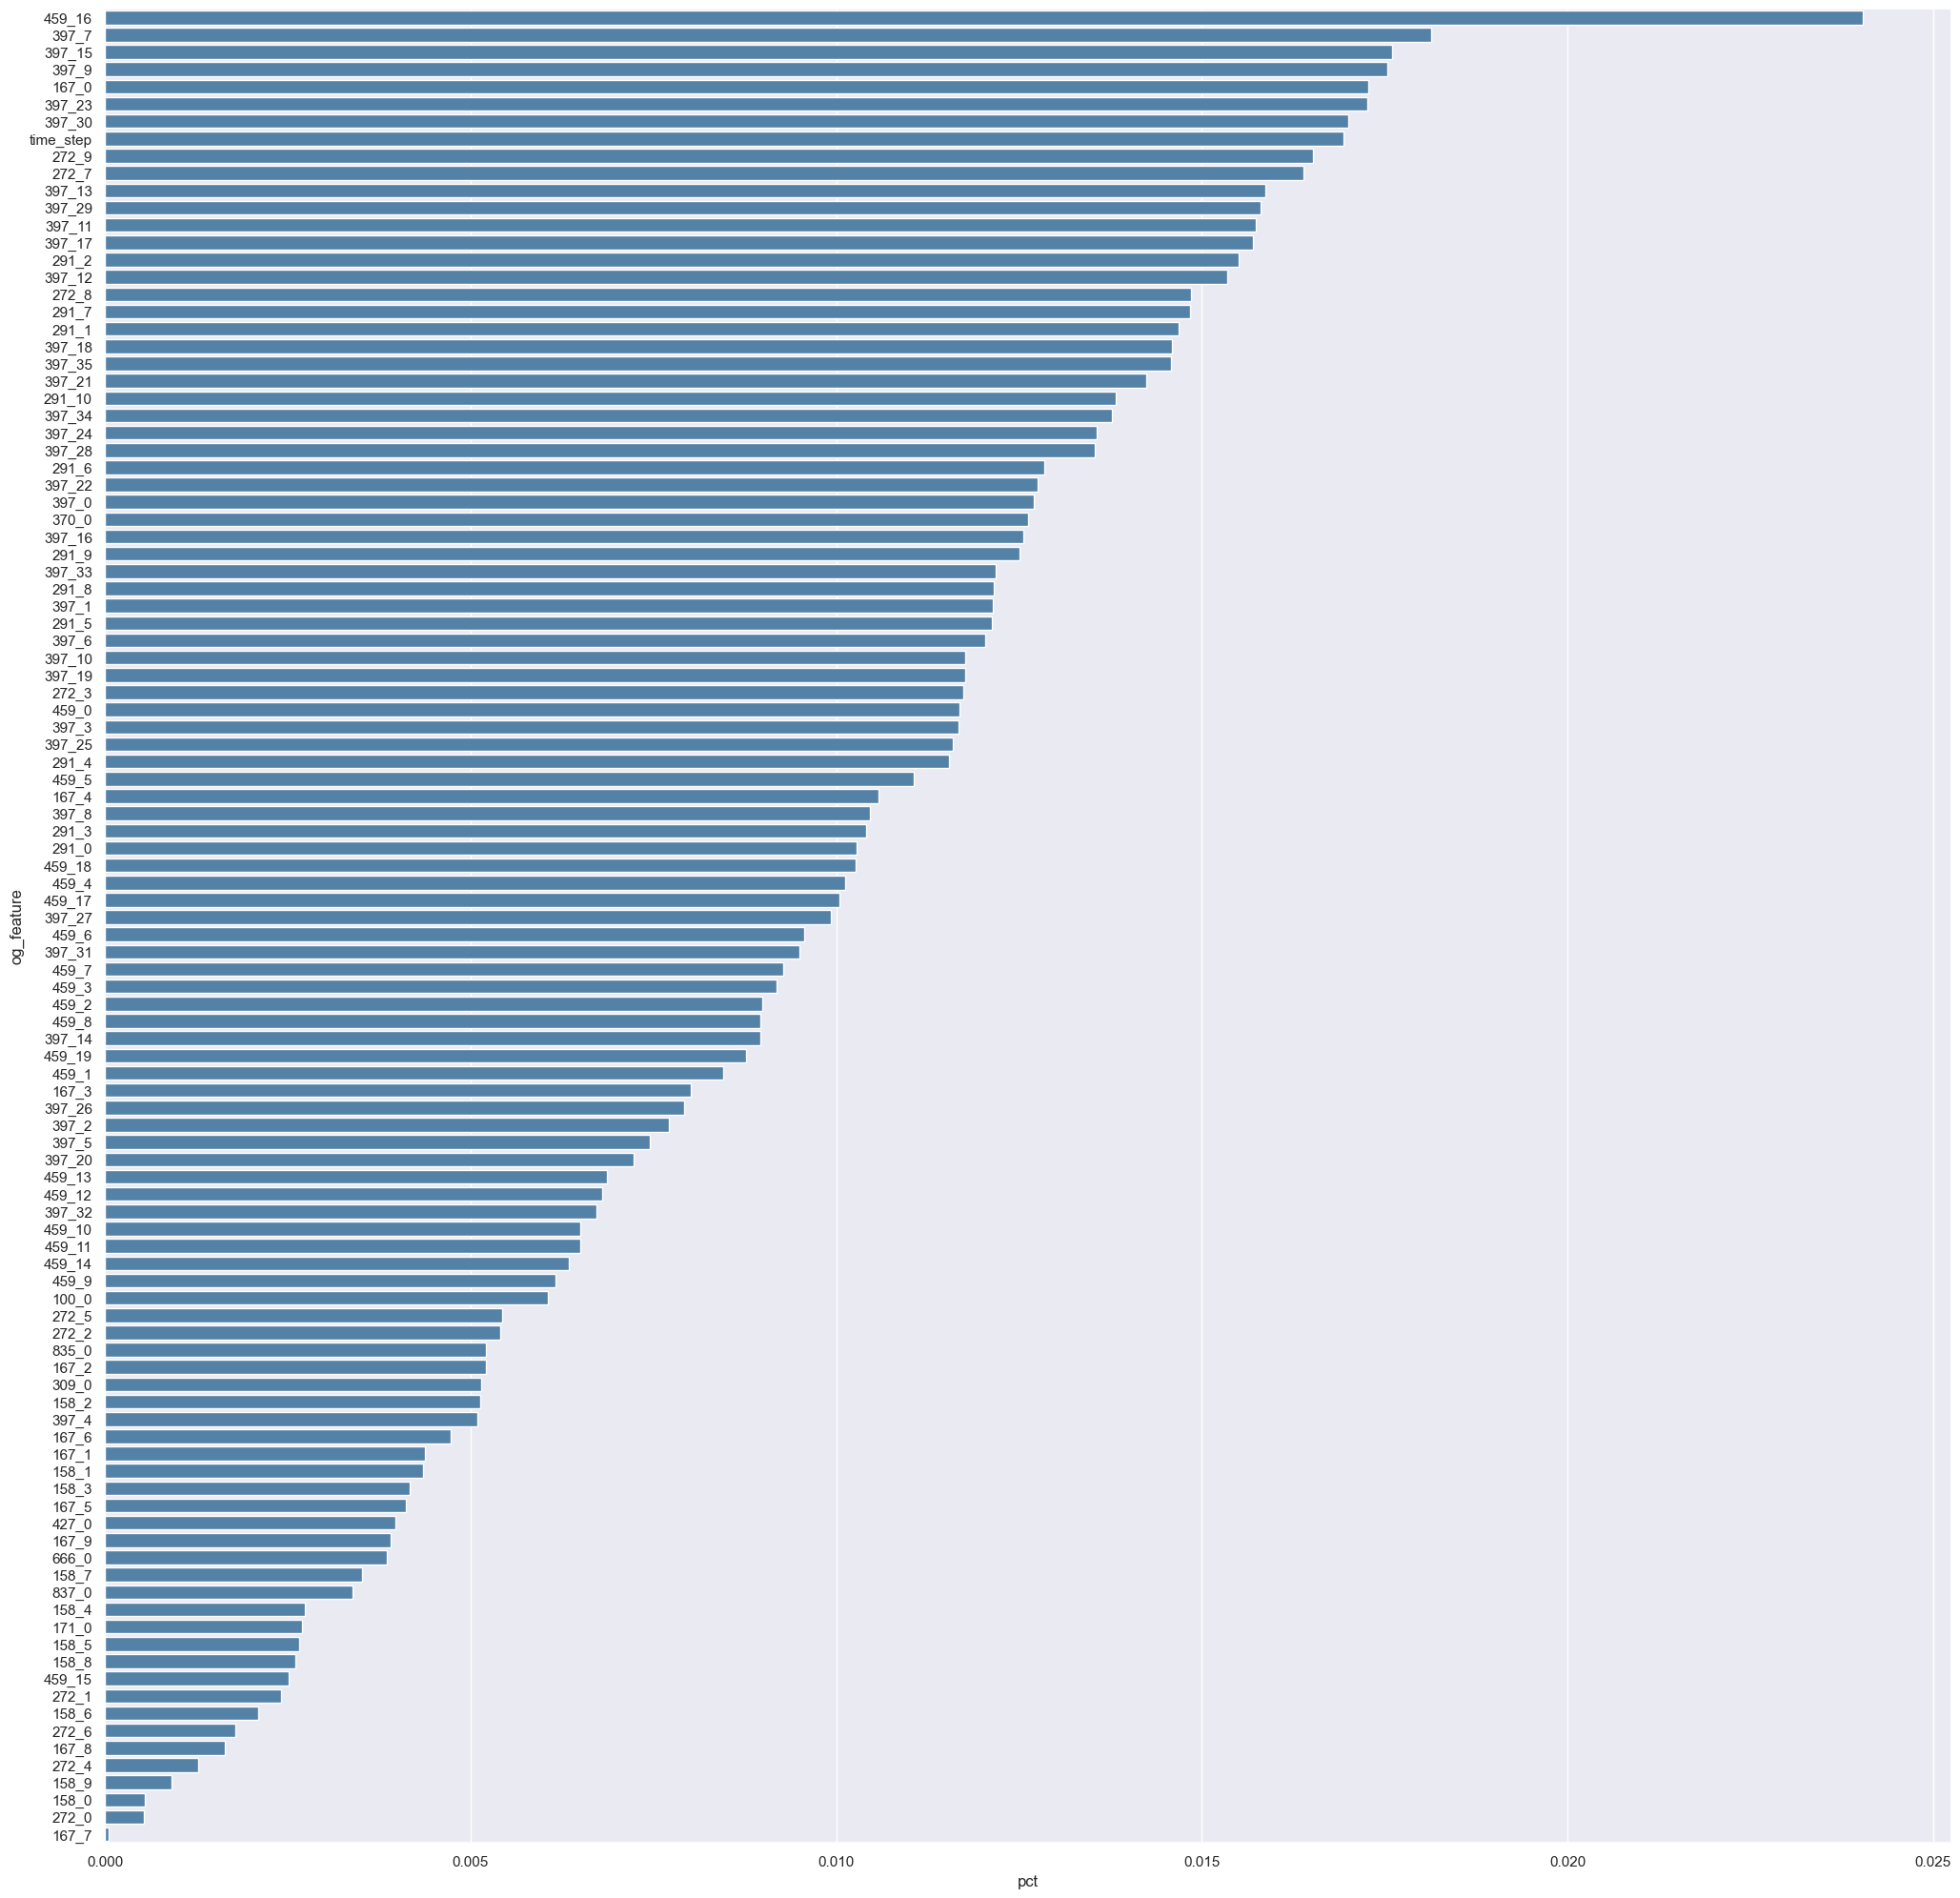

In [47]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum()
plt.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [48]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [49]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').sum().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

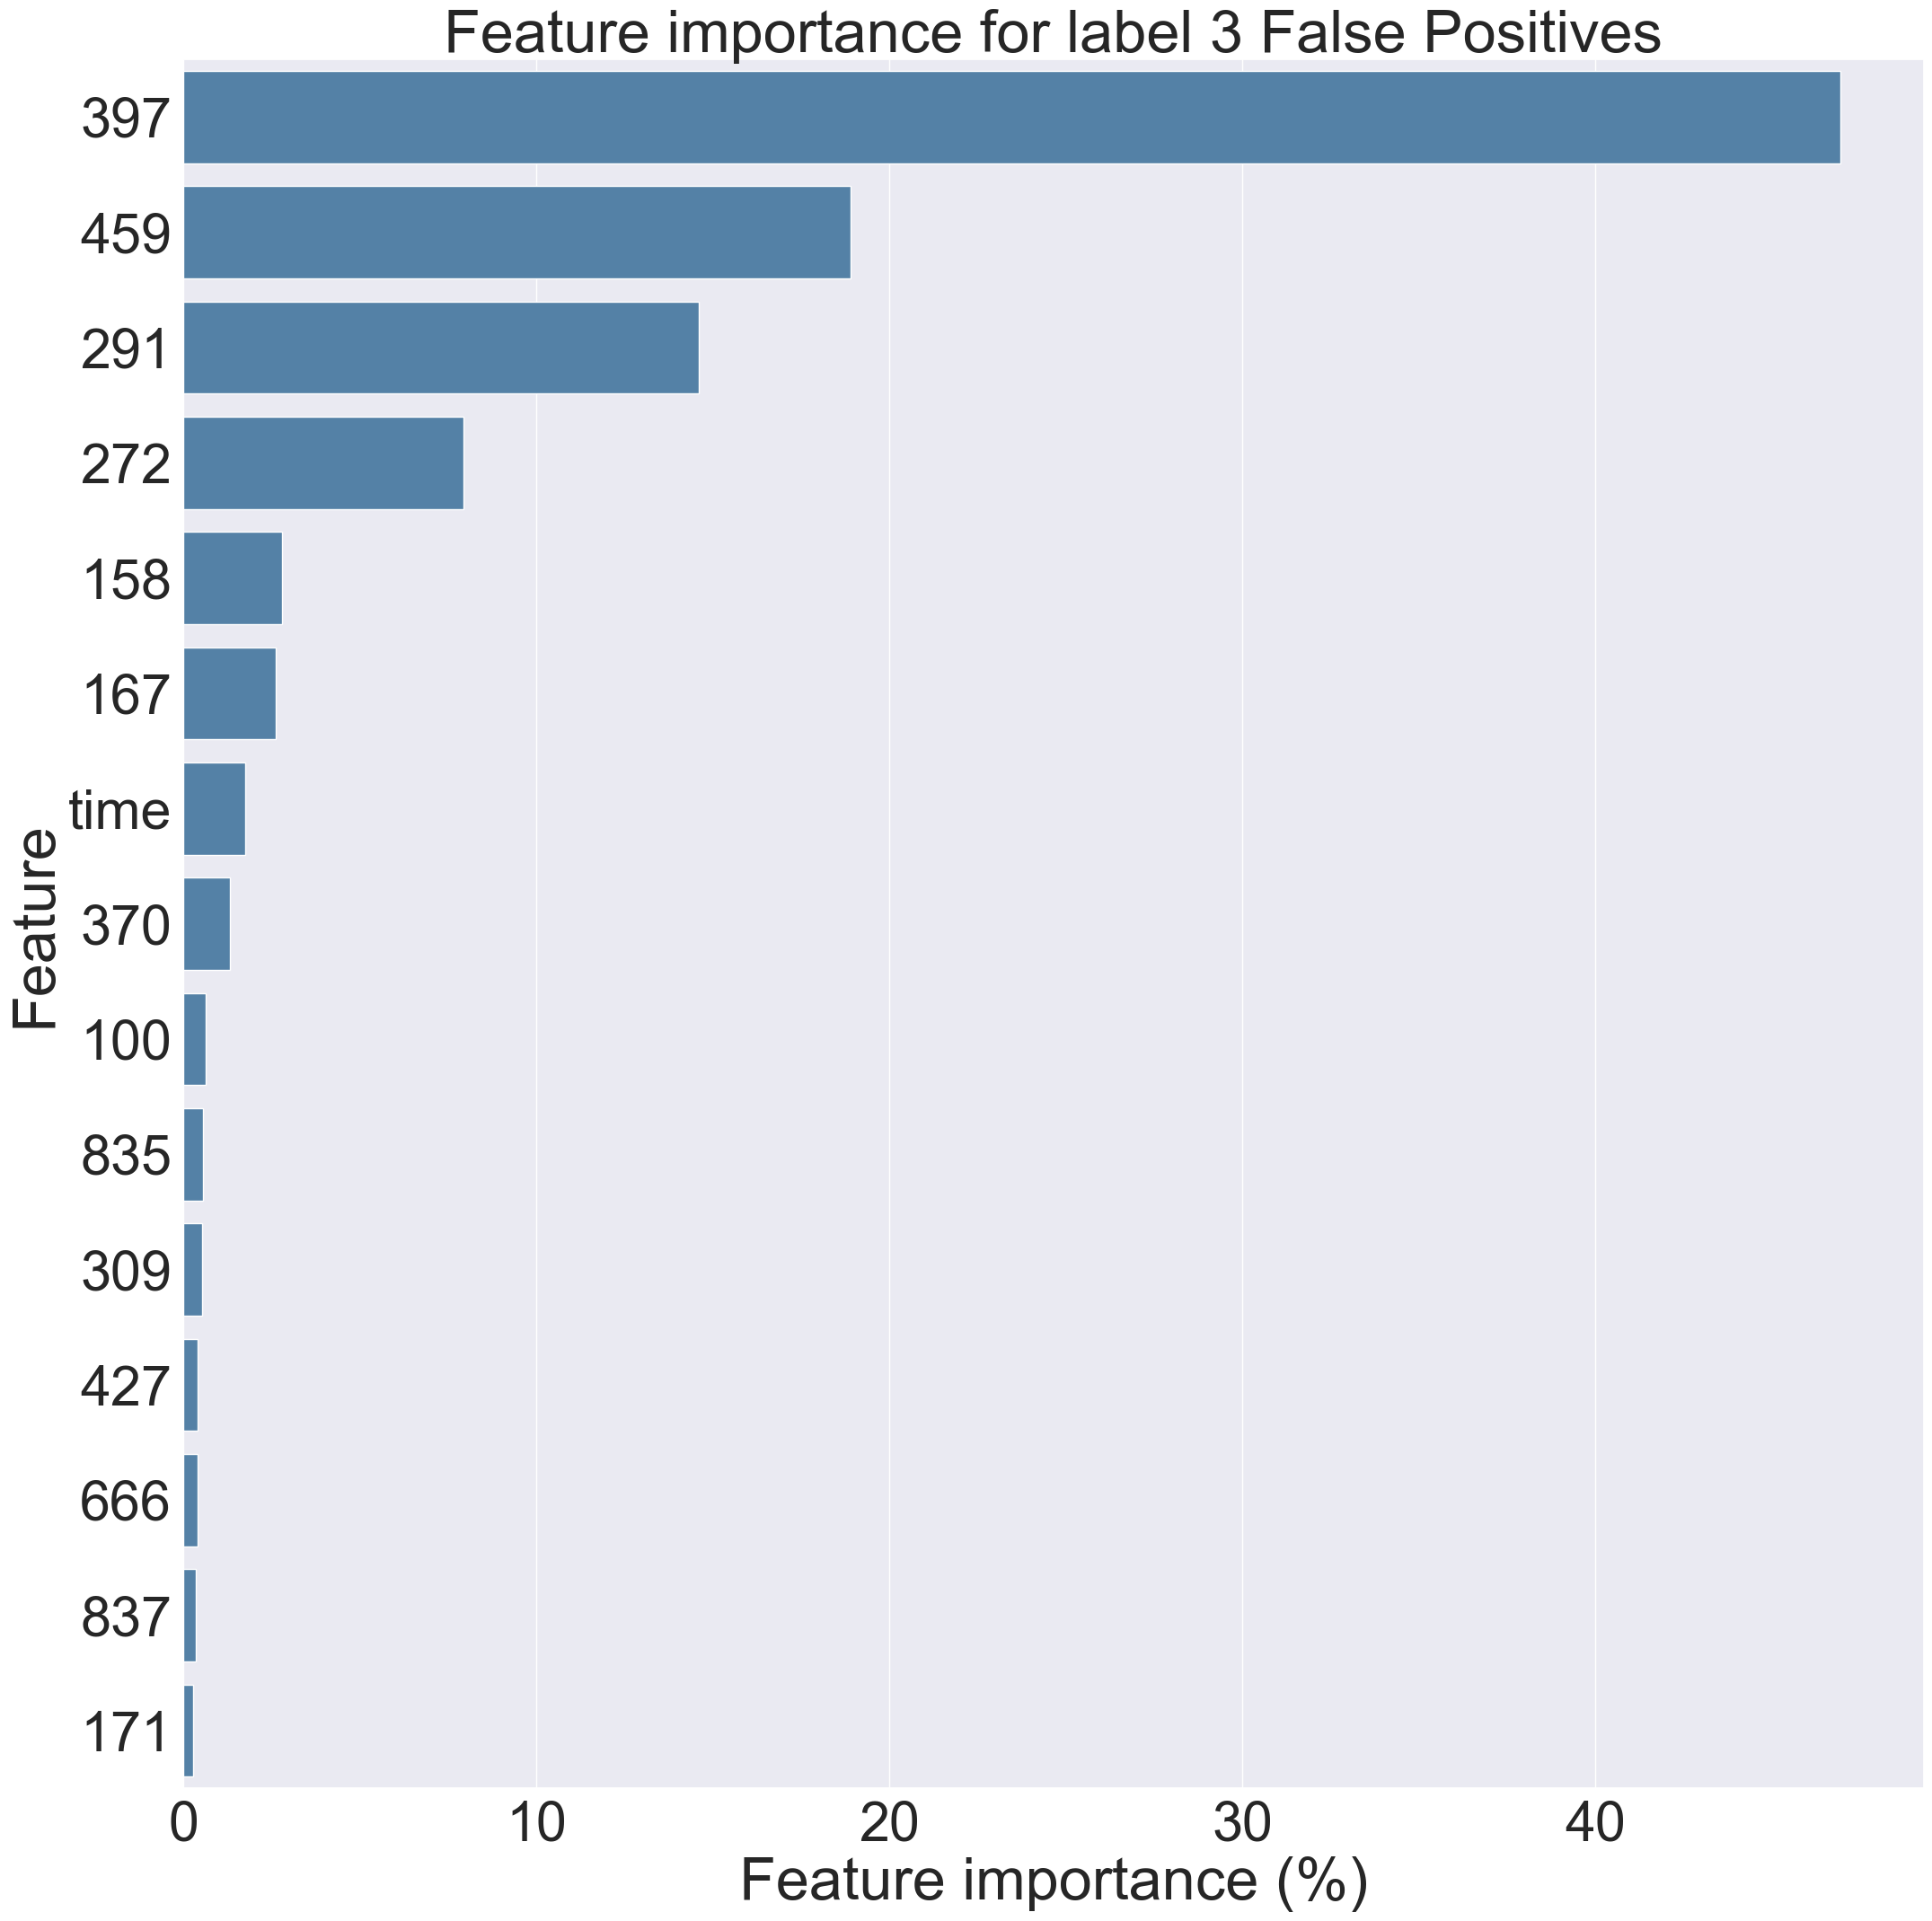

In [50]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label} False Positives')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

## LIME Label 4

### General

In [ ]:
label = 4

In [ ]:
x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_label_from_loader(valid_loader, label) 

In [ ]:
model.eval()
pred = model(x_test.to(model.device))
test_idx = pd.Series(pred.argmax(dim=-1).view(-1).cpu().numpy())
test_idx = test_idx[test_idx == label].index.values.tolist() 


In [ ]:
explanation = get_lime_explanations(x_train, y_train, x_test[test_idx[:10]].numpy(), feature_names, ['0','1','2','3','4'], model)

In [ ]:
explanation

In [ ]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [ ]:
feature_importance

feature timestamp         value
0       feature_58      t-33 -1.895217e-04
1       feature_78      t-33 -1.805698e-04
2       feature_40      t-32 -1.797364e-04
3        feature_2      t-33 -1.744637e-04
4       feature_36      t-32 -1.700570e-04
...            ...       ...           ...
21195   feature_20      t-93 -1.898972e-08
21196   feature_48     t-125  1.827118e-08
21197  feature_100     t-126  1.341418e-08
21198   feature_32     t-181 -5.162472e-09
21199   feature_20      t-29  3.003840e-09

[190800 rows x 3 columns]

In [ ]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

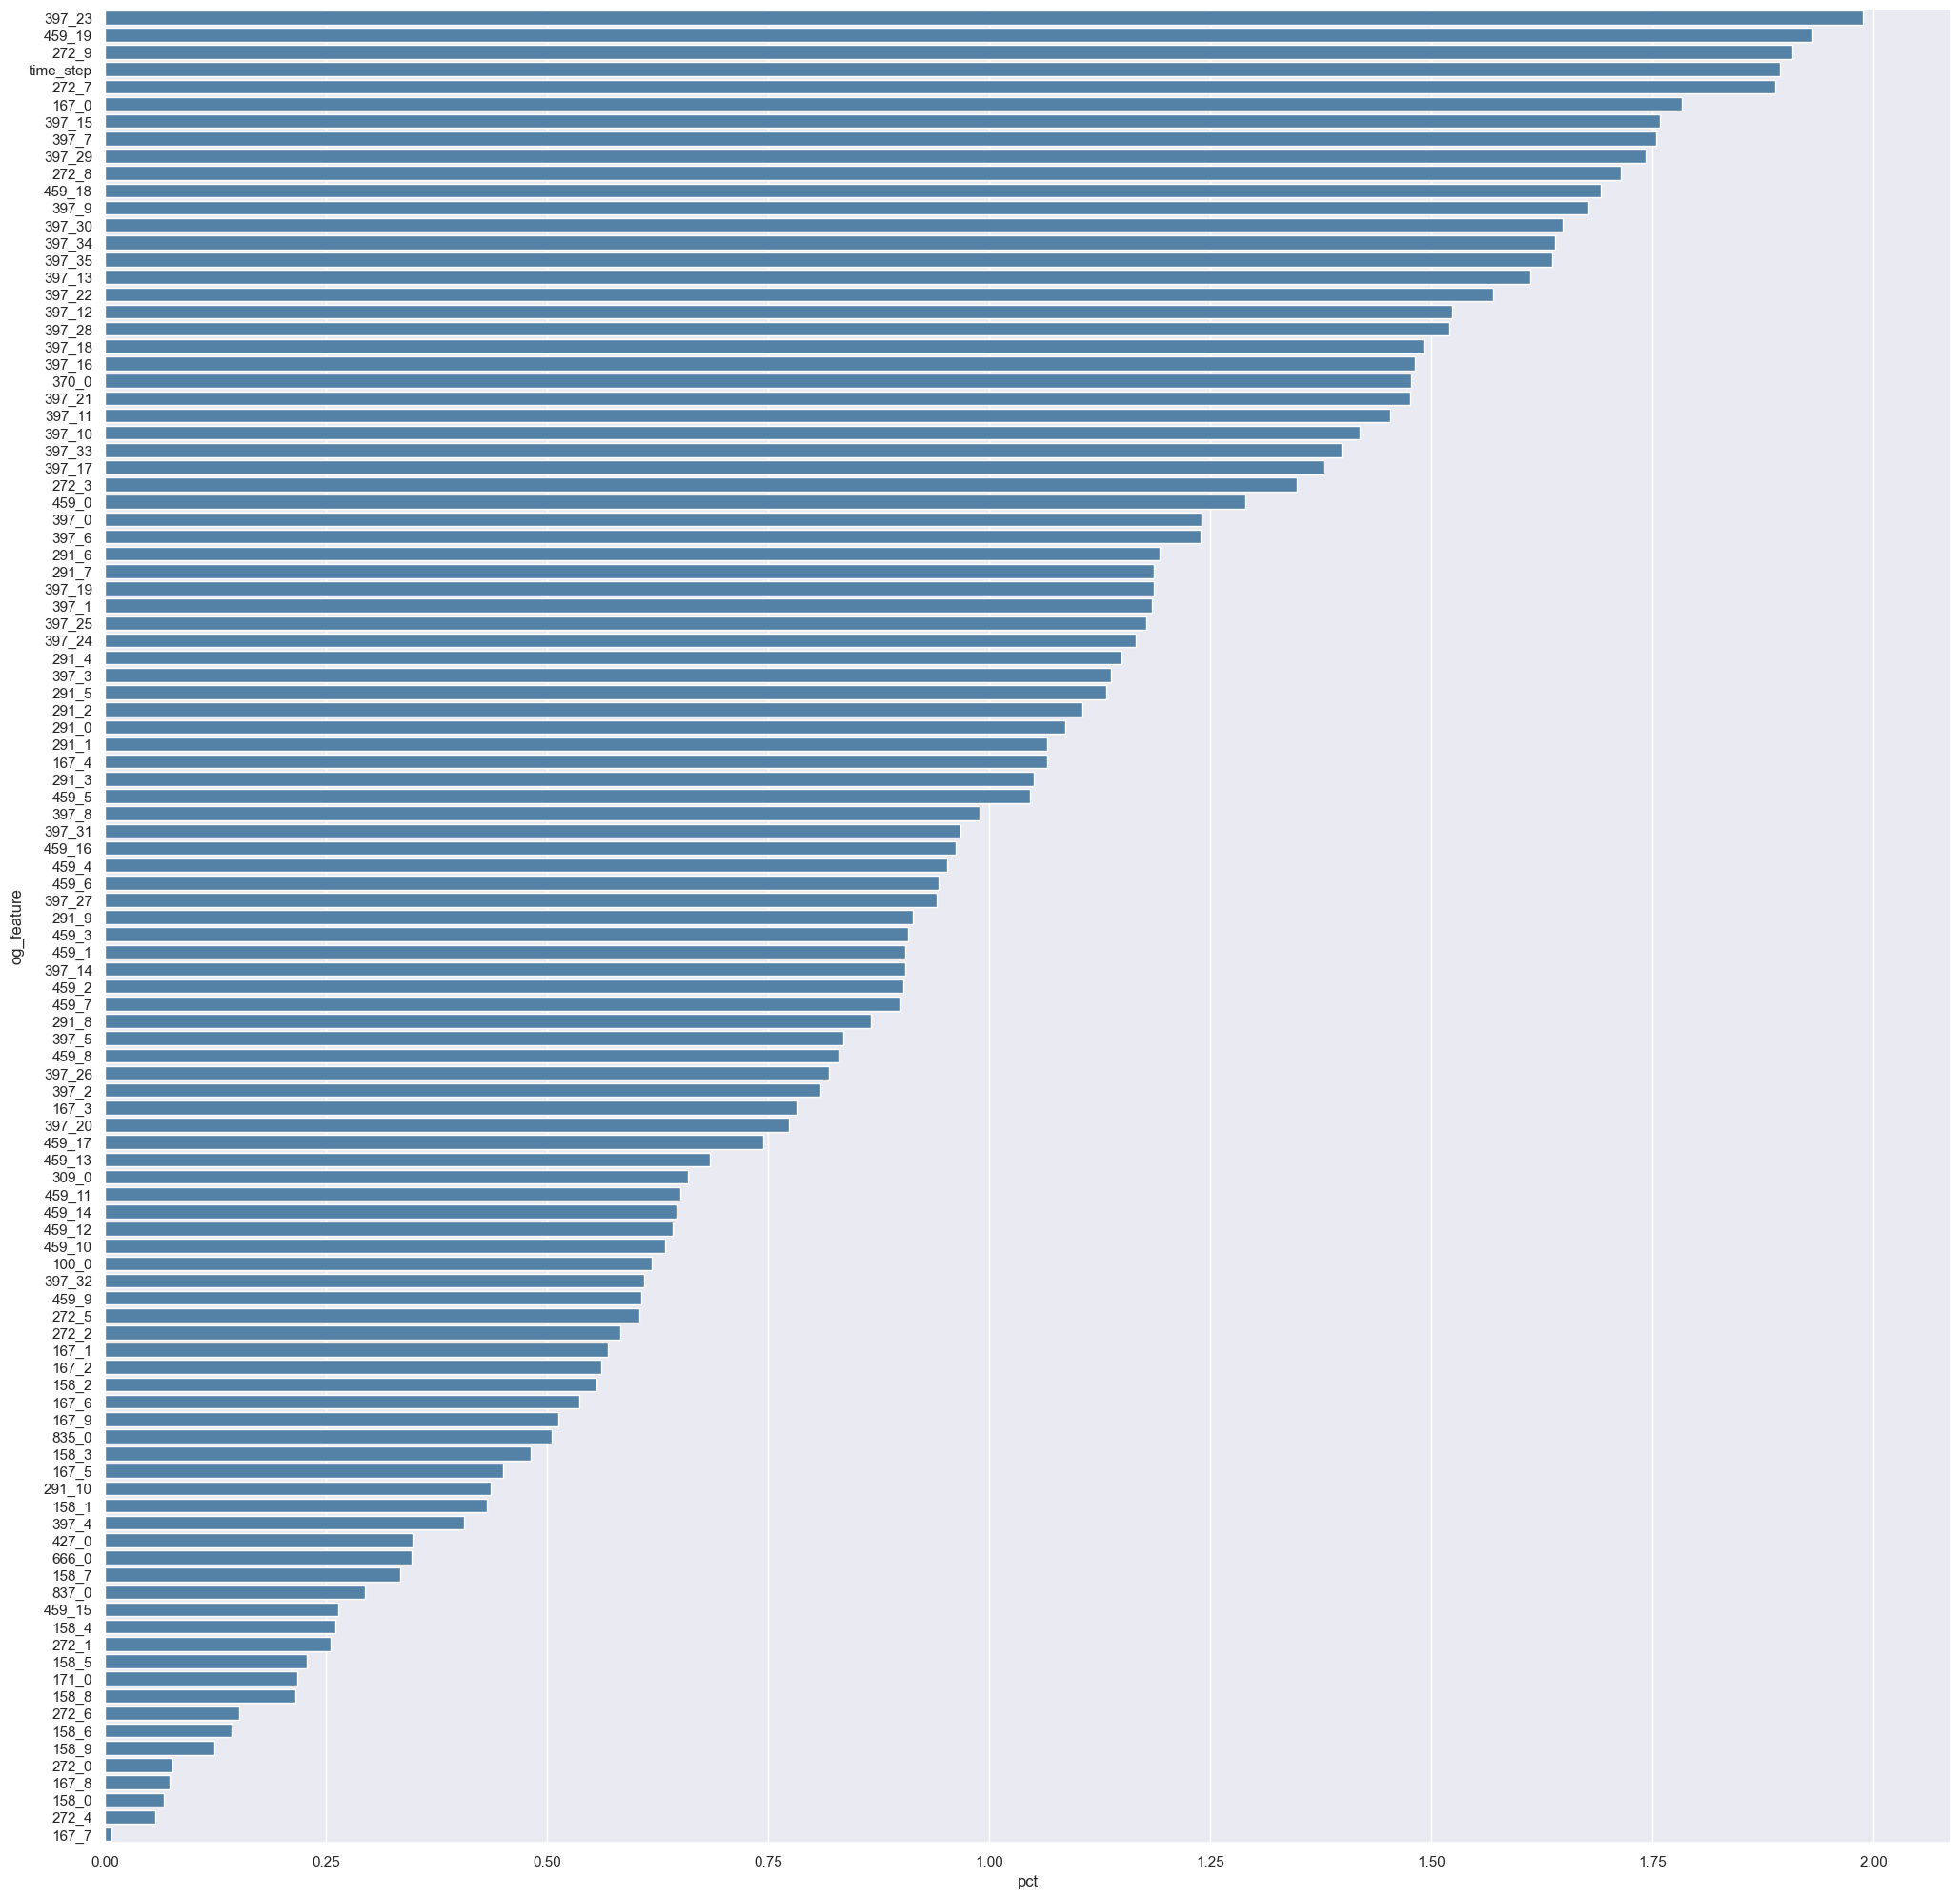

In [ ]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
plt.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [ ]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [ ]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').sum().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

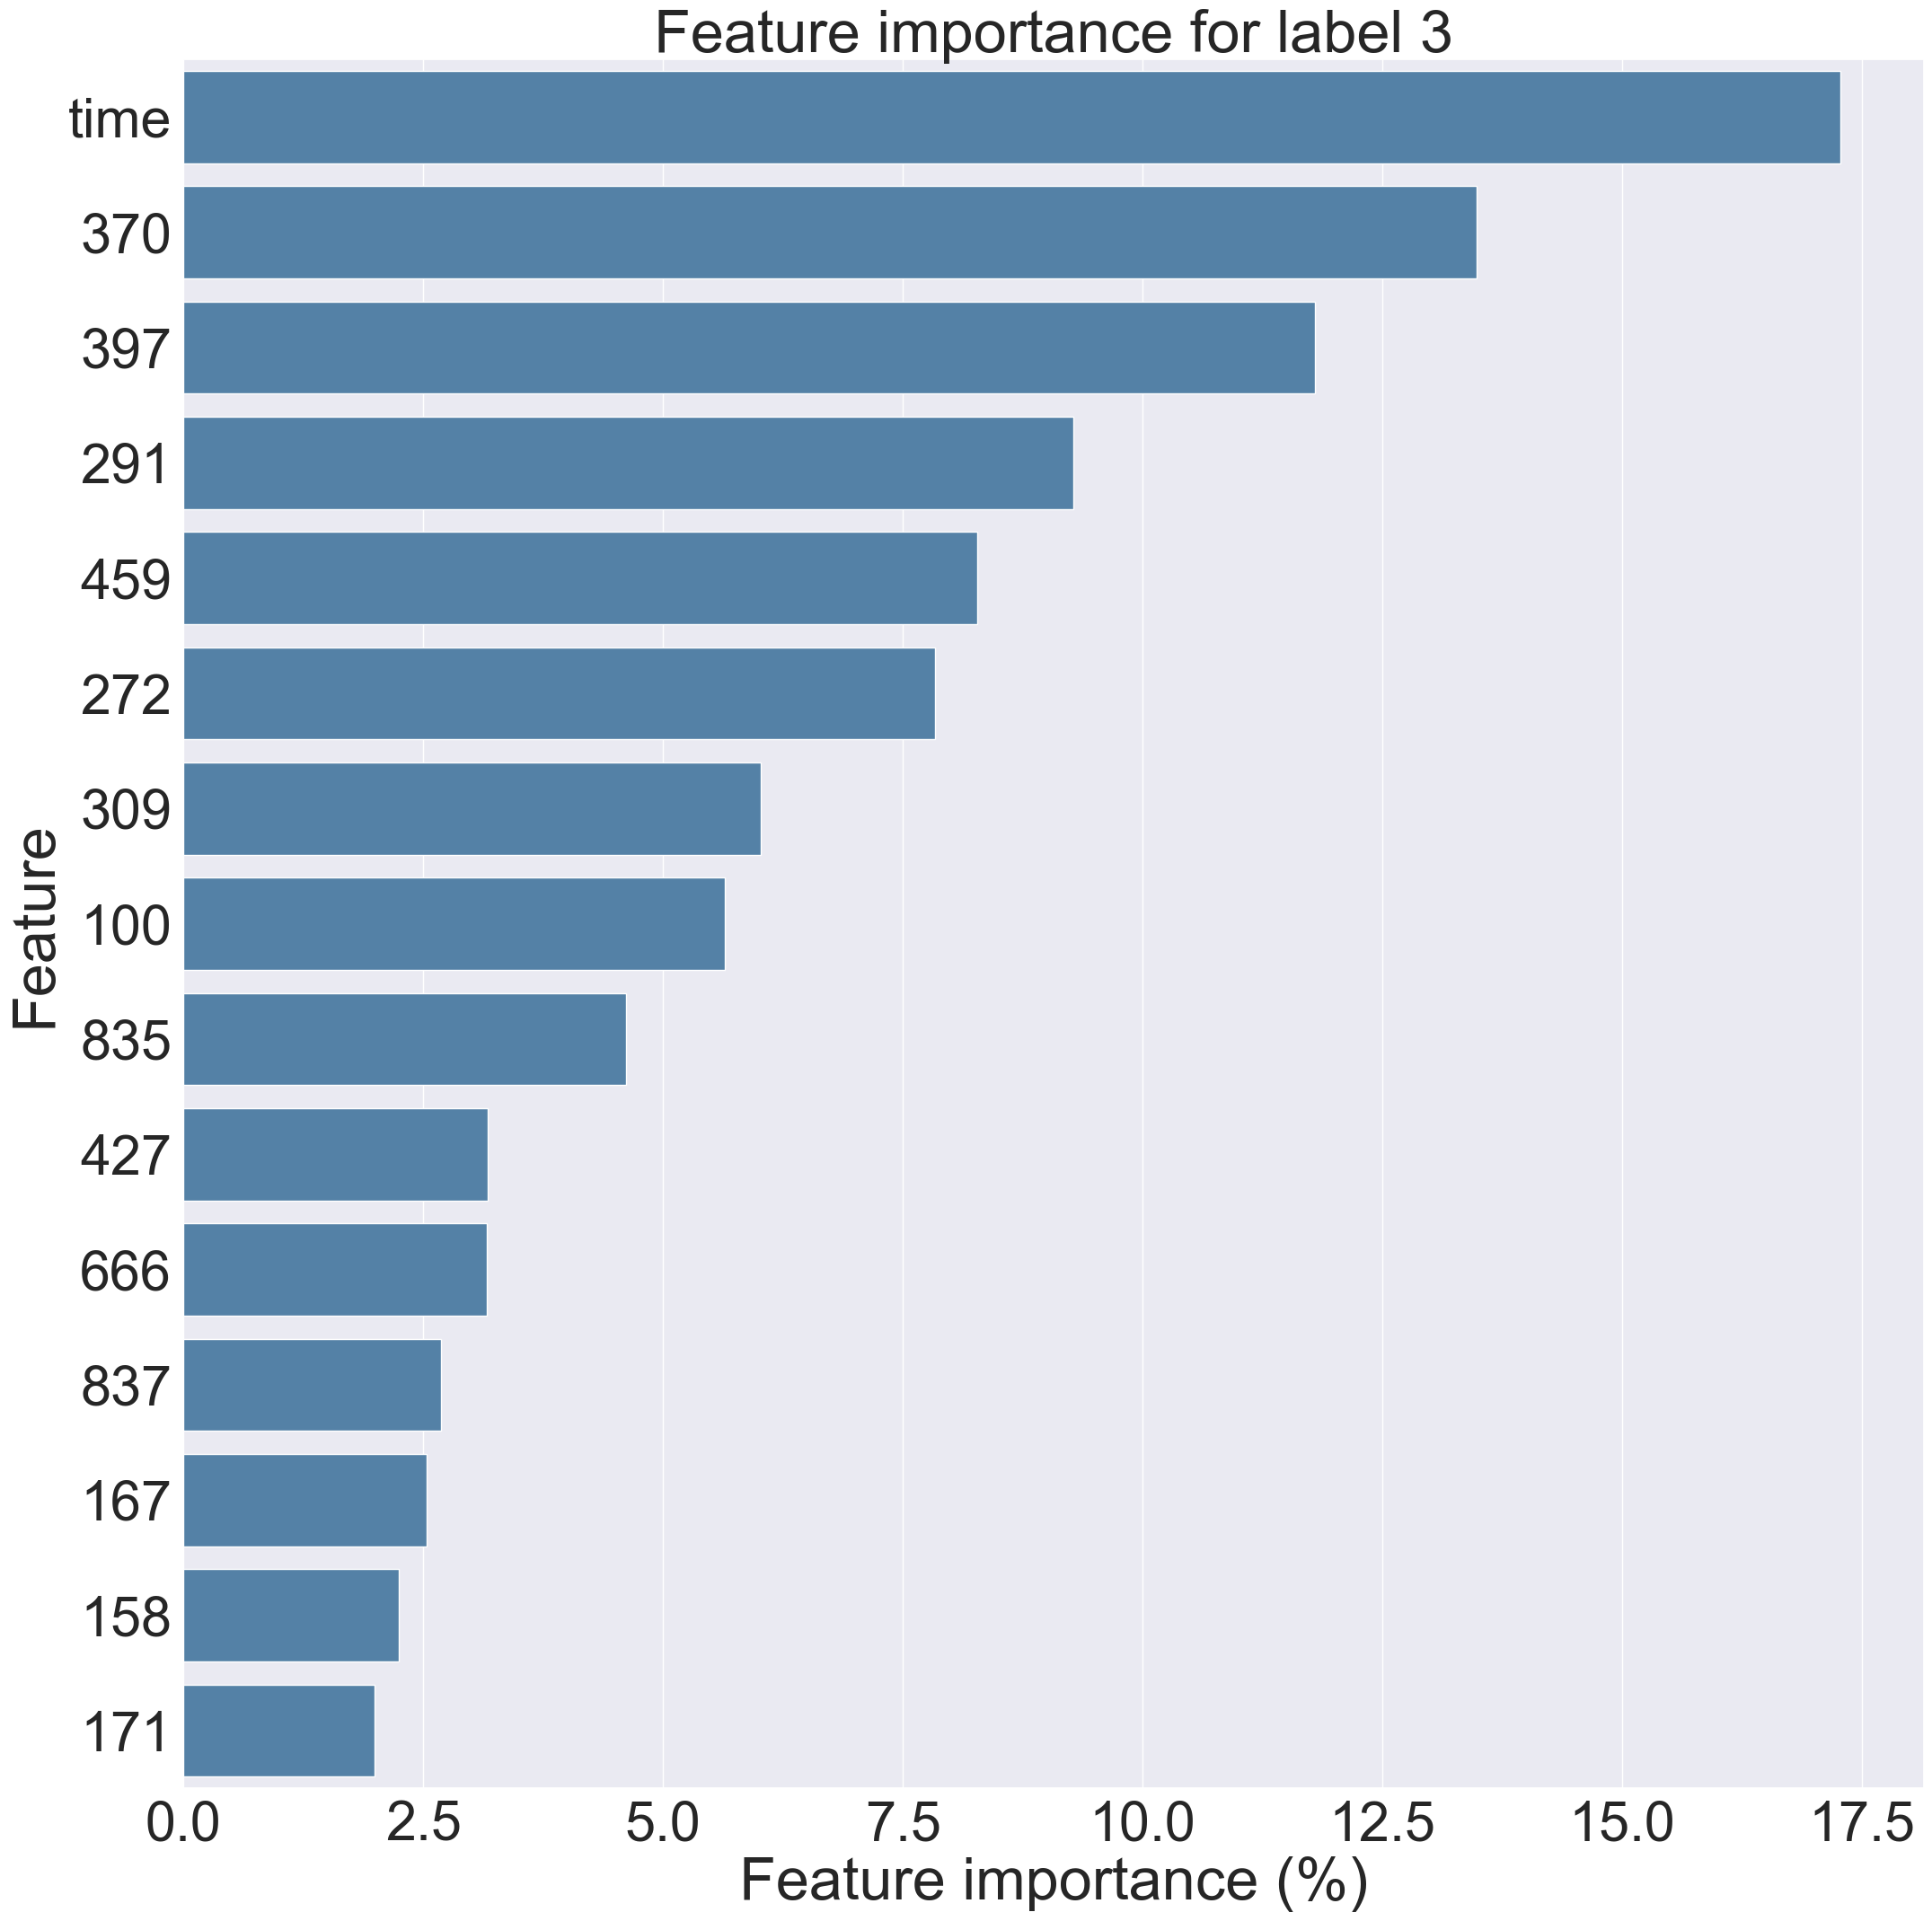

In [ ]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label}')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

### True positives

In [51]:
label = 4

In [52]:
x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_tp_or_fp_label_from_loader(train_loader, label, tp=True) 

tensor([ 50, 143, 144, 188])
tensor([ 29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
        123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
        137, 138, 139, 140, 141, 142, 143, 144, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
        177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 241, 242,
        243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255],
       device='cuda:0')
[ 50 143 144 188]


In [53]:
# test_idx = pd.Series(y_test.argmax(dim=-1).view(-1).numpy())
# test_idx = test_idx[test_idx == label].index.values.tolist()
x_test.shape

torch.Size([4, 200, 106])

In [54]:
explanation = get_lime_explanations(x_train, y_train, x_test[:10].numpy(), feature_names, ['0','1','2','3','4'], model)

In [55]:
explanation

In [56]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [57]:
feature_importance

feature timestamp         value
0       feature_25       t-2 -2.818867e-04
1       feature_24       t-2 -2.777735e-04
2       feature_24       t-1 -1.996599e-04
3       feature_23       t-2 -1.946747e-04
4       feature_25       t-1 -1.887583e-04
...            ...       ...           ...
21195   feature_87      t-46  5.433698e-10
21196   feature_21     t-183  3.981747e-10
21197   feature_23      t-13  3.593842e-10
21198   feature_88      t-21 -3.290822e-10
21199  feature_100     t-117 -1.501544e-10

[84800 rows x 3 columns]

In [58]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

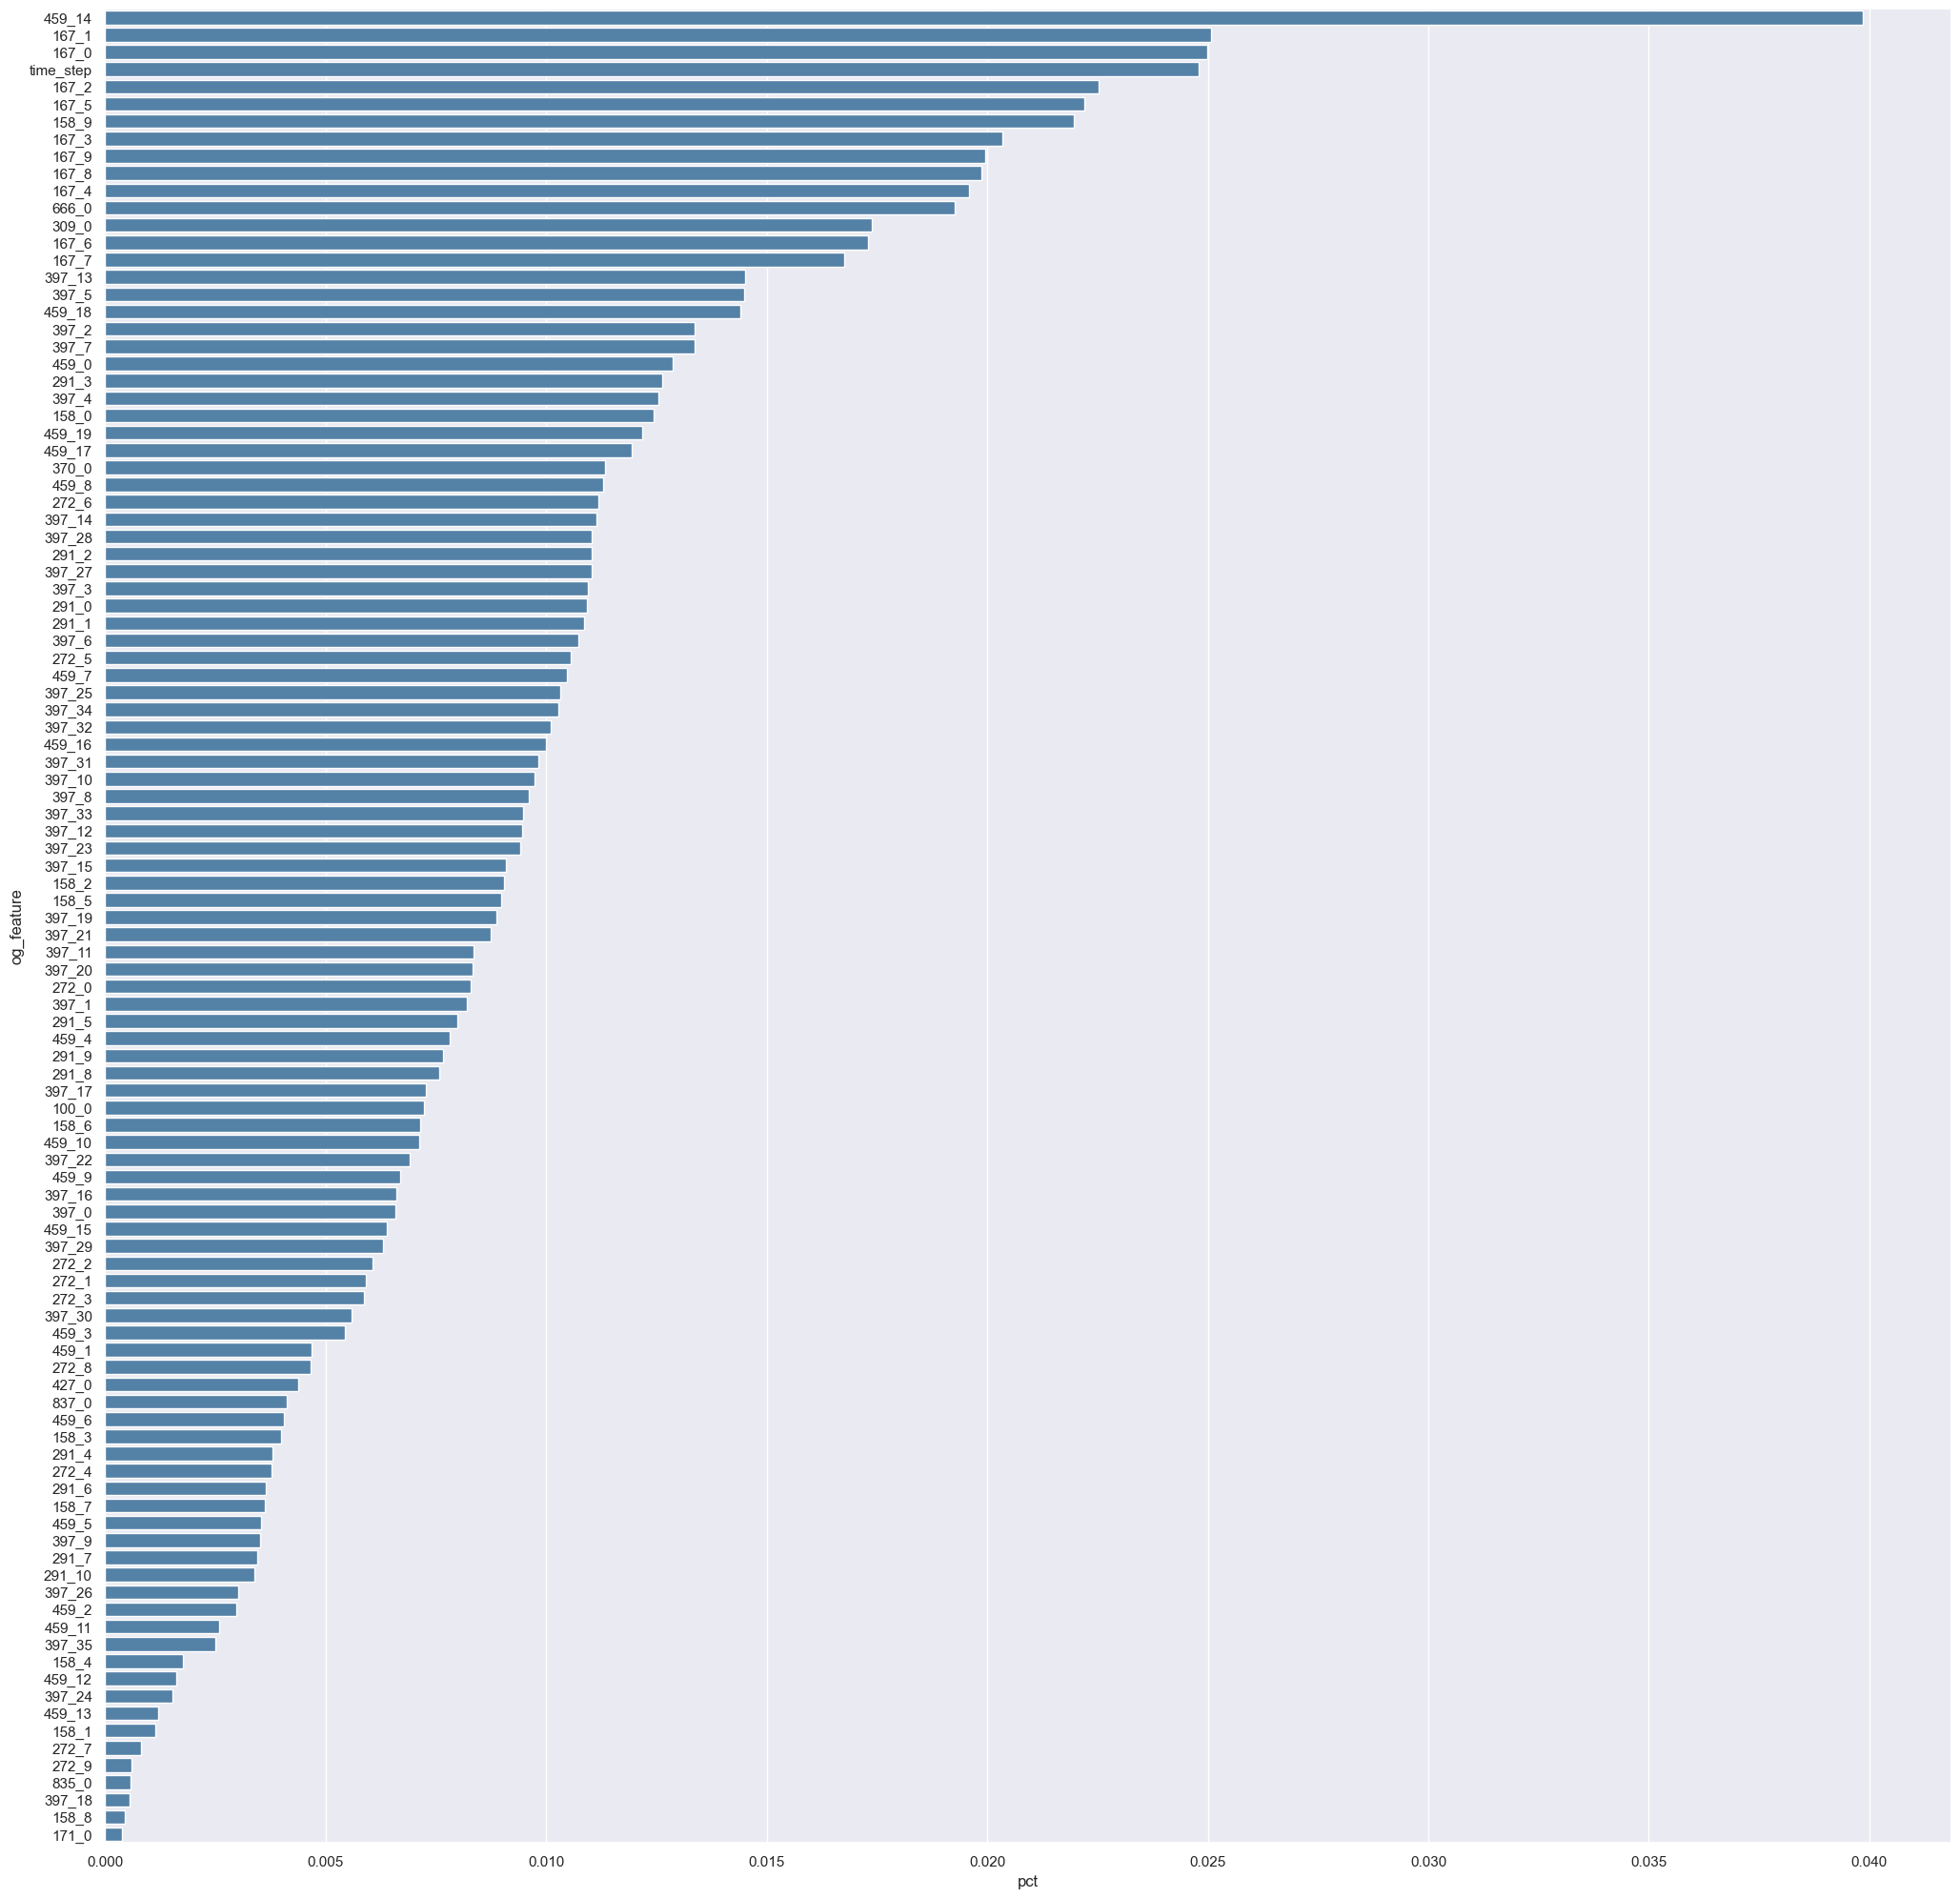

In [59]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum()
plt.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [60]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [61]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').sum().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

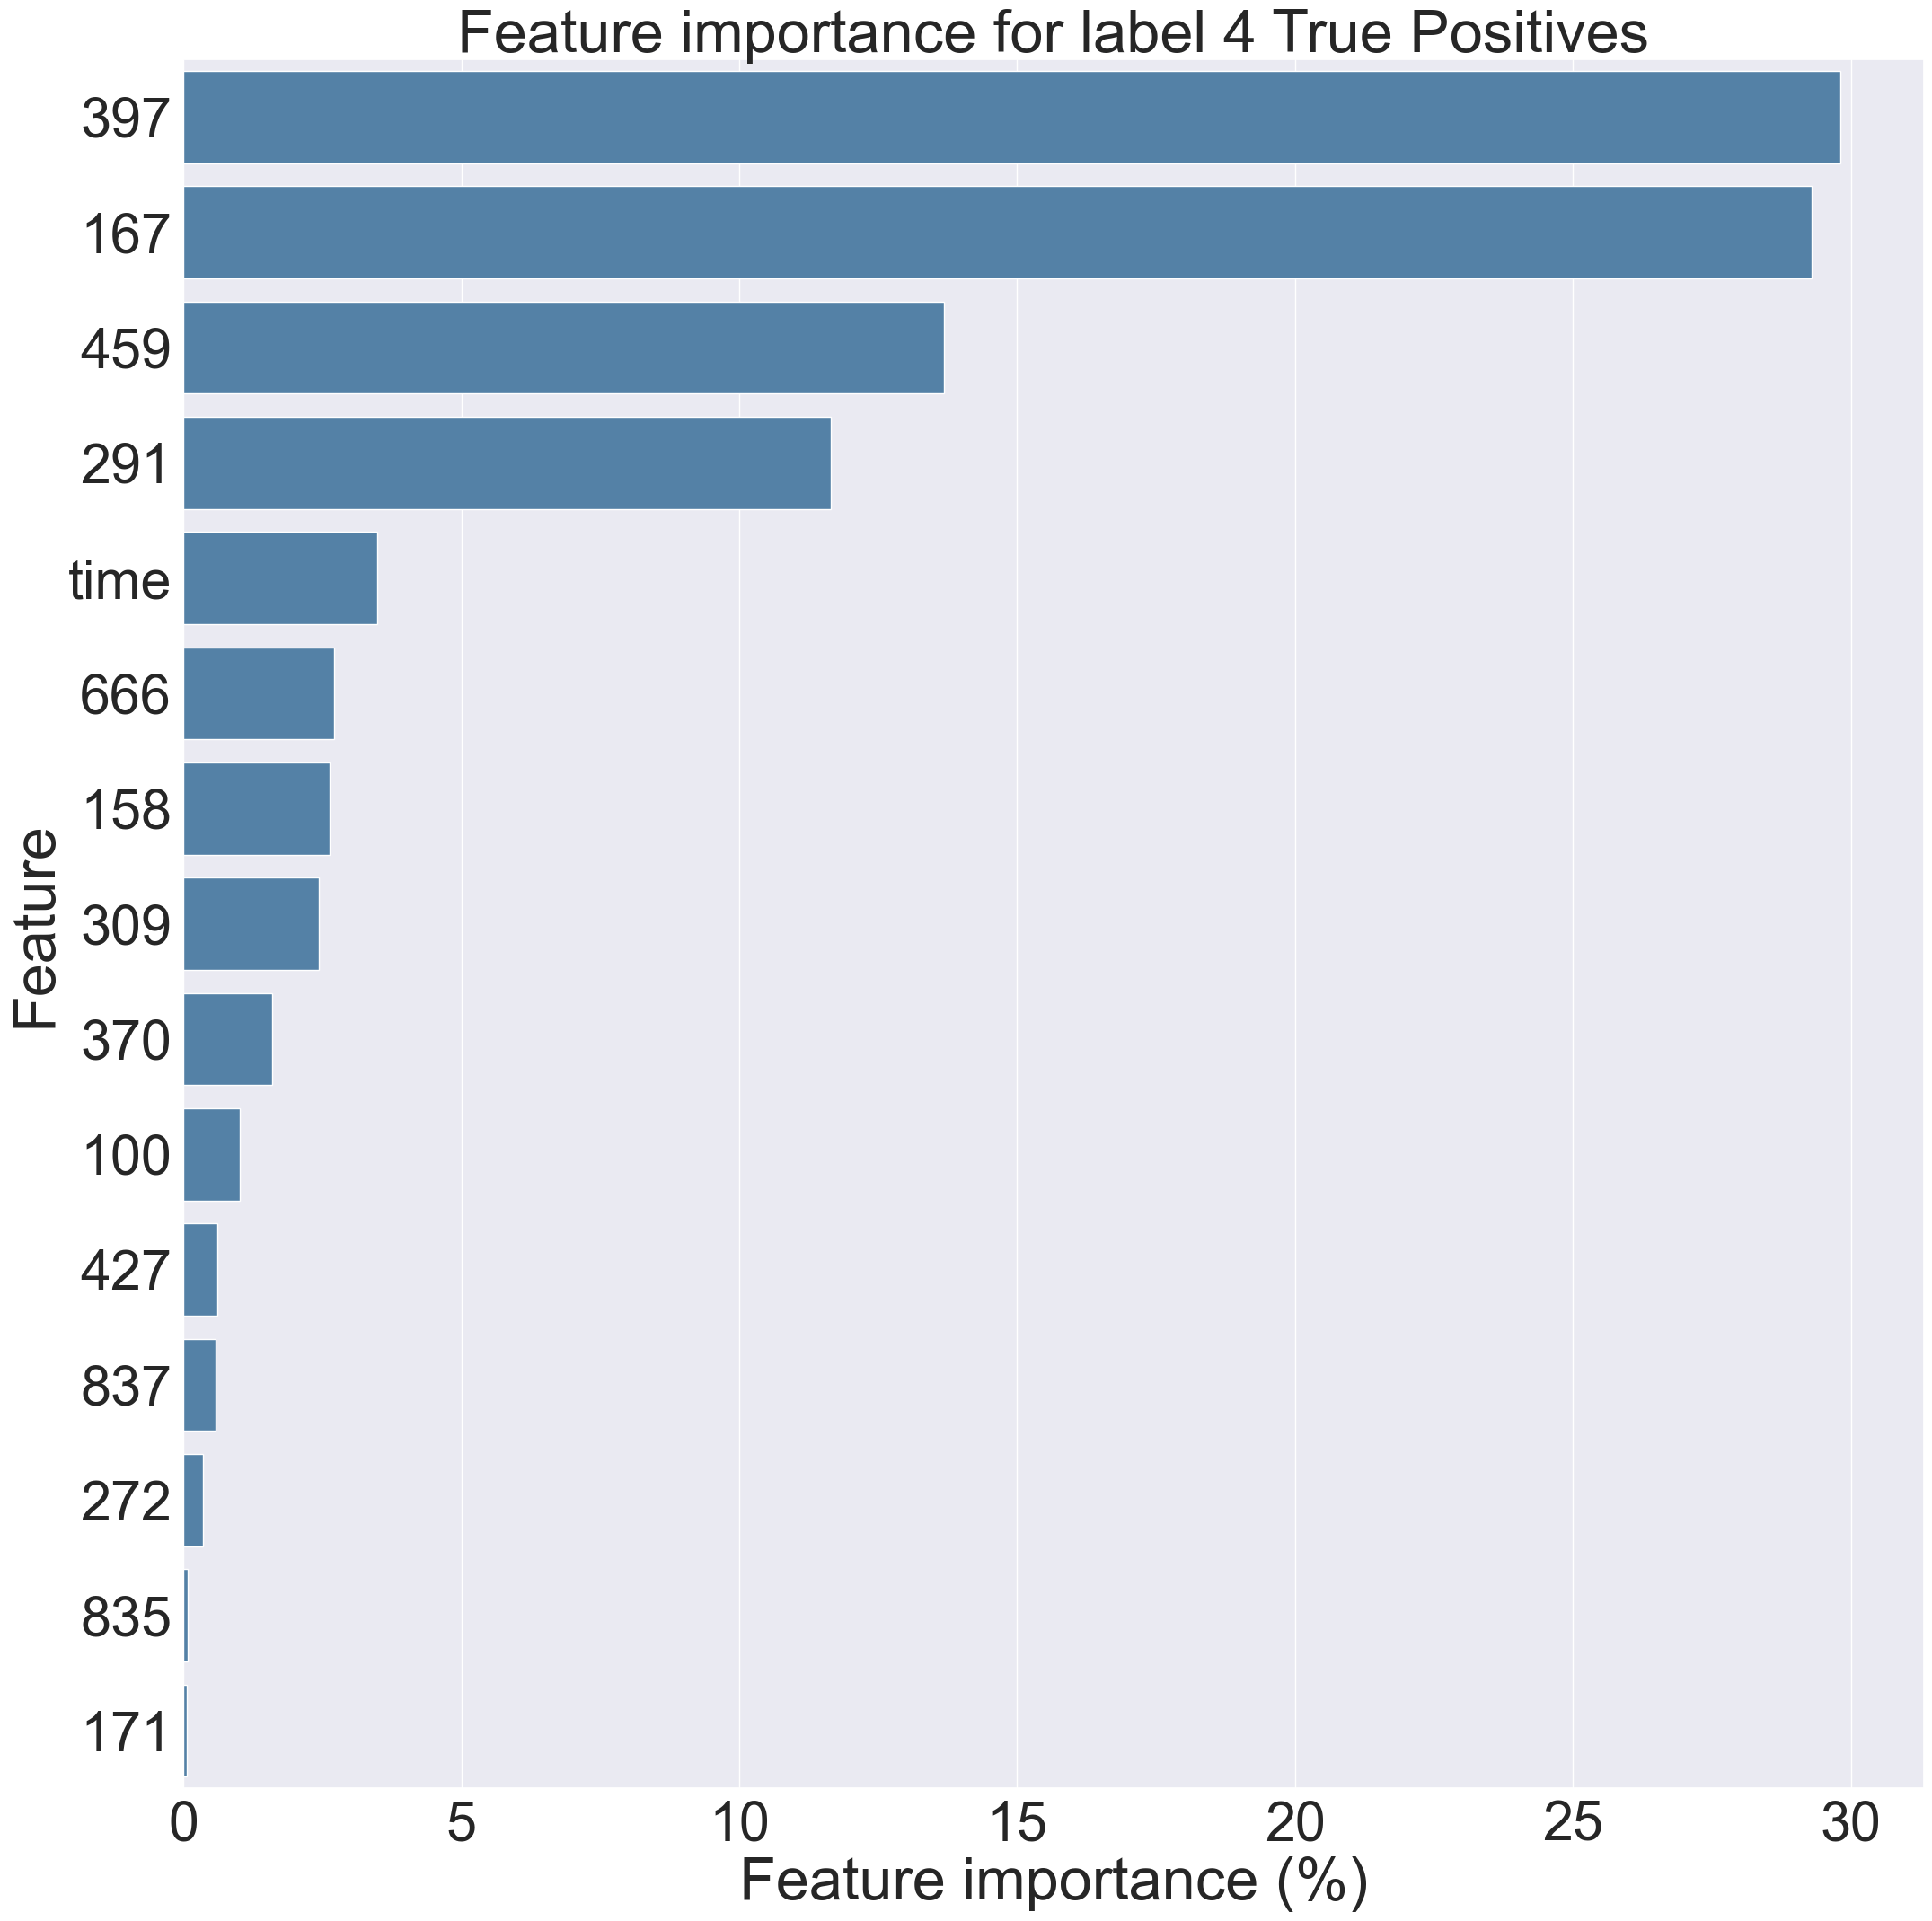

In [62]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label} True Positives')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

### False positive

In [63]:
label = 4

In [64]:
x_train, y_train = get_batch_with_label_from_loader(train_loader, label)
x_test, y_test = get_batch_with_tp_or_fp_label_from_loader(valid_loader, label, tp=False) 

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 1

In [65]:
# test_idx = pd.Series(y_test.argmax(dim=-1).view(-1).numpy())
# test_idx = test_idx[test_idx == label].index.values.tolist()
x_test.shape

torch.Size([235, 200, 106])

In [66]:
explanation = get_lime_explanations(x_train, y_train, x_test[:10].numpy(), feature_names, ['0','1','2','3','4'], model)

In [67]:
explanation

In [68]:
feature_importance = [ _.as_list(label=label) for _ in explanation]
_ = []
for row in feature_importance:
    _.append([ [re.findall(r'feature_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
feature_importance = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)

In [69]:
feature_importance

feature timestamp         value
0       feature_0      t-92  1.011026e-07
1       feature_5      t-92 -7.714517e-08
2       feature_5      t-91 -7.698715e-08
3       feature_0      t-91  7.025735e-08
4       feature_0      t-90  5.560371e-08
...           ...       ...           ...
21195  feature_81      t-77 -1.111228e-10
21196  feature_49      t-61  1.085869e-10
21197  feature_72     t-106  9.630851e-11
21198  feature_25      t-35  4.222387e-11
21199  feature_78      t-48  3.320361e-12

[212000 rows x 3 columns]

In [70]:
feature_importance_mean = feature_importance[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance = feature_importance[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='pct', ylabel='og_feature'>

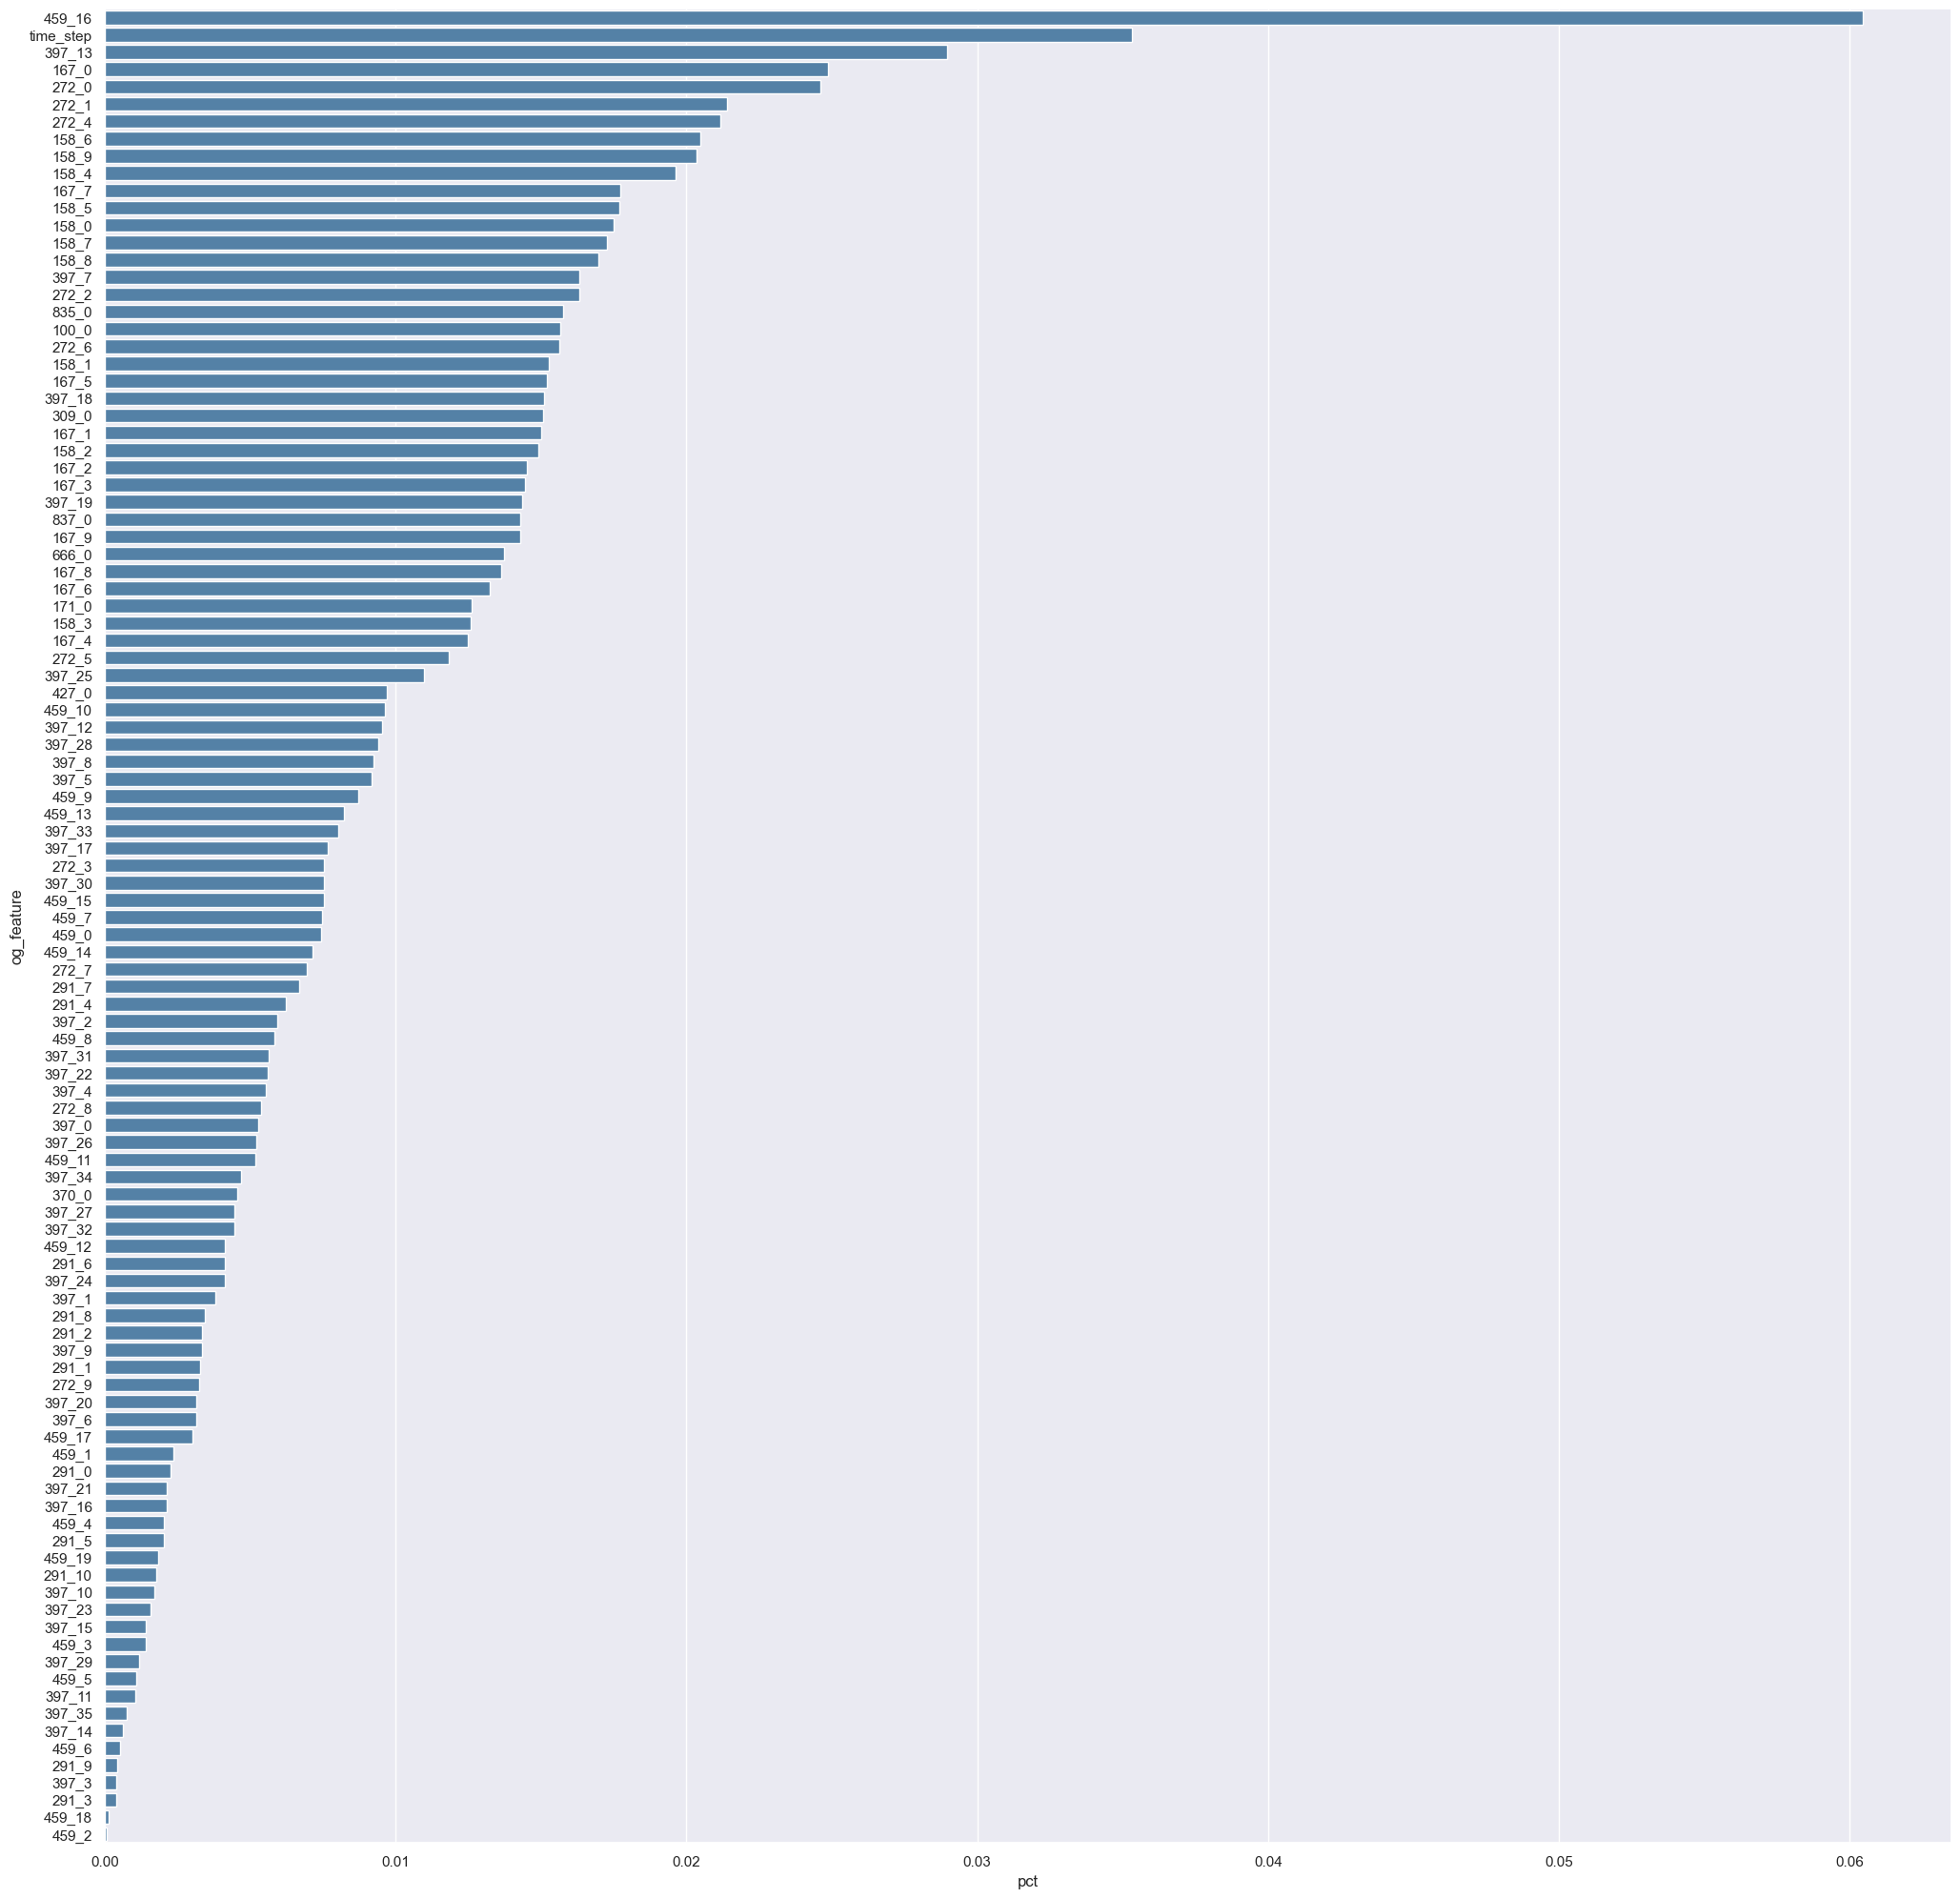

In [71]:
feature_data_for_plot = feature_importance_mean.reset_index()
feature_data_for_plot['og_feature'] = feature_data_for_plot['feature'].map(feature_name_map)
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum()
plt.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.barplot(x='pct', y='og_feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
#feature_data_for_plot[['feature','cumsum']]

In [72]:
feature_importance['og_feature'] = feature_importance['feature'].map(feature_name_map)
feature_importance['feature_hist_sum'] = feature_importance['og_feature'].apply(lambda x: x.split('_')[0])

In [73]:
feature_importance_mean_feature = feature_importance[['value','feature_hist_sum']].groupby('feature_hist_sum').sum().sort_values(by='value', ascending=False)

Text(0, 0.5, 'Feature')

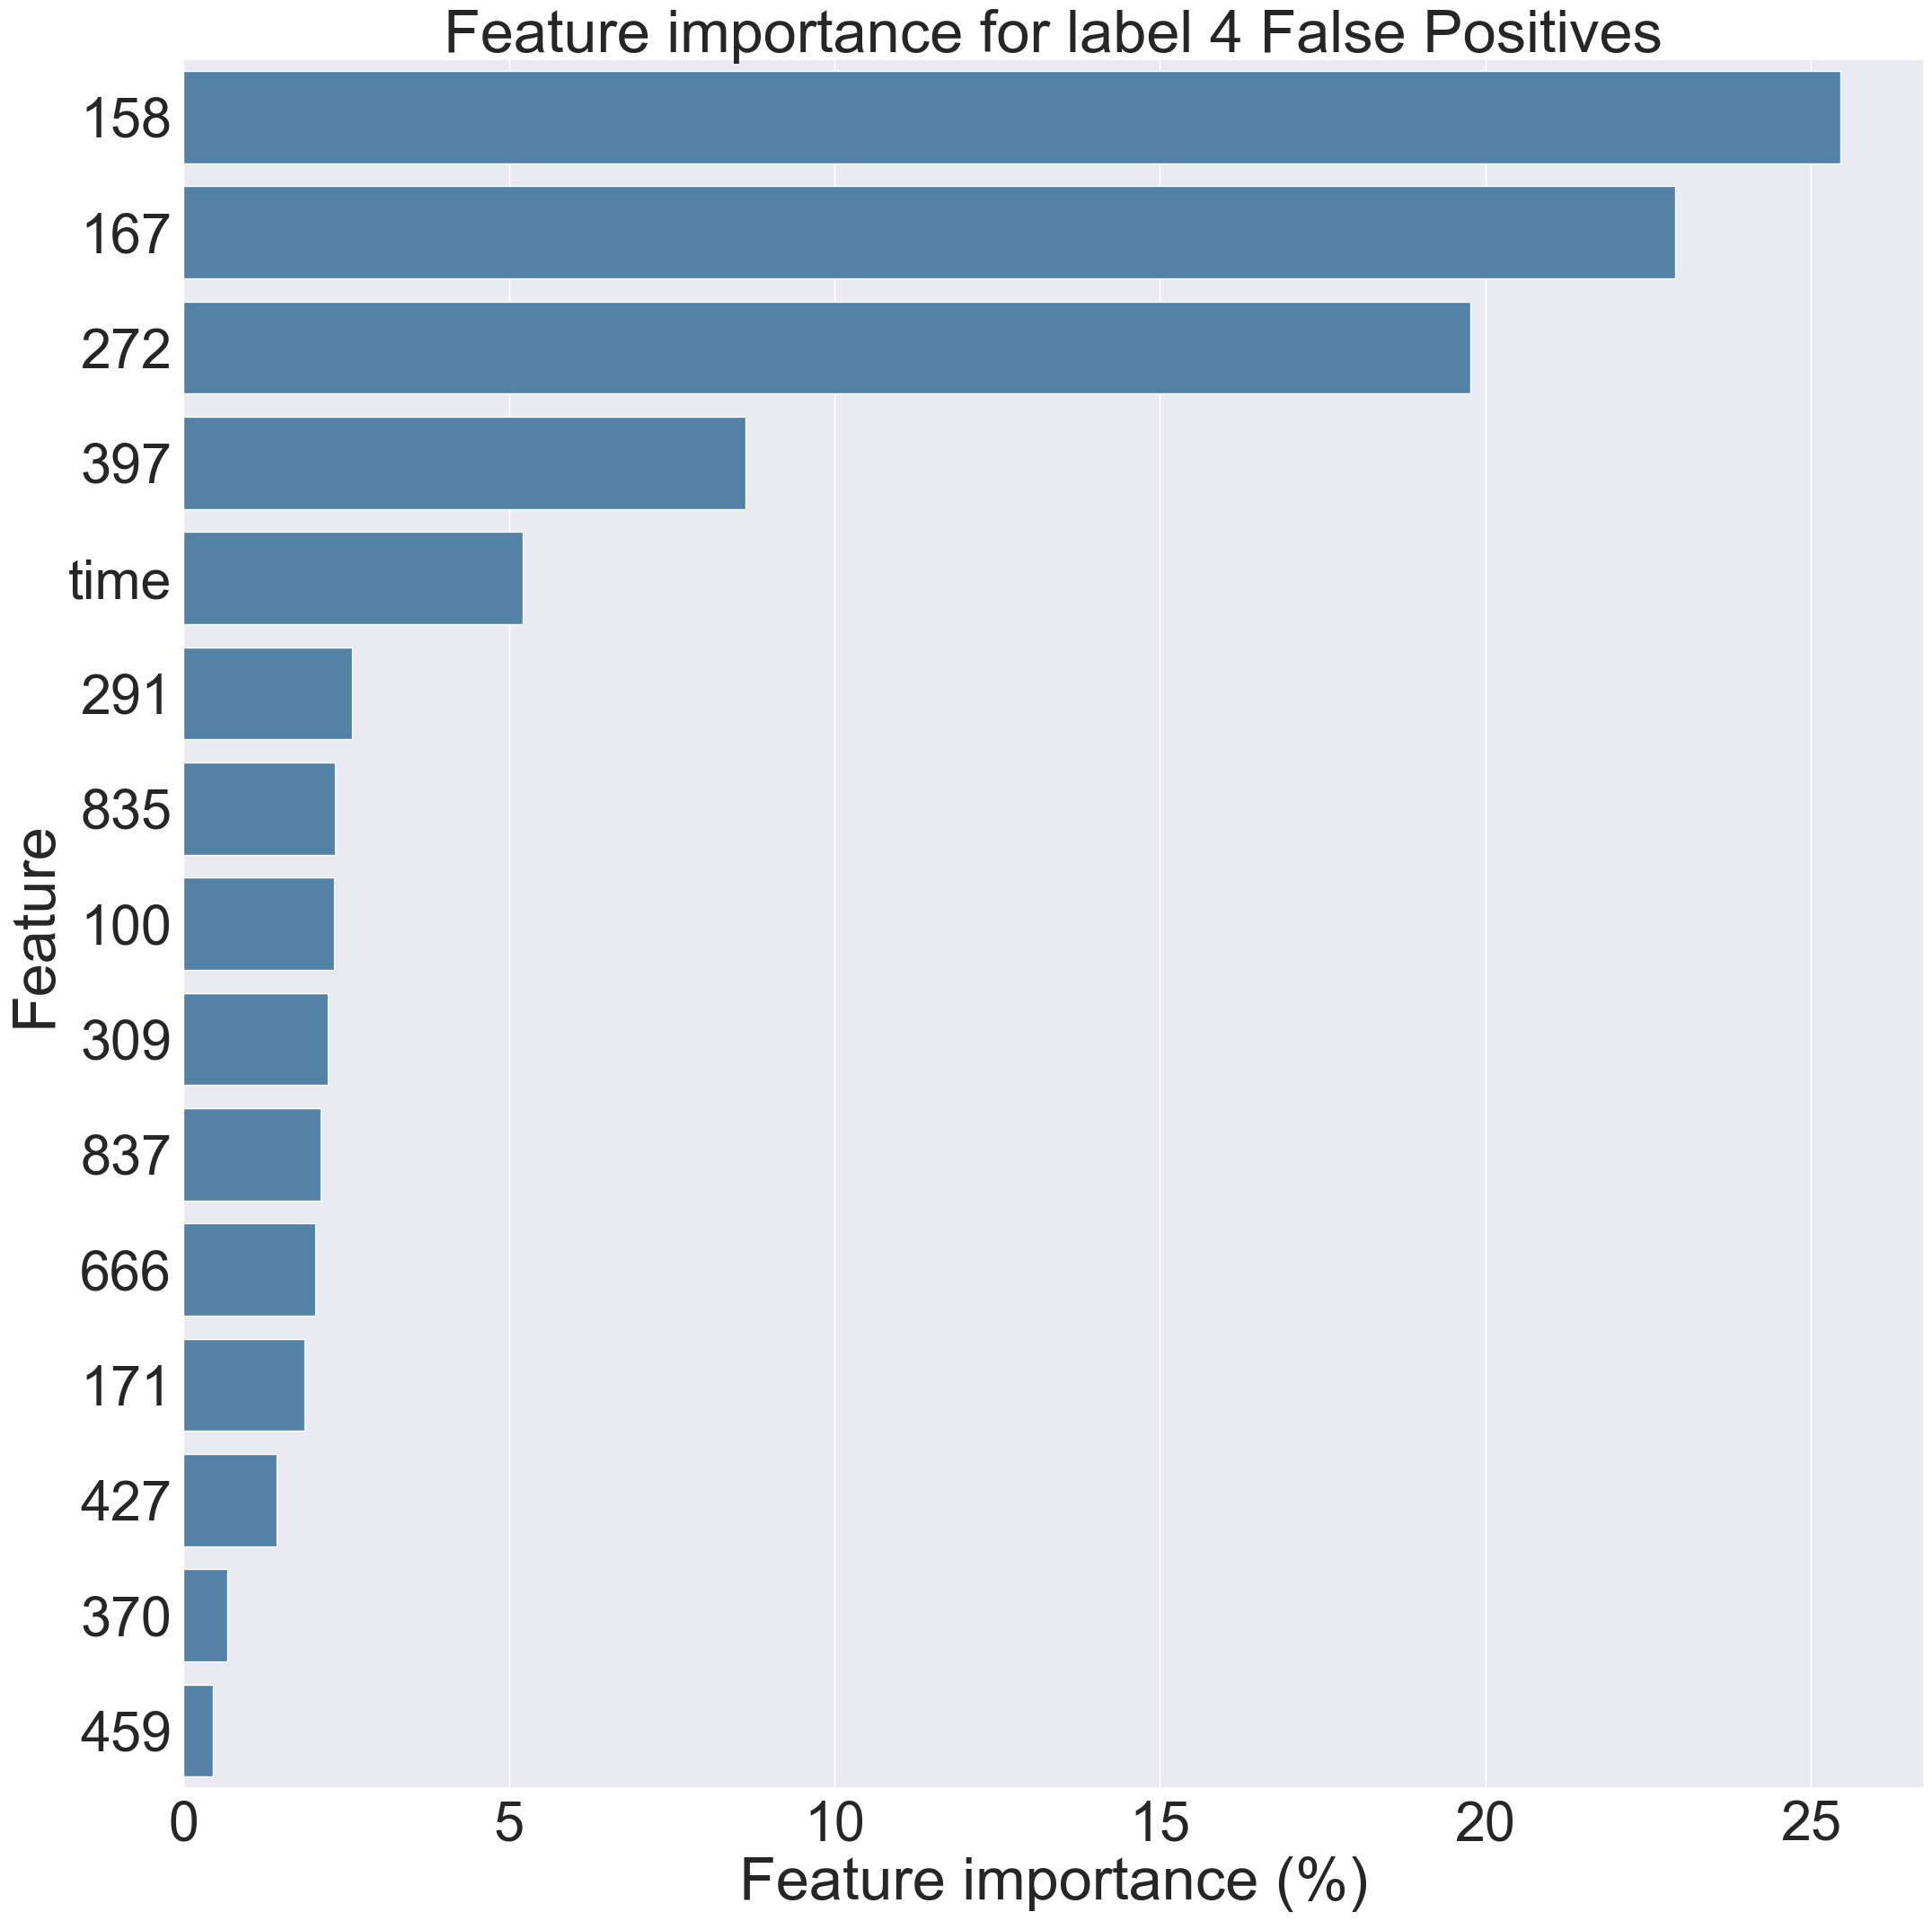

In [74]:
feature_data_for_plot = feature_importance_mean_feature.reset_index()
feature_data_for_plot['pct'] = abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum() * 100.0
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature_hist_sum', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title(f'Feature importance for label {label} False Positives')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]